In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

# 출력값 초기화
from google.colab import output
output.clear()

# 경로 수정
import os
os.chdir("drive/MyDrive/Colab Notebooks/가스공급량 수요예측 모델개발")

In [2]:
# import libary
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os, glob, sys
import matplotlib.pyplot as plt

train_csv = pd.read_csv("./datasets/한국가스공사_시간별 공급량.csv", encoding = 'cp949', engine='python')

# test_csv 파일 전처리
test_csv = pd.read_csv("./datasets/test.csv", encoding = 'utf-8')

test_date = []
test_hour = []
test_class = []

for component in test_csv.values:
    string = component.item()
    test_date.append(string.split(" ")[0])
    test_hour.append(string.split(" ")[1])
    test_class.append(string.split(" ")[-1])

test_csv = pd.DataFrame({'연월일':test_date, "시간":test_hour, "구분":test_class})
sample_submission = pd.read_csv("./datasets/sample_submission.csv", encoding = "utf-8")

# rename column
train_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class", "공급량":"power"}, inplace = True)

# rename column
test_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class"}, inplace = True)

In [3]:
# 자료형 변환
from datetime import datetime

# time : str to datetime
try:
    train_csv["time"] = train_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
    test_csv["time"] = test_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
except:
    print("data type of time not str or already converted")

# hour : str to int

try:
    test_csv["hour"] = test_csv["hour"].apply(lambda x : int(x))
except:
    print("data type of hour not str or already converted")

In [4]:
# time - hour => timestamp with yyyy-mm-dd-hh
import datetime

def df_time_convert(df):
    df_copy = df.copy(...)
    timestamp_list = []
    for idx in range(len(df)):
        timestamp_list.append(df_copy.time.iloc[idx] + datetime.timedelta(hours = df_copy.hour.iloc[idx].item()))
    df_copy["time"] = timestamp_list
    return df_copy

# class에 따른 데이터프레임 분류
def df_class_split(df, cls = "A"):
    df_copy = df.copy(...)
    df_copy = df_copy[df_copy["class"] == cls]
    return df_copy

# class to idx
def class_to_idx(x):
    dic = {'A':0,"B":1,"C":2,"D":3,'E':4,'G':5,"H":6}
    if type(x) == str:
        try:
            return_value = int(dic[x])
        except:
            return_value = 0
            print("didn't find class {}".format(x))

    else:
        return_value = 0
    
    return return_value

# convert original scale to log scale
def convert2log(x):
    eps = 1e-6
    if abs(x) < eps:
        return NaN
    else:
        return np.log1p(x)
    
def convert2origin(x):
    return np.exp(x) - 1

In [5]:
# External Data(weather)
import glob2
import datetime

path_list_external_weather = glob2.glob("./dataset_external_weather/*")
print(path_list_external_weather)

df_weather = None
for idx, path in enumerate(path_list_external_weather):

    if idx == 0:
        df_weather = pd.read_csv(path, encoding = "cp949")
    else:
        df_temp = pd.read_csv(path, encoding = "cp949")
        df_weather = pd.concat([df_weather, df_temp], axis = 0)


# column name change
df_weather.rename(columns = {"일시": "date_time","기온(°C)" : "temperature", "습도(%)":"humidity", "증기압(hPa)" : "vapor", "현지기압(hPa)":"pressure", "풍속(m/s)":"wind_speed"}, inplace = True)

df_weather["date_time"] = df_weather["date_time"].apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%d %H:%M" ))

# 결측치 보완
df_weather["temperature"] = df_weather["temperature"].interpolate(method = "values")
df_weather["humidity"] = df_weather["humidity"].interpolate(method = "values")
df_weather["vapor"] = df_weather["vapor"].interpolate(method = "values")
df_weather["wind_speed"] = df_weather["wind_speed"].interpolate(method = "values")
df_weather["pressure"] = df_weather["pressure"].interpolate(method = "values")

# merge
df = train_csv.copy()
df = df_time_convert(df)
df["class"] = df["class"].apply(lambda x : int(class_to_idx(x)))

df_merge = pd.merge(left = df, right = df_weather[["date_time", "temperature", "humidity", "vapor", "pressure", "wind_speed"]], how = 'outer', left_on = "time", right_on = "date_time")
df_merge = df_merge.drop(columns = ['date_time'], axis = 1)

['./dataset_external_weather/OBS_ASOS_TIM_20211017003024.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017003117.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004006.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004047.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004154.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004224.csv']


In [6]:
df_merge = df_merge.dropna()

In [7]:
# anomality annhiliation
# 우선 class별로 분포가 다르므로, class에 따라 묶어서 anomality annhiliation을 진행한다
class_list = np.unique(train_csv["class"].values).tolist()
df_list = [df_class_split(df_merge, cls = i).sort_values(by = ["time"]) for i in range(len(class_list))]

# 데이터 구분
# df_list : class별로 나눈 데이터
# df_merge : 외부데이터까지 하나로 합친 데이터

# range and length analysis
idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

class : A, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [8]:
# 이상치 제거
def remove_outlier(df_input, column):
    df = df_input.copy(...)
    df_removed_column_outlier = df[column]
    quan_25 = np.percentile(df_removed_column_outlier.values, 25)
    quan_75 = np.percentile(df_removed_column_outlier.values, 75)

    iqr = quan_75 - quan_25
    iqr = iqr * 1.5

    lowest = quan_25 - iqr
    highest = quan_75 + iqr

    outlier_index = df_removed_column_outlier[(df_removed_column_outlier < lowest) | (df_removed_column_outlier > highest)].index
    
    if len(outlier_index) > 0:
        print("# outlier detected")
        df.drop(outlier_index, axis = 0, inplace = True)
    else:
        print("# outlier not detected")
        pass

    return df

df_list_new = []
for df in df_list:
    df = remove_outlier(df, "power")
    df_list_new.append(df)

df_list = df_list_new

idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
class : A, length : 52231, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52300, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52308, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52439, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52332, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52214, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52352, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [9]:
# 0인 이상치도 제거...
df_list_new = []
for df in df_list:
    index_list = df["power"].values > 10
    df = df.iloc[index_list]
    df_list_new.append(df)

df_list = df_list_new

In [10]:
# 최종적으로 쓸 dataframe
# df_list를 모두 합친 데이터프레임
df = None

for df_class in df_list:
    if df is None:
        df = df_class
    else:
        df = pd.concat([df, df_class], axis = 0)

display(df)

,time,hour,class,power,temperature,humidity,vapor,pressure,wind_speed
0,2013-01-01 01:00:00,1.0,0.0,2497.129,-8.5,57.0,1.8,1010.0,4.0
7,2013-01-01 02:00:00,2.0,0.0,2363.265,-8.4,60.0,2.0,1009.4,4.0
14,2013-01-01 03:00:00,3.0,0.0,2258.505,-8.1,58.0,1.9,1009.2,3.4
21,2013-01-01 04:00:00,4.0,0.0,2243.969,-8.2,58.0,1.9,1008.2,3.8
28,2013-01-01 05:00:00,5.0,0.0,2344.105,-8.2,61.0,2.0,1007.3,4.4
...,...,...,...,...,...,...,...,...,...
368059,2018-12-31 20:00:00,20.0,6.0,681.033,-3.7,39.0,1.8,1024.9,0.8
368066,2018-12-31 21:00:00,21.0,6.0,669.961,-4.6,44.0,1.9,1024.8,1.1
368073,2018-12-31 22:00:00,22.0,6.0,657.941,-5.4,46.0,1.9,1024.4,1.3
368080,2018-12-31 23:00:00,23.0,6.0,610.953,-5.2,47.0,2.0,1024.6,1.6


In [11]:
# year / month / day -> sinusoidal value
day = 24 * 60 * 60
month = (30.0) * day
year = (365.2425)*day

df["month_cos"] = np.cos(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))
df["month_sin"] = np.sin(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))

df["year_cos"] = np.cos(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))
df["year_sin"] = np.sin(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))

df["day_cos"] = np.cos(df.hour.values * (2 * np.pi / 24))
df["day_sin"] = np.sin(df.hour.values * (2 * np.pi / 24))

output.clear()

In [12]:
# categorical variable로 전환
df["class"] = df["class"].astype("category")
df["class"] = df["class"].apply(lambda x : int(x))

In [13]:
df["year"] = df["time"].apply(lambda x : int(x.year))
df["month"] = df["time"].apply(lambda x : int(x.month))
df["day"] = df["time"].apply(lambda x : int(x.day))
df["hour"] = df["time"].apply(lambda x : int(x.hour))
df["weekday"] = df["time"].apply(lambda x : int(x.dayofweek))

df["year"] = df["year"].astype("int")
df["month"] = df["month"].astype("int")
df["day"] = df["day"].astype("int")
df["hour"] = df["hour"].astype("int")
df["weekday"] = df["weekday"].astype("category")

In [14]:
# log-scale 처리된 power 값 추가
df["log_power"] = df["power"].apply(lambda x : convert2log(x))

In [15]:
df.reset_index(drop = True)

,time,hour,class,power,temperature,humidity,vapor,pressure,wind_speed,month_cos,month_sin,year_cos,year_sin,day_cos,day_sin,year,month,day,weekday,log_power
0,2013-01-01 01:00:00,1,0,2497.129,-8.5,57.0,1.8,1010.0,4.0,-0.976296,-0.216440,0.999944,0.010565,0.965926,2.588190e-01,2013,1,1,1,7.823297
1,2013-01-01 02:00:00,2,0,2363.265,-8.4,60.0,2.0,1009.4,4.0,-0.974370,-0.224951,0.999936,0.011282,0.866025,5.000000e-01,2013,1,1,1,7.768222
2,2013-01-01 03:00:00,3,0,2258.505,-8.1,58.0,1.9,1009.2,3.4,-0.972370,-0.233445,0.999928,0.011999,0.707107,7.071068e-01,2013,1,1,1,7.722901
3,2013-01-01 04:00:00,4,0,2243.969,-8.2,58.0,1.9,1008.2,3.8,-0.970296,-0.241922,0.999919,0.012715,0.500000,8.660254e-01,2013,1,1,1,7.716447
4,2013-01-01 05:00:00,5,0,2344.105,-8.2,61.0,2.0,1007.3,4.4,-0.968148,-0.250380,0.999910,0.013432,0.258819,9.659258e-01,2013,1,1,1,7.760085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363405,2018-12-31 20:00:00,20,6,681.033,-3.7,39.0,1.8,1024.9,0.8,-0.927184,-0.374607,1.000000,-0.000846,0.500000,-8.660254e-01,2018,12,31,0,6.525078
363406,2018-12-31 21:00:00,21,6,669.961,-4.6,44.0,1.9,1024.8,1.1,-0.923880,-0.382683,1.000000,-0.000129,0.707107,-7.071068e-01,2018,12,31,0,6.508711
363407,2018-12-31 22:00:00,22,6,657.941,-5.4,46.0,1.9,1024.4,1.3,-0.920505,-0.390731,1.000000,0.000588,0.866025,-5.000000e-01,2018,12,31,0,6.490634
363408,2018-12-31 23:00:00,23,6,610.953,-5.2,47.0,2.0,1024.6,1.6,-0.917060,-0.398749,0.999999,0.001305,0.965926,-2.588190e-01,2018,12,31,0,6.416655


In [16]:
df_train = None

for class_idx in range(len(class_list)):

    train_idx_list = []
    df_class = df[df["class"] == class_idx]

    for idx in range(len(df_class)):
        y = df_class['time'].iloc[idx].year
        m = df_class['time'].iloc[idx].month

        if y != 2018 and y != 2019:
            train_idx_list.append(idx)

    df_train_class = df_class.iloc[train_idx_list]

    if df_train is None:
        df_train = df_train_class
    else:
        df_train = pd.concat([df_train, df_train_class], axis = 0)

# build test data
df_test = None

for class_idx in range(len(class_list)):
    df_class = df[df["class"] == class_idx]
    test_idx_list = []

    for idx in range(len(df_class)):
        y = df_class['time'].iloc[idx].year
        m = df_class['time'].iloc[idx].month

        if y == 2018:
            test_idx_list.append(idx)

    df_test_class = df_class.iloc[test_idx_list]

    if df_test is None:
        df_test = df_test_class
    else:
        df_test = pd.concat([df_test, df_test_class], axis = 0)

In [17]:
def calc_nmae(y_test, y_pred):
    score = np.mean((np.abs((y_test - y_pred)/y_test)))
    return score

In [18]:
!pip install catboost
!pip install git+https://github.com/ourownstory/neural_prophet.git
!pip install optuna
output.clear()

In [19]:
# k-fold stacking ensemble without supervised learning(series to supervised)
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import optuna

# columns for use
x_cols = ["year_cos", "year_sin", "month_cos", "month_sin", "day_cos", "day_sin","month", "year", "day", "hour", "class", "weekday"]
y_cols = ["log_power", "power"]

# k-fold validation
num_k = len(class_list)
k_fold = StratifiedKFold(n_splits = num_k, shuffle = True, random_state = 42)

x_train, y_train = df_train[x_cols], df_train[y_cols]
x_test, y_test = df_test[x_cols], df_test[y_cols]

In [21]:
# lgbm hyper-parameter tunning
import lightgbm as lgb
import optuna

def custom_metric(y_pred, dataset):
    y_true = dataset.get_label().reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    y_true = convert2origin(y_true)
    y_pred = convert2origin(y_pred)
    eps = 1e-3
    score = np.mean((np.abs(y_true - y_pred)) / (y_true + eps))
    return 'custom_metric score', score, False

def objective(trial):

    d_train = lgb.Dataset(x_train, y_train[["log_power"]])
    d_test = lgb.Dataset(x_test, y_test[["log_power"]])

    param = {
        'metric': trial.suggest_categorical('metric',['mae', 'mse']),
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-5, 1e-1),
    }

    gbm = lgb.train(param, d_train, valid_sets = d_test, feval = custom_metric, verbose_eval = False)

    preds = gbm.predict(x_test)
    preds = convert2origin(preds)
    accuracy = calc_nmae(y_test["power"].values.reshape(-1,1), preds.reshape(-1,1))
    return accuracy

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
lgb_best_params = study.best_params

[I 2021-12-09 11:24:24,527] A new study created in memory with name: no-name-141301a4-5e8a-4399-9277-676172462070
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

[I 2021-12-09 11:24:28,039] Trial 0 finished with value: 0.14130295594285439 and parameters: {'metric': 'mse', 'lambda_l1': 0.00019563422527183423, 'lambda_l2': 0.01310283104540891, 'num_leaves': 138, 'feature_fraction': 0.8784742063365734, 'bagging_fraction': 0.9432959489917974, 'bagging_freq': 7, 'min_child_samples': 8, 'min_child_weight': 0.017746209791167533}. Best is trial 0 with value: 0.14130295594285439.
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

[I 2021-12-09 11:24:30,804] Trial 1 finished with value: 0.14364427182870163 and parameters: {'metric': 'mae', 'lambda_l1': 0.31301679884709976, 'lambda_l2': 0.8207863913305898, 'num_leaves': 66, 'feature_fraction': 0.

In [24]:
# custom metric for xgb
def xgb_custom_metric(y_pred, dataset):
    y_true = dataset.get_label().reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    y_true = convert2origin(y_true)
    y_pred = convert2origin(y_pred)

    eps = 1e-3
    score = np.mean((np.abs(y_true - y_pred)) / (y_true + eps))
    return 'custom_metric_score', score

import numpy as np
import optuna
import xgboost as xgb

def xgb_objective(trial):

    d_train = xgb.DMatrix(data = x_train.values, label = y_train[["log_power"]].values, feature_names = x_train.columns)
    d_test = xgb.DMatrix(data = x_test.values, label = y_test[["log_power"]].values, feature_names = x_test.columns)

    param = {
        "verbosity": 0,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-4, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 16, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, d_train, evals=[(d_train,'train'), (d_test,'test')], feval = xgb_custom_metric)
    preds_valid = bst.predict(d_test)
    preds_valid = convert2origin(preds_valid)
    accuracy = calc_nmae(y_test["power"].values.reshape(-1,1), preds_valid.reshape(-1,1))

    return accuracy


study = optuna.create_study(direction="minimize")
study.optimize(xgb_objective, n_trials=100, timeout=600)
xgb_best_params = study.best_params

[I 2021-12-09 11:31:22,683] A new study created in memory with name: no-name-86d3d256-4a00-4cf1-b692-10d347756f9c
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.8588	test-rmse:5.91544	train-custom_metric_score:0.997501	test-custom_metric_score:0.99756
[1]	train-rmse:5.78856	test-rmse:5.84522	train-custom_metric_score:0.997163	test-custom_metric_score:0.997232
[2]	train-rmse:5.71921	test-rmse:5.7759	train-custom_metric_score:0.996806	test-custom_metric_score:0.996885
[3]	train-rmse:5.65063	test-rmse:5.77754	train-custom_metric_score:0.996438	test-custom_metric_score:0.996526
[4]	train-rmse:5.58298	test-rmse:5.71075	train-custom_metric_score:0.99605	test-custom_metric_score:0.996149
[5]	train-rmse:5.5854	test-rmse:5.57277	train-custom_metric_score:0.995646	test-custom_metric_score:0.995757
[6]	train-rmse:5.44992	test-rmse:5.50667	train-custom_metric_score:0.995226	test-custom_metric_score:0.995349
[7]	train-rmse:5.38462	test-rmse:5.44138	train-custom_metric_score:0.994785	test-custom_metric_score:0.995357
[8]	train-rmse:5.39113	test-rmse:5.37765	train-custom_metric_score:0.994329	test-custom_metric_score:0.994477
[9]	train-rmse:

[I 2021-12-09 11:31:24,935] Trial 0 finished with value: 0.9940096607357685 and parameters: {'booster': 'dart', 'lambda': 0.565466392850815, 'alpha': 0.00011482232588256906, 'subsample': 0.2902606782967652, 'colsample_bytree': 0.7200242345332348, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.012019526468756375, 'gamma': 0.0005808122042148491, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.01707314257682406, 'skip_drop': 9.889856543079822e-06}. Best is trial 0 with value: 0.9940096607357685.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92984	test-rmse:5.98646	train-custom_metric_score:0.997821	test-custom_metric_score:0.997872
[1]	train-rmse:5.92975	test-rmse:5.98637	train-custom_metric_score:0.997821	test-custom_metric_score:0.997871
[2]	train-rmse:5.92966	test-rmse:5.98628	train-custom_metric_score:0.997821	test-custom_metric_score:0.997871
[3]	train-rmse:5.92957	test-rmse:5.98619	train-custom_metric_score:0.99782	test-custom_metric_score:0.997871
[4]	train-rmse:5.92948	test-rmse:5.9861	train-custom_metric_score:0.99782	test-custom_metric_score:0.99787
[5]	train-rmse:5.92939	test-rmse:5.98601	train-custom_metric_score:0.997819	test-custom_metric_score:0.99787
[6]	train-rmse:5.9293	test-rmse:5.98592	train-custom_metric_score:0.997819	test-custom_metric_score:0.997869
[7]	train-rmse:5.92921	test-rmse:5.98583	train-custom_metric_score:0.997819	test-custom_metric_score:0.997869
[8]	train-rmse:5.92912	test-rmse:5.98574	train-custom_metric_score:0.997818	test-custom_metric_score:0.997869
[9]	train-rmse:5

[I 2021-12-09 11:31:28,028] Trial 1 finished with value: 0.997871465782187 and parameters: {'booster': 'dart', 'lambda': 0.025240620436551904, 'alpha': 0.7607805768815432, 'subsample': 0.4765673879978487, 'colsample_bytree': 0.6605123409741414, 'max_depth': 15, 'min_child_weight': 7, 'eta': 1.5136092461590561e-05, 'gamma': 2.4550209242169606e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0003596880033384348, 'skip_drop': 0.004992269383261722}. Best is trial 0 with value: 0.9940096607357685.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[1]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[2]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[3]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[4]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[5]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[6]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[7]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[8]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[9]	train-

[I 2021-12-09 11:31:29,072] Trial 2 finished with value: 0.9978754025681232 and parameters: {'booster': 'gbtree', 'lambda': 0.0002955979095744271, 'alpha': 0.26084113996583363, 'subsample': 0.24418104874513197, 'colsample_bytree': 0.44007182021650587, 'max_depth': 5, 'min_child_weight': 3, 'eta': 8.97611190699887e-08, 'gamma': 0.22134547055070788, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9940096607357685.


[0]	train-rmse:1.22417	test-rmse:1.25324	train-custom_metric_score:1.55664	test-custom_metric_score:1.57252
[1]	train-rmse:1.12851	test-rmse:1.16237	train-custom_metric_score:1.39526	test-custom_metric_score:1.41408
[2]	train-rmse:1.08807	test-rmse:1.12441	train-custom_metric_score:1.32946	test-custom_metric_score:1.34987
[3]	train-rmse:1.06666	test-rmse:1.10431	train-custom_metric_score:1.29362	test-custom_metric_score:1.31483
[4]	train-rmse:1.05278	test-rmse:1.09117	train-custom_metric_score:1.26938	test-custom_metric_score:1.29103
[5]	train-rmse:1.04234	test-rmse:1.0812	train-custom_metric_score:1.25056	test-custom_metric_score:1.27246
[6]	train-rmse:1.03374	test-rmse:1.07292	train-custom_metric_score:1.2349	test-custom_metric_score:1.25697
[7]	train-rmse:1.02633	test-rmse:1.06574	train-custom_metric_score:1.22178	test-custom_metric_score:1.24397
[8]	train-rmse:1.01976	test-rmse:1.05934	train-custom_metric_score:1.21029	test-custom_metric_score:1.23257
[9]	train-rmse:1.01382	test-rm

[I 2021-12-09 11:31:29,579] Trial 3 finished with value: 1.2230768362988256 and parameters: {'booster': 'gblinear', 'lambda': 0.11461209174145179, 'alpha': 0.030451913176612628, 'subsample': 0.7600675514857229, 'colsample_bytree': 0.4640259430766883}. Best is trial 0 with value: 0.9940096607357685.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.11093	test-rmse:4.16393	train-custom_metric_score:0.97857	test-custom_metric_score:0.979046
[1]	train-rmse:2.85396	test-rmse:2.90535	train-custom_metric_score:0.929135	test-custom_metric_score:0.93083
[2]	train-rmse:2.00187	test-rmse:2.05498	train-custom_metric_score:0.836012	test-custom_metric_score:0.838668
[3]	train-rmse:1.38826	test-rmse:1.44271	train-custom_metric_score:0.721219	test-custom_metric_score:0.726456
[4]	train-rmse:0.989278	test-rmse:1.04726	train-custom_metric_score:0.582868	test-custom_metric_score:0.58756
[5]	train-rmse:0.687916	test-rmse:0.750458	train-custom_metric_score:0.460396	test-custom_metric_score:0.47
[6]	train-rmse:0.502635	test-rmse:0.574384	train-custom_metric_score:0.34723	test-custom_metric_score:0.374132
[7]	train-rmse:0.352224	test-rmse:0.432221	train-custom_metric_score:0.260616	test-custom_metric_score:0.298912
[8]	train-rmse:0.269919	test-rmse:0.361237	train-custom_metric_score:0.201655	test-custom_metric_score:0.259325
[9]	train

[I 2021-12-09 11:31:32,764] Trial 4 finished with value: 0.238130408118116 and parameters: {'booster': 'gbtree', 'lambda': 0.0001482504450168912, 'alpha': 0.02923317604322645, 'subsample': 0.67248507576392, 'colsample_bytree': 0.6736304246746183, 'max_depth': 13, 'min_child_weight': 10, 'eta': 0.3076011479532021, 'gamma': 0.0006137600702056029, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.238130408118116.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92989	test-rmse:5.98651	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[1]	train-rmse:5.92986	test-rmse:5.98648	train-custom_metric_score:0.997821	test-custom_metric_score:0.997872
[2]	train-rmse:5.92983	test-rmse:5.98644	train-custom_metric_score:0.997821	test-custom_metric_score:0.997872
[3]	train-rmse:5.92979	test-rmse:5.98641	train-custom_metric_score:0.997821	test-custom_metric_score:0.997872
[4]	train-rmse:5.92976	test-rmse:5.98638	train-custom_metric_score:0.997821	test-custom_metric_score:0.997871
[5]	train-rmse:5.92972	test-rmse:5.98634	train-custom_metric_score:0.997821	test-custom_metric_score:0.997871
[6]	train-rmse:5.92969	test-rmse:5.98631	train-custom_metric_score:0.997821	test-custom_metric_score:0.997871
[7]	train-rmse:5.92966	test-rmse:5.98627	train-custom_metric_score:0.99782	test-custom_metric_score:0.997871
[8]	train-rmse:5.92962	test-rmse:5.98624	train-custom_metric_score:0.99782	test-custom_metric_score:0.997871
[9]	train-rm

[I 2021-12-09 11:31:34,945] Trial 5 finished with value: 0.9978738506459754 and parameters: {'booster': 'gbtree', 'lambda': 0.00016673535499324264, 'alpha': 0.00016495858598772686, 'subsample': 0.23644268092703635, 'colsample_bytree': 0.7712383138211443, 'max_depth': 9, 'min_child_weight': 9, 'eta': 5.791785079877172e-06, 'gamma': 0.2404238956790273, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.238130408118116.


[0]	train-rmse:1.18167	test-rmse:1.21308	train-custom_metric_score:1.48735	test-custom_metric_score:1.50533
[1]	train-rmse:1.091	test-rmse:1.12812	train-custom_metric_score:1.34565	test-custom_metric_score:1.36776
[2]	train-rmse:1.0609	test-rmse:1.10064	train-custom_metric_score:1.2994	test-custom_metric_score:1.32348
[3]	train-rmse:1.0468	test-rmse:1.08782	train-custom_metric_score:1.27517	test-custom_metric_score:1.30026
[4]	train-rmse:1.03742	test-rmse:1.07918	train-custom_metric_score:1.25719	test-custom_metric_score:1.28294
[5]	train-rmse:1.02987	test-rmse:1.0721	train-custom_metric_score:1.24219	test-custom_metric_score:1.26839
[6]	train-rmse:1.0233	test-rmse:1.06584	train-custom_metric_score:1.22927	test-custom_metric_score:1.25577
[7]	train-rmse:1.0174	test-rmse:1.06016	train-custom_metric_score:1.21797	test-custom_metric_score:1.2447
[8]	train-rmse:1.012	test-rmse:1.05494	train-custom_metric_score:1.20803	test-custom_metric_score:1.23495
[9]	train-rmse:1.00703	test-rmse:1.0501

[I 2021-12-09 11:31:35,449] Trial 6 finished with value: 1.2263332483384117 and parameters: {'booster': 'gblinear', 'lambda': 0.00612262329537645, 'alpha': 0.009865767433131936, 'subsample': 0.31715917718917974, 'colsample_bytree': 0.5643834400142216}. Best is trial 4 with value: 0.238130408118116.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.81784	test-rmse:5.87424	train-custom_metric_score:0.997287	test-custom_metric_score:0.997352
[1]	train-rmse:5.71314	test-rmse:5.76962	train-custom_metric_score:0.99661	test-custom_metric_score:0.99669
[2]	train-rmse:5.60955	test-rmse:5.77167	train-custom_metric_score:0.995903	test-custom_metric_score:0.995995
[3]	train-rmse:5.50356	test-rmse:5.77263	train-custom_metric_score:0.996763	test-custom_metric_score:0.995338
[4]	train-rmse:5.40461	test-rmse:5.56905	train-custom_metric_score:0.995251	test-custom_metric_score:0.99451
[5]	train-rmse:5.41236	test-rmse:5.36314	train-custom_metric_score:0.995324	test-custom_metric_score:0.99444
[6]	train-rmse:5.20909	test-rmse:5.26537	train-custom_metric_score:0.993592	test-custom_metric_score:0.993729
[7]	train-rmse:5.21368	test-rmse:5.26723	train-custom_metric_score:0.991456	test-custom_metric_score:0.993709
[8]	train-rmse:5.32625	test-rmse:5.17687	train-custom_metric_score:0.991477	test-custom_metric_score:0.99051
[9]	train-rmse:

[I 2021-12-09 11:31:37,980] Trial 7 finished with value: 0.9906886850816972 and parameters: {'booster': 'dart', 'lambda': 0.12151971102208262, 'alpha': 0.0002484789822187939, 'subsample': 0.8662285787634796, 'colsample_bytree': 0.30373437588812585, 'max_depth': 13, 'min_child_weight': 4, 'eta': 0.018992969377255742, 'gamma': 0.09011160329239155, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1416242068950818, 'skip_drop': 1.4092529276766922e-07}. Best is trial 4 with value: 0.238130408118116.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[1]	train-rmse:5.92992	test-rmse:5.98653	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[2]	train-rmse:5.92991	test-rmse:5.98653	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[3]	train-rmse:5.9299	test-rmse:5.98652	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[4]	train-rmse:5.9299	test-rmse:5.98651	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[5]	train-rmse:5.92989	test-rmse:5.98651	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[6]	train-rmse:5.92988	test-rmse:5.9865	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[7]	train-rmse:5.92988	test-rmse:5.9865	train-custom_metric_score:0.997821	test-custom_metric_score:0.997872
[8]	train-rmse:5.92987	test-rmse:5.98649	train-custom_metric_score:0.997821	test-custom_metric_score:0.997872
[9]	train-rmse

[I 2021-12-09 11:31:38,917] Trial 8 finished with value: 0.9978751061481571 and parameters: {'booster': 'gbtree', 'lambda': 0.0013404575001786988, 'alpha': 0.00022232024759634824, 'subsample': 0.8752712874849689, 'colsample_bytree': 0.3331566728340265, 'max_depth': 5, 'min_child_weight': 10, 'eta': 1.0726677780966589e-06, 'gamma': 9.834460972920102e-07, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.238130408118116.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.45355	test-rmse:5.50955	train-custom_metric_score:0.995001	test-custom_metric_score:0.995133
[1]	train-rmse:5.02235	test-rmse:5.07914	train-custom_metric_score:0.990701	test-custom_metric_score:0.990938
[2]	train-rmse:4.63138	test-rmse:4.68599	train-custom_metric_score:0.984495	test-custom_metric_score:0.984824
[3]	train-rmse:4.27266	test-rmse:4.32777	train-custom_metric_score:0.976324	test-custom_metric_score:0.976818
[4]	train-rmse:3.94068	test-rmse:3.9967	train-custom_metric_score:0.966128	test-custom_metric_score:0.966829
[5]	train-rmse:3.64096	test-rmse:3.69723	train-custom_metric_score:0.952696	test-custom_metric_score:0.953686
[6]	train-rmse:3.36789	test-rmse:3.42311	train-custom_metric_score:0.936194	test-custom_metric_score:0.937344
[7]	train-rmse:3.11862	test-rmse:3.17408	train-custom_metric_score:0.917001	test-custom_metric_score:0.918293
[8]	train-rmse:2.88657	test-rmse:2.94159	train-custom_metric_score:0.89613	test-custom_metric_score:0.897472
[9]	train-rm

[I 2021-12-09 11:31:39,993] Trial 9 finished with value: 0.8743542405633604 and parameters: {'booster': 'gbtree', 'lambda': 0.00036704223517106875, 'alpha': 0.0073339905711128734, 'subsample': 0.654258765847485, 'colsample_bytree': 0.20135468324695793, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.08129258069353931, 'gamma': 0.0014904320896981472, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.238130408118116.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92276	test-rmse:5.97938	train-custom_metric_score:0.99779	test-custom_metric_score:0.997842
[1]	train-rmse:5.9156	test-rmse:5.97222	train-custom_metric_score:0.997759	test-custom_metric_score:0.997811
[2]	train-rmse:5.90845	test-rmse:5.96507	train-custom_metric_score:0.997728	test-custom_metric_score:0.997781
[3]	train-rmse:5.90131	test-rmse:5.95794	train-custom_metric_score:0.997697	test-custom_metric_score:0.99775
[4]	train-rmse:5.89418	test-rmse:5.9508	train-custom_metric_score:0.997665	test-custom_metric_score:0.997719
[5]	train-rmse:5.88706	test-rmse:5.94367	train-custom_metric_score:0.997633	test-custom_metric_score:0.997688
[6]	train-rmse:5.87994	test-rmse:5.93656	train-custom_metric_score:0.997601	test-custom_metric_score:0.997657
[7]	train-rmse:5.87284	test-rmse:5.92945	train-custom_metric_score:0.997569	test-custom_metric_score:0.997625
[8]	train-rmse:5.86574	test-rmse:5.92236	train-custom_metric_score:0.997537	test-custom_metric_score:0.997594
[9]	train-rmse

[I 2021-12-09 11:31:43,940] Trial 10 finished with value: 0.9975600462926982 and parameters: {'booster': 'gbtree', 'lambda': 0.0026840643068780866, 'alpha': 0.05421023733768402, 'subsample': 0.4940143942198666, 'colsample_bytree': 0.9772872660953389, 'max_depth': 13, 'min_child_weight': 8, 'eta': 0.001209391696491897, 'gamma': 3.491294107089266e-05, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.238130408118116.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.15981	test-rmse:2.2104	train-custom_metric_score:0.836931	test-custom_metric_score:0.842447
[1]	train-rmse:0.881518	test-rmse:0.937771	train-custom_metric_score:0.520735	test-custom_metric_score:0.532839
[2]	train-rmse:0.567779	test-rmse:0.619648	train-custom_metric_score:0.4378	test-custom_metric_score:0.475465
[3]	train-rmse:0.470669	test-rmse:0.522469	train-custom_metric_score:0.405486	test-custom_metric_score:0.447878
[4]	train-rmse:0.424376	test-rmse:0.478774	train-custom_metric_score:0.380655	test-custom_metric_score:0.426373
[5]	train-rmse:0.42206	test-rmse:0.475104	train-custom_metric_score:0.383038	test-custom_metric_score:0.428427
[6]	train-rmse:0.418078	test-rmse:0.471678	train-custom_metric_score:0.381662	test-custom_metric_score:0.431723
[7]	train-rmse:0.417847	test-rmse:0.471456	train-custom_metric_score:0.381491	test-custom_metric_score:0.431537
[8]	train-rmse:0.40422	test-rmse:0.468148	train-custom_metric_score:0.367144	test-custom_metric_score:0.425354

[I 2021-12-09 11:31:45,435] Trial 11 finished with value: 0.41369018348982056 and parameters: {'booster': 'gbtree', 'lambda': 0.0005682781654064939, 'alpha': 0.003034722301959412, 'subsample': 0.6555190691566947, 'colsample_bytree': 0.21490097779931577, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.6496901628327069, 'gamma': 0.001567979968515354, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.238130408118116.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.514683	test-rmse:0.583819	train-custom_metric_score:0.371857	test-custom_metric_score:0.396698
[1]	train-rmse:0.128338	test-rmse:0.215673	train-custom_metric_score:0.095536	test-custom_metric_score:0.160394
[2]	train-rmse:0.106127	test-rmse:0.202765	train-custom_metric_score:0.078829	test-custom_metric_score:0.152341
[3]	train-rmse:0.090067	test-rmse:0.212274	train-custom_metric_score:0.067787	test-custom_metric_score:0.160446
[4]	train-rmse:0.087757	test-rmse:0.211347	train-custom_metric_score:0.065876	test-custom_metric_score:0.159872
[5]	train-rmse:0.08373	test-rmse:0.210141	train-custom_metric_score:0.062688	test-custom_metric_score:0.158232
[6]	train-rmse:0.081648	test-rmse:0.213698	train-custom_metric_score:0.061173	test-custom_metric_score:0.159599
[7]	train-rmse:0.08032	test-rmse:0.213768	train-custom_metric_score:0.060172	test-custom_metric_score:0.159305
[8]	train-rmse:0.079264	test-rmse:0.21419	train-custom_metric_score:0.059366	test-custom_metric_score:0.15

[I 2021-12-09 11:31:48,552] Trial 12 finished with value: 0.15991877616035519 and parameters: {'booster': 'gbtree', 'lambda': 0.00011345626693571276, 'alpha': 0.002443405417740809, 'subsample': 0.6490851022360163, 'colsample_bytree': 0.8482716660004912, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.9179309481865302, 'gamma': 1.1290768549087985e-08, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.15991877616035519.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.376331	test-rmse:0.448133	train-custom_metric_score:0.278784	test-custom_metric_score:0.313057
[1]	train-rmse:0.127579	test-rmse:0.209114	train-custom_metric_score:0.094779	test-custom_metric_score:0.156907
[2]	train-rmse:0.111109	test-rmse:0.204382	train-custom_metric_score:0.082442	test-custom_metric_score:0.153052
[3]	train-rmse:0.101685	test-rmse:0.211645	train-custom_metric_score:0.076023	test-custom_metric_score:0.159092
[4]	train-rmse:0.097585	test-rmse:0.217154	train-custom_metric_score:0.072837	test-custom_metric_score:0.160637
[5]	train-rmse:0.09407	test-rmse:0.216475	train-custom_metric_score:0.070293	test-custom_metric_score:0.160192
[6]	train-rmse:0.091919	test-rmse:0.21896	train-custom_metric_score:0.068749	test-custom_metric_score:0.162013
[7]	train-rmse:0.089443	test-rmse:0.219133	train-custom_metric_score:0.066822	test-custom_metric_score:0.162122
[8]	train-rmse:0.088166	test-rmse:0.21987	train-custom_metric_score:0.06588	test-custom_metric_score:0.162

[I 2021-12-09 11:31:51,693] Trial 13 finished with value: 0.16365951647824079 and parameters: {'booster': 'gbtree', 'lambda': 0.00011973813966686223, 'alpha': 0.0033176895570794502, 'subsample': 0.5022214139175001, 'colsample_bytree': 0.8765902292868907, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.9431136373279444, 'gamma': 1.857317562806534e-08, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.15991877616035519.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92549	test-rmse:5.98211	train-custom_metric_score:0.997802	test-custom_metric_score:0.997853
[1]	train-rmse:5.92106	test-rmse:5.97769	train-custom_metric_score:0.997783	test-custom_metric_score:0.997834
[2]	train-rmse:5.91663	test-rmse:5.97326	train-custom_metric_score:0.997764	test-custom_metric_score:0.997816
[3]	train-rmse:5.91221	test-rmse:5.96884	train-custom_metric_score:0.997744	test-custom_metric_score:0.997797
[4]	train-rmse:5.90788	test-rmse:5.96452	train-custom_metric_score:0.997722	test-custom_metric_score:0.997774
[5]	train-rmse:5.90346	test-rmse:5.9601	train-custom_metric_score:0.997702	test-custom_metric_score:0.997755
[6]	train-rmse:5.89914	test-rmse:5.9558	train-custom_metric_score:0.997679	test-custom_metric_score:0.997733
[7]	train-rmse:5.89473	test-rmse:5.95139	train-custom_metric_score:0.997659	test-custom_metric_score:0.997714
[8]	train-rmse:5.89042	test-rmse:5.94709	train-custom_metric_score:0.997636	test-custom_metric_score:0.997691
[9]	train-rm

[I 2021-12-09 11:31:54,243] Trial 14 finished with value: 0.9976717200843884 and parameters: {'booster': 'gbtree', 'lambda': 0.00010261380446100313, 'alpha': 0.001439360686429462, 'subsample': 0.5029242155197488, 'colsample_bytree': 0.9089909027903024, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.0007488410511949928, 'gamma': 1.0852035998786154e-08, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.15991877616035519.


[0]	train-rmse:1.17578	test-rmse:1.20781	train-custom_metric_score:1.47799	test-custom_metric_score:1.49649
[1]	train-rmse:1.0867	test-rmse:1.12471	train-custom_metric_score:1.34092	test-custom_metric_score:1.36396
[2]	train-rmse:1.05876	test-rmse:1.09954	train-custom_metric_score:1.29858	test-custom_metric_score:1.32378
[3]	train-rmse:1.04611	test-rmse:1.0883	train-custom_metric_score:1.27652	test-custom_metric_score:1.30297
[4]	train-rmse:1.03762	test-rmse:1.08064	train-custom_metric_score:1.25987	test-custom_metric_score:1.28716
[5]	train-rmse:1.03063	test-rmse:1.07422	train-custom_metric_score:1.24565	test-custom_metric_score:1.27352
[6]	train-rmse:1.02444	test-rmse:1.06843	train-custom_metric_score:1.23323	test-custom_metric_score:1.26151
[7]	train-rmse:1.01882	test-rmse:1.06311	train-custom_metric_score:1.22231	test-custom_metric_score:1.25092
[8]	train-rmse:1.01366	test-rmse:1.05817	train-custom_metric_score:1.21269	test-custom_metric_score:1.24155
[9]	train-rmse:1.00889	test-rm

[I 2021-12-09 11:31:54,737] Trial 15 finished with value: 1.2332249067034837 and parameters: {'booster': 'gblinear', 'lambda': 0.0014763761865432866, 'alpha': 0.0010237627855771547, 'subsample': 0.3982912134937925, 'colsample_bytree': 0.8500945330453472}. Best is trial 12 with value: 0.15991877616035519.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.02572	test-rmse:2.08211	train-custom_metric_score:0.853073	test-custom_metric_score:0.857348
[1]	train-rmse:0.699932	test-rmse:0.761203	train-custom_metric_score:0.484382	test-custom_metric_score:0.501274
[2]	train-rmse:0.275072	test-rmse:0.360632	train-custom_metric_score:0.206282	test-custom_metric_score:0.256256
[3]	train-rmse:0.129147	test-rmse:0.229652	train-custom_metric_score:0.097663	test-custom_metric_score:0.17108
[4]	train-rmse:0.09516	test-rmse:0.21216	train-custom_metric_score:0.072317	test-custom_metric_score:0.162106
[5]	train-rmse:0.081422	test-rmse:0.199245	train-custom_metric_score:0.060735	test-custom_metric_score:0.151883
[6]	train-rmse:0.077555	test-rmse:0.199022	train-custom_metric_score:0.058323	test-custom_metric_score:0.152372
[7]	train-rmse:0.069591	test-rmse:0.195943	train-custom_metric_score:0.051762	test-custom_metric_score:0.149388
[8]	train-rmse:0.067607	test-rmse:0.196379	train-custom_metric_score:0.050404	test-custom_metric_score:0.1497

[I 2021-12-09 11:31:57,672] Trial 16 finished with value: 0.14964463209501166 and parameters: {'booster': 'gbtree', 'lambda': 0.01192711344789178, 'alpha': 0.0008016313293160809, 'subsample': 0.773238873518368, 'colsample_bytree': 0.831015189743279, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.6594550017250853, 'gamma': 1.2359982339722557e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92108	test-rmse:5.97769	train-custom_metric_score:0.997783	test-custom_metric_score:0.997835
[1]	train-rmse:5.91224	test-rmse:5.96886	train-custom_metric_score:0.997745	test-custom_metric_score:0.997797
[2]	train-rmse:5.90362	test-rmse:5.96026	train-custom_metric_score:0.997699	test-custom_metric_score:0.997753
[3]	train-rmse:5.89481	test-rmse:5.95144	train-custom_metric_score:0.99766	test-custom_metric_score:0.997714
[4]	train-rmse:5.88621	test-rmse:5.94286	train-custom_metric_score:0.997614	test-custom_metric_score:0.997669
[5]	train-rmse:5.87743	test-rmse:5.93408	train-custom_metric_score:0.997575	test-custom_metric_score:0.997631
[6]	train-rmse:5.86885	test-rmse:5.92553	train-custom_metric_score:0.997528	test-custom_metric_score:0.997585
[7]	train-rmse:5.8601	test-rmse:5.91677	train-custom_metric_score:0.997488	test-custom_metric_score:0.997546
[8]	train-rmse:5.85155	test-rmse:5.90824	train-custom_metric_score:0.997441	test-custom_metric_score:0.9975
[9]	train-rmse

[I 2021-12-09 11:32:00,419] Trial 17 finished with value: 0.9974566261720701 and parameters: {'booster': 'gbtree', 'lambda': 0.01432497948787621, 'alpha': 0.0006161274973307849, 'subsample': 0.9583709986721254, 'colsample_bytree': 0.792058399546355, 'max_depth': 11, 'min_child_weight': 2, 'eta': 0.0014933414291302364, 'gamma': 2.6792955005037903e-07, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.748	test-rmse:5.8047	train-custom_metric_score:0.996976	test-custom_metric_score:0.997045
[1]	train-rmse:5.57165	test-rmse:5.62845	train-custom_metric_score:0.996025	test-custom_metric_score:0.996115
[2]	train-rmse:5.40072	test-rmse:5.45748	train-custom_metric_score:0.994962	test-custom_metric_score:0.995074
[3]	train-rmse:5.23881	test-rmse:5.29564	train-custom_metric_score:0.993581	test-custom_metric_score:0.993718
[4]	train-rmse:5.07809	test-rmse:5.135	train-custom_metric_score:0.992248	test-custom_metric_score:0.992414
[5]	train-rmse:4.92231	test-rmse:4.97927	train-custom_metric_score:0.990772	test-custom_metric_score:0.99097
[6]	train-rmse:4.77131	test-rmse:4.82834	train-custom_metric_score:0.989144	test-custom_metric_score:0.989378
[7]	train-rmse:4.62497	test-rmse:4.68182	train-custom_metric_score:0.98735	test-custom_metric_score:0.987623
[8]	train-rmse:4.4831	test-rmse:4.54	train-custom_metric_score:0.985387	test-custom_metric_score:0.985704
[9]	train-rmse:4.3455

[I 2021-12-09 11:32:06,520] Trial 18 finished with value: 0.9836121450206062 and parameters: {'booster': 'dart', 'lambda': 0.030213822155476244, 'alpha': 0.0006423625759980296, 'subsample': 0.7872946588551573, 'colsample_bytree': 0.9760036287966445, 'max_depth': 15, 'min_child_weight': 5, 'eta': 0.030701624440644507, 'gamma': 1.4338397186876044e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 8.10781129251854e-08, 'skip_drop': 0.367197014346914}. Best is trial 16 with value: 0.14964463209501166.


[0]	train-rmse:1.17814	test-rmse:1.20999	train-custom_metric_score:1.48048	test-custom_metric_score:1.49885
[1]	train-rmse:1.08838	test-rmse:1.1261	train-custom_metric_score:1.34285	test-custom_metric_score:1.36559
[2]	train-rmse:1.05954	test-rmse:1.09998	train-custom_metric_score:1.29891	test-custom_metric_score:1.32376
[3]	train-rmse:1.0463	test-rmse:1.08813	train-custom_metric_score:1.27599	test-custom_metric_score:1.30202
[4]	train-rmse:1.03746	test-rmse:1.08011	train-custom_metric_score:1.25882	test-custom_metric_score:1.28565
[5]	train-rmse:1.03025	test-rmse:1.07345	train-custom_metric_score:1.24432	test-custom_metric_score:1.2717
[6]	train-rmse:1.02392	test-rmse:1.0675	train-custom_metric_score:1.2317	test-custom_metric_score:1.25949
[7]	train-rmse:1.01819	test-rmse:1.06207	train-custom_metric_score:1.22064	test-custom_metric_score:1.24873
[8]	train-rmse:1.01295	test-rmse:1.05703	train-custom_metric_score:1.2109	test-custom_metric_score:1.23924
[9]	train-rmse:1.0081	test-rmse:1.

[I 2021-12-09 11:32:07,027] Trial 19 finished with value: 1.2308089090458973 and parameters: {'booster': 'gblinear', 'lambda': 0.005740437660454576, 'alpha': 0.0028878139989689483, 'subsample': 0.5887730675126646, 'colsample_bytree': 0.5889774089041964}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92993	test-rmse:5.98655	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[1]	train-rmse:5.92993	test-rmse:5.98655	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[2]	train-rmse:5.92993	test-rmse:5.98655	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[3]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[4]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[5]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[6]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[7]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[8]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[9]	train-

[I 2021-12-09 11:32:07,988] Trial 20 finished with value: 0.9978754239078165 and parameters: {'booster': 'gbtree', 'lambda': 0.05741788003027333, 'alpha': 0.0004023463021062656, 'subsample': 0.8040962251872769, 'colsample_bytree': 0.7944749452797445, 'max_depth': 3, 'min_child_weight': 6, 'eta': 1.4772584265715507e-08, 'gamma': 1.2455646349618228e-05, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.596376	test-rmse:0.66352	train-custom_metric_score:0.421371	test-custom_metric_score:0.442839
[1]	train-rmse:0.135734	test-rmse:0.222497	train-custom_metric_score:0.101303	test-custom_metric_score:0.165232
[2]	train-rmse:0.110323	test-rmse:0.203771	train-custom_metric_score:0.08171	test-custom_metric_score:0.153727
[3]	train-rmse:0.095194	test-rmse:0.21111	train-custom_metric_score:0.071606	test-custom_metric_score:0.160184
[4]	train-rmse:0.092271	test-rmse:0.210934	train-custom_metric_score:0.069515	test-custom_metric_score:0.160154
[5]	train-rmse:0.086817	test-rmse:0.209224	train-custom_metric_score:0.065237	test-custom_metric_score:0.158161
[6]	train-rmse:0.085196	test-rmse:0.209404	train-custom_metric_score:0.064083	test-custom_metric_score:0.158369
[7]	train-rmse:0.081592	test-rmse:0.209686	train-custom_metric_score:0.061277	test-custom_metric_score:0.157978
[8]	train-rmse:0.080954	test-rmse:0.209778	train-custom_metric_score:0.060774	test-custom_metric_score:0.15

[I 2021-12-09 11:32:11,135] Trial 21 finished with value: 0.15855601067687325 and parameters: {'booster': 'gbtree', 'lambda': 0.0007490472962999225, 'alpha': 0.0029851651239932156, 'subsample': 0.564941811095139, 'colsample_bytree': 0.8979258878366728, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.9034107549159471, 'gamma': 1.7800166807803715e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.13345	test-rmse:5.19029	train-custom_metric_score:0.992941	test-custom_metric_score:0.993102
[1]	train-rmse:4.44403	test-rmse:4.50145	train-custom_metric_score:0.98507	test-custom_metric_score:0.985429
[2]	train-rmse:3.84736	test-rmse:3.90508	train-custom_metric_score:0.973223	test-custom_metric_score:0.973898
[3]	train-rmse:3.33088	test-rmse:3.38916	train-custom_metric_score:0.956473	test-custom_metric_score:0.957635
[4]	train-rmse:2.89463	test-rmse:2.95331	train-custom_metric_score:0.931829	test-custom_metric_score:0.933526
[5]	train-rmse:2.50631	test-rmse:2.56503	train-custom_metric_score:0.903365	test-custom_metric_score:0.905934
[6]	train-rmse:2.18084	test-rmse:2.24135	train-custom_metric_score:0.865756	test-custom_metric_score:0.869174
[7]	train-rmse:1.88865	test-rmse:1.94858	train-custom_metric_score:0.82613	test-custom_metric_score:0.830613
[8]	train-rmse:1.64622	test-rmse:1.70778	train-custom_metric_score:0.77782	test-custom_metric_score:0.783317
[9]	train-rms

[I 2021-12-09 11:32:14,371] Trial 22 finished with value: 0.7318928972759132 and parameters: {'booster': 'gbtree', 'lambda': 0.0008363771652715496, 'alpha': 0.0017235899934192058, 'subsample': 0.5810808479309482, 'colsample_bytree': 0.9162614241416771, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.1344237046413419, 'gamma': 6.183340696651291e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:1.01263	test-rmse:1.07696	train-custom_metric_score:0.609488	test-custom_metric_score:0.624669
[1]	train-rmse:0.225488	test-rmse:0.297641	train-custom_metric_score:0.169968	test-custom_metric_score:0.21495
[2]	train-rmse:0.133943	test-rmse:0.21685	train-custom_metric_score:0.100471	test-custom_metric_score:0.163601
[3]	train-rmse:0.1211	test-rmse:0.200037	train-custom_metric_score:0.090235	test-custom_metric_score:0.151206
[4]	train-rmse:0.108306	test-rmse:0.207776	train-custom_metric_score:0.081397	test-custom_metric_score:0.158215
[5]	train-rmse:0.103442	test-rmse:0.205704	train-custom_metric_score:0.0771	test-custom_metric_score:0.156027
[6]	train-rmse:0.099267	test-rmse:0.20863	train-custom_metric_score:0.074094	test-custom_metric_score:0.158319
[7]	train-rmse:0.089576	test-rmse:0.206414	train-custom_metric_score:0.067456	test-custom_metric_score:0.15636
[8]	train-rmse:0.087335	test-rmse:0.207464	train-custom_metric_score:0.065786	test-custom_metric_score:0.157051
[9

[I 2021-12-09 11:32:16,762] Trial 23 finished with value: 0.1574297889172401 and parameters: {'booster': 'gbtree', 'lambda': 0.0019293370635934813, 'alpha': 0.00603477602763815, 'subsample': 0.7222462835285622, 'colsample_bytree': 0.8298981137078931, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.8328445266530812, 'gamma': 1.0974330928518687e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.89645	test-rmse:5.95311	train-custom_metric_score:0.997671	test-custom_metric_score:0.997725
[1]	train-rmse:5.86319	test-rmse:5.91986	train-custom_metric_score:0.997515	test-custom_metric_score:0.997573
[2]	train-rmse:5.83077	test-rmse:5.88744	train-custom_metric_score:0.997335	test-custom_metric_score:0.997397
[3]	train-rmse:5.79781	test-rmse:5.85447	train-custom_metric_score:0.997177	test-custom_metric_score:0.997242
[4]	train-rmse:5.7658	test-rmse:5.82252	train-custom_metric_score:0.996986	test-custom_metric_score:0.997056
[5]	train-rmse:5.73322	test-rmse:5.78993	train-custom_metric_score:0.996821	test-custom_metric_score:0.996894
[6]	train-rmse:5.70155	test-rmse:5.75839	train-custom_metric_score:0.996624	test-custom_metric_score:0.996702
[7]	train-rmse:5.66933	test-rmse:5.72616	train-custom_metric_score:0.99645	test-custom_metric_score:0.996532
[8]	train-rmse:5.63801	test-rmse:5.69499	train-custom_metric_score:0.996244	test-custom_metric_score:0.996331
[9]	train-rm

[I 2021-12-09 11:32:18,977] Trial 24 finished with value: 0.996127886662218 and parameters: {'booster': 'gbtree', 'lambda': 0.003054829908496555, 'alpha': 0.006202835207985534, 'subsample': 0.7158418072981032, 'colsample_bytree': 0.7425576368513435, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.00565977294870967, 'gamma': 5.981705785056821e-07, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.51417	test-rmse:5.57103	train-custom_metric_score:0.995665	test-custom_metric_score:0.995767
[1]	train-rmse:5.12753	test-rmse:5.18475	train-custom_metric_score:0.992869	test-custom_metric_score:0.993043
[2]	train-rmse:4.76805	test-rmse:4.82583	train-custom_metric_score:0.989308	test-custom_metric_score:0.989583
[3]	train-rmse:4.43384	test-rmse:4.49215	train-custom_metric_score:0.984851	test-custom_metric_score:0.98526
[4]	train-rmse:4.12319	test-rmse:4.18166	train-custom_metric_score:0.979362	test-custom_metric_score:0.979928
[5]	train-rmse:3.83431	test-rmse:3.89276	train-custom_metric_score:0.97273	test-custom_metric_score:0.973497
[6]	train-rmse:3.56571	test-rmse:3.62472	train-custom_metric_score:0.964837	test-custom_metric_score:0.965868
[7]	train-rmse:3.31602	test-rmse:3.37505	train-custom_metric_score:0.955577	test-custom_metric_score:0.956896
[8]	train-rmse:3.08386	test-rmse:3.14315	train-custom_metric_score:0.944885	test-custom_metric_score:0.946571
[9]	train-rm

[I 2021-12-09 11:32:21,621] Trial 25 finished with value: 0.9337589995256681 and parameters: {'booster': 'gbtree', 'lambda': 0.0032407165964794646, 'alpha': 0.09082102974938829, 'subsample': 0.8555210145395782, 'colsample_bytree': 0.9879635733553556, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.07020442376634749, 'gamma': 6.18841712852627e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92946	test-rmse:5.98608	train-custom_metric_score:0.997819	test-custom_metric_score:0.99787
[1]	train-rmse:5.929	test-rmse:5.98562	train-custom_metric_score:0.997817	test-custom_metric_score:0.997868
[2]	train-rmse:5.92854	test-rmse:5.98516	train-custom_metric_score:0.997815	test-custom_metric_score:0.997866
[3]	train-rmse:5.92809	test-rmse:5.9847	train-custom_metric_score:0.997813	test-custom_metric_score:0.997863
[4]	train-rmse:5.92763	test-rmse:5.98425	train-custom_metric_score:0.99781	test-custom_metric_score:0.997861
[5]	train-rmse:5.92716	test-rmse:5.98379	train-custom_metric_score:0.997808	test-custom_metric_score:0.997859
[6]	train-rmse:5.92671	test-rmse:5.98333	train-custom_metric_score:0.997806	test-custom_metric_score:0.997857
[7]	train-rmse:5.92624	test-rmse:5.98287	train-custom_metric_score:0.997804	test-custom_metric_score:0.997855
[8]	train-rmse:5.92579	test-rmse:5.98241	train-custom_metric_score:0.997801	test-custom_metric_score:0.997853
[9]	train-rmse:

[I 2021-12-09 11:32:23,188] Trial 26 finished with value: 0.9978534106875222 and parameters: {'booster': 'gbtree', 'lambda': 0.010461085882680873, 'alpha': 0.018760052638800265, 'subsample': 0.9927724080100251, 'colsample_bytree': 0.6602212522979076, 'max_depth': 7, 'min_child_weight': 8, 'eta': 7.869557978591819e-05, 'gamma': 4.186815239883984e-06, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.76046	test-rmse:4.81599	train-custom_metric_score:0.989287	test-custom_metric_score:0.989517
[1]	train-rmse:3.8218	test-rmse:3.87778	train-custom_metric_score:0.972643	test-custom_metric_score:0.973269
[2]	train-rmse:3.08706	test-rmse:3.14546	train-custom_metric_score:0.94093	test-custom_metric_score:0.942162
[3]	train-rmse:2.47868	test-rmse:2.53614	train-custom_metric_score:0.899094	test-custom_metric_score:0.901358
[4]	train-rmse:2.00915	test-rmse:2.06544	train-custom_metric_score:0.837498	test-custom_metric_score:0.840256
[5]	train-rmse:1.61369	test-rmse:1.67042	train-custom_metric_score:0.771638	test-custom_metric_score:0.775979
[6]	train-rmse:1.31491	test-rmse:1.37431	train-custom_metric_score:0.690153	test-custom_metric_score:0.695359
[7]	train-rmse:1.05653	test-rmse:1.11627	train-custom_metric_score:0.614271	test-custom_metric_score:0.620839
[8]	train-rmse:0.867471	test-rmse:0.93162	train-custom_metric_score:0.530677	test-custom_metric_score:0.538983
[9]	train-r

[I 2021-12-09 11:32:26,765] Trial 27 finished with value: 0.4687542364743162 and parameters: {'booster': 'gbtree', 'lambda': 0.0013923684557686485, 'alpha': 0.006451356812458851, 'subsample': 0.7241952003314059, 'colsample_bytree': 0.8318878040942561, 'max_depth': 13, 'min_child_weight': 5, 'eta': 0.197332496590896, 'gamma': 6.222677749532919e-08, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.


[0]	train-rmse:1.17722	test-rmse:1.20918	train-custom_metric_score:1.4796	test-custom_metric_score:1.49804
[1]	train-rmse:1.08772	test-rmse:1.12562	train-custom_metric_score:1.34216	test-custom_metric_score:1.36509
[2]	train-rmse:1.05924	test-rmse:1.09991	train-custom_metric_score:1.29892	test-custom_metric_score:1.324
[3]	train-rmse:1.04625	test-rmse:1.08833	train-custom_metric_score:1.27639	test-custom_metric_score:1.30272
[4]	train-rmse:1.03755	test-rmse:1.08048	train-custom_metric_score:1.25942	test-custom_metric_score:1.28659
[5]	train-rmse:1.03055	test-rmse:1.07345	train-custom_metric_score:1.25642	test-custom_metric_score:1.28378
[6]	train-rmse:1.02428	test-rmse:1.06812	train-custom_metric_score:1.23124	test-custom_metric_score:1.25924
[7]	train-rmse:1.01859	test-rmse:1.06272	train-custom_metric_score:1.22044	test-custom_metric_score:1.24877
[8]	train-rmse:1.01336	test-rmse:1.05772	train-custom_metric_score:1.21093	test-custom_metric_score:1.23952
[9]	train-rmse:1.00853	test-rms

[I 2021-12-09 11:32:27,307] Trial 28 finished with value: 1.2313137473619078 and parameters: {'booster': 'gblinear', 'lambda': 0.005736910251029519, 'alpha': 0.0009094968735704668, 'subsample': 0.5598570440957209, 'colsample_bytree': 0.9254545585373067}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.89933	test-rmse:5.95596	train-custom_metric_score:0.997687	test-custom_metric_score:0.997741
[1]	train-rmse:5.86889	test-rmse:5.92553	train-custom_metric_score:0.997548	test-custom_metric_score:0.997606
[2]	train-rmse:5.83864	test-rmse:5.89529	train-custom_metric_score:0.997405	test-custom_metric_score:0.997467
[3]	train-rmse:5.80851	test-rmse:5.86517	train-custom_metric_score:0.997262	test-custom_metric_score:0.997328
[4]	train-rmse:5.77858	test-rmse:5.83524	train-custom_metric_score:0.997115	test-custom_metric_score:0.997184
[5]	train-rmse:5.74877	test-rmse:5.80544	train-custom_metric_score:0.996966	test-custom_metric_score:0.997039
[6]	train-rmse:5.71911	test-rmse:5.77579	train-custom_metric_score:0.996814	test-custom_metric_score:0.996891
[7]	train-rmse:5.68961	test-rmse:5.74629	train-custom_metric_score:0.996659	test-custom_metric_score:0.99674
[8]	train-rmse:5.66029	test-rmse:5.71696	train-custom_metric_score:0.996499	test-custom_metric_score:0.996585
[9]	train-r

[I 2021-12-09 11:32:30,088] Trial 29 finished with value: 0.9964287124356143 and parameters: {'booster': 'dart', 'lambda': 0.7862858188140187, 'alpha': 0.00035671227299987924, 'subsample': 0.41815687033537213, 'colsample_bytree': 0.7350286897934162, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.005170592272366357, 'gamma': 3.0275533073809233e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.516515750406462e-08, 'skip_drop': 1.0314085080425315e-08}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92914	test-rmse:5.98576	train-custom_metric_score:0.997818	test-custom_metric_score:0.997869
[1]	train-rmse:5.92835	test-rmse:5.98496	train-custom_metric_score:0.997815	test-custom_metric_score:0.997865
[2]	train-rmse:5.92756	test-rmse:5.98417	train-custom_metric_score:0.997811	test-custom_metric_score:0.997862
[3]	train-rmse:5.92677	test-rmse:5.98338	train-custom_metric_score:0.997808	test-custom_metric_score:0.997859
[4]	train-rmse:5.92598	test-rmse:5.98259	train-custom_metric_score:0.997804	test-custom_metric_score:0.997855
[5]	train-rmse:5.92519	test-rmse:5.9818	train-custom_metric_score:0.997801	test-custom_metric_score:0.997852
[6]	train-rmse:5.9244	test-rmse:5.98101	train-custom_metric_score:0.997797	test-custom_metric_score:0.997849
[7]	train-rmse:5.92361	test-rmse:5.98022	train-custom_metric_score:0.997794	test-custom_metric_score:0.997845
[8]	train-rmse:5.92282	test-rmse:5.97943	train-custom_metric_score:0.99779	test-custom_metric_score:0.997842
[9]	train-rms

[I 2021-12-09 11:32:34,160] Trial 30 finished with value: 0.9978416983547181 and parameters: {'booster': 'dart', 'lambda': 0.0006047454030578338, 'alpha': 0.014348557765236974, 'subsample': 0.9219031126551789, 'colsample_bytree': 0.6985500924465126, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.00013345547383910282, 'gamma': 0.014041448788805382, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.825182007778885e-06, 'skip_drop': 5.2340726104765585e-05}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.69146	test-rmse:0.757817	train-custom_metric_score:0.473265	test-custom_metric_score:0.492295
[1]	train-rmse:0.144016	test-rmse:0.234861	train-custom_metric_score:0.108254	test-custom_metric_score:0.171681
[2]	train-rmse:0.108496	test-rmse:0.205713	train-custom_metric_score:0.079688	test-custom_metric_score:0.154077
[3]	train-rmse:0.094269	test-rmse:0.209857	train-custom_metric_score:0.070077	test-custom_metric_score:0.159212
[4]	train-rmse:0.08853	test-rmse:0.211203	train-custom_metric_score:0.066343	test-custom_metric_score:0.160305
[5]	train-rmse:0.08437	test-rmse:0.209445	train-custom_metric_score:0.062755	test-custom_metric_score:0.158639
[6]	train-rmse:0.082342	test-rmse:0.209865	train-custom_metric_score:0.061225	test-custom_metric_score:0.159147
[7]	train-rmse:0.07723	test-rmse:0.210533	train-custom_metric_score:0.057483	test-custom_metric_score:0.159721
[8]	train-rmse:0.07641	test-rmse:0.210448	train-custom_metric_score:0.056921	test-custom_metric_score:0.1594

[I 2021-12-09 11:32:37,260] Trial 31 finished with value: 0.15935549127886 and parameters: {'booster': 'gbtree', 'lambda': 0.0002711553503882395, 'alpha': 0.0022374027258430474, 'subsample': 0.6311187243724117, 'colsample_bytree': 0.8422644350347739, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.8868387632732413, 'gamma': 1.915075262462223e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.44565	test-rmse:4.50081	train-custom_metric_score:0.985132	test-custom_metric_score:0.985454
[1]	train-rmse:3.33318	test-rmse:3.3888	train-custom_metric_score:0.956693	test-custom_metric_score:0.957736
[2]	train-rmse:2.52084	test-rmse:2.57914	train-custom_metric_score:0.900534	test-custom_metric_score:0.902683
[3]	train-rmse:1.89061	test-rmse:1.94812	train-custom_metric_score:0.826935	test-custom_metric_score:0.830864
[4]	train-rmse:1.43979	test-rmse:1.49939	train-custom_metric_score:0.726434	test-custom_metric_score:0.731121
[5]	train-rmse:1.08074	test-rmse:1.1422	train-custom_metric_score:0.627	test-custom_metric_score:0.634273
[6]	train-rmse:0.832814	test-rmse:0.899909	train-custom_metric_score:0.518057	test-custom_metric_score:0.527905
[7]	train-rmse:0.626012	test-rmse:0.695974	train-custom_metric_score:0.426226	test-custom_metric_score:0.440968
[8]	train-rmse:0.491628	test-rmse:0.568926	train-custom_metric_score:0.338998	test-custom_metric_score:0.370517
[9]	train

[I 2021-12-09 11:32:40,845] Trial 32 finished with value: 0.3264607408763393 and parameters: {'booster': 'gbtree', 'lambda': 0.0003172369283835166, 'alpha': 0.004790117475182949, 'subsample': 0.710484847840362, 'colsample_bytree': 0.8189018495954259, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.25045055019389356, 'gamma': 3.885664385704378e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.5233	test-rmse:5.57985	train-custom_metric_score:0.995732	test-custom_metric_score:0.995828
[1]	train-rmse:5.14454	test-rmse:5.20136	train-custom_metric_score:0.993037	test-custom_metric_score:0.993197
[2]	train-rmse:4.79177	test-rmse:4.84902	train-custom_metric_score:0.989623	test-custom_metric_score:0.989866
[3]	train-rmse:4.46322	test-rmse:4.52077	train-custom_metric_score:0.985369	test-custom_metric_score:0.985718
[4]	train-rmse:4.16432	test-rmse:4.2222	train-custom_metric_score:0.979436	test-custom_metric_score:0.979903
[5]	train-rmse:3.87887	test-rmse:3.93654	train-custom_metric_score:0.973069	test-custom_metric_score:0.973694
[6]	train-rmse:3.62006	test-rmse:3.67858	train-custom_metric_score:0.964509	test-custom_metric_score:0.965307
[7]	train-rmse:3.37203	test-rmse:3.43046	train-custom_metric_score:0.955616	test-custom_metric_score:0.956628
[8]	train-rmse:3.14797	test-rmse:3.20691	train-custom_metric_score:0.944019	test-custom_metric_score:0.945268
[9]	train-rm

[I 2021-12-09 11:32:43,938] Trial 33 finished with value: 0.9321825002058798 and parameters: {'booster': 'gbtree', 'lambda': 0.0008876263573665963, 'alpha': 0.0017695748472993105, 'subsample': 0.807902752854532, 'colsample_bytree': 0.8833161277453299, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.06862857368254369, 'gamma': 1.1520079027176005e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.76133	test-rmse:3.81769	train-custom_metric_score:0.969546	test-custom_metric_score:0.970507
[1]	train-rmse:2.394	test-rmse:2.44885	train-custom_metric_score:0.889153	test-custom_metric_score:0.893185
[2]	train-rmse:1.54648	test-rmse:1.60577	train-custom_metric_score:0.748165	test-custom_metric_score:0.756257
[3]	train-rmse:1.02643	test-rmse:1.08927	train-custom_metric_score:0.576492	test-custom_metric_score:0.588399
[4]	train-rmse:0.719422	test-rmse:0.783091	train-custom_metric_score:0.435526	test-custom_metric_score:0.461129
[5]	train-rmse:0.47237	test-rmse:0.537568	train-custom_metric_score:0.320833	test-custom_metric_score:0.353797
[6]	train-rmse:0.365162	test-rmse:0.435509	train-custom_metric_score:0.266706	test-custom_metric_score:0.309771
[7]	train-rmse:0.259049	test-rmse:0.328532	train-custom_metric_score:0.196294	test-custom_metric_score:0.243211
[8]	train-rmse:0.227155	test-rmse:0.297595	train-custom_metric_score:0.178565	test-custom_metric_score:0.22794
[9]	

[I 2021-12-09 11:32:45,617] Trial 34 finished with value: 0.22213185685241033 and parameters: {'booster': 'gbtree', 'lambda': 0.0002632916195682323, 'alpha': 0.00012055464653018831, 'subsample': 0.6168366504611914, 'colsample_bytree': 0.6385078515432961, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.36710510726450485, 'gamma': 1.1638027792497589e-07, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.81629	test-rmse:5.87288	train-custom_metric_score:0.99729	test-custom_metric_score:0.997355
[1]	train-rmse:5.70489	test-rmse:5.76143	train-custom_metric_score:0.996712	test-custom_metric_score:0.996793
[2]	train-rmse:5.59784	test-rmse:5.65447	train-custom_metric_score:0.996011	test-custom_metric_score:0.996105
[3]	train-rmse:5.49289	test-rmse:5.54963	train-custom_metric_score:0.99525	test-custom_metric_score:0.995359
[4]	train-rmse:5.39019	test-rmse:5.44693	train-custom_metric_score:0.994413	test-custom_metric_score:0.99454
[5]	train-rmse:5.28679	test-rmse:5.34354	train-custom_metric_score:0.993653	test-custom_metric_score:0.9938
[6]	train-rmse:5.18789	test-rmse:5.24499	train-custom_metric_score:0.992705	test-custom_metric_score:0.992872
[7]	train-rmse:5.08851	test-rmse:5.14565	train-custom_metric_score:0.99182	test-custom_metric_score:0.992011
[8]	train-rmse:4.99358	test-rmse:5.05104	train-custom_metric_score:0.990718	test-custom_metric_score:0.990936
[9]	train-rmse:4

[I 2021-12-09 11:32:47,443] Trial 35 finished with value: 0.9897816216163604 and parameters: {'booster': 'gbtree', 'lambda': 0.023243952310288384, 'alpha': 0.9145360230393923, 'subsample': 0.5440142822188481, 'colsample_bytree': 0.5268084228616208, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.019219468410687602, 'gamma': 1.8165691613195577e-06, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.696211	test-rmse:0.759899	train-custom_metric_score:0.467355	test-custom_metric_score:0.487439
[1]	train-rmse:0.168693	test-rmse:0.239543	train-custom_metric_score:0.125795	test-custom_metric_score:0.17816
[2]	train-rmse:0.127298	test-rmse:0.213646	train-custom_metric_score:0.096708	test-custom_metric_score:0.163802
[3]	train-rmse:0.114605	test-rmse:0.203979	train-custom_metric_score:0.087179	test-custom_metric_score:0.15541
[4]	train-rmse:0.108466	test-rmse:0.201293	train-custom_metric_score:0.082091	test-custom_metric_score:0.153489
[5]	train-rmse:0.103763	test-rmse:0.203873	train-custom_metric_score:0.078109	test-custom_metric_score:0.154277
[6]	train-rmse:0.098255	test-rmse:0.207143	train-custom_metric_score:0.073922	test-custom_metric_score:0.156391
[7]	train-rmse:0.096271	test-rmse:0.206601	train-custom_metric_score:0.072349	test-custom_metric_score:0.155561
[8]	train-rmse:0.094513	test-rmse:0.206393	train-custom_metric_score:0.070958	test-custom_metric_score:0.1

[I 2021-12-09 11:32:50,092] Trial 36 finished with value: 0.15559062181913114 and parameters: {'booster': 'gbtree', 'lambda': 0.002170337738501399, 'alpha': 0.015376702211459444, 'subsample': 0.7381628244815092, 'colsample_bytree': 0.9498404862547405, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.887970114418357, 'gamma': 4.8582224339237916e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.61254	test-rmse:5.66947	train-custom_metric_score:0.996247	test-custom_metric_score:0.996338
[1]	train-rmse:5.31216	test-rmse:5.36933	train-custom_metric_score:0.994321	test-custom_metric_score:0.994461
[2]	train-rmse:5.02797	test-rmse:5.08523	train-custom_metric_score:0.991985	test-custom_metric_score:0.992188
[3]	train-rmse:4.76499	test-rmse:4.82325	train-custom_metric_score:0.988772	test-custom_metric_score:0.989052
[4]	train-rmse:4.51005	test-rmse:4.56849	train-custom_metric_score:0.985424	test-custom_metric_score:0.98579
[5]	train-rmse:4.26878	test-rmse:4.32737	train-custom_metric_score:0.981505	test-custom_metric_score:0.981977
[6]	train-rmse:4.04047	test-rmse:4.09936	train-custom_metric_score:0.976964	test-custom_metric_score:0.977566
[7]	train-rmse:3.8244	test-rmse:3.88327	train-custom_metric_score:0.971744	test-custom_metric_score:0.972501
[8]	train-rmse:3.61992	test-rmse:3.67904	train-custom_metric_score:0.965802	test-custom_metric_score:0.966734
[9]	train-rm

[I 2021-12-09 11:32:53,795] Trial 37 finished with value: 0.9602293438630722 and parameters: {'booster': 'dart', 'lambda': 0.002240178000312995, 'alpha': 0.24222462799495165, 'subsample': 0.757416175048129, 'colsample_bytree': 0.9547161050731939, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.05358672009929109, 'gamma': 2.407925475333427e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5186558688643373e-05, 'skip_drop': 0.33882875086397785}. Best is trial 16 with value: 0.14964463209501166.


[0]	train-rmse:1.27423	test-rmse:1.3007	train-custom_metric_score:1.65477	test-custom_metric_score:1.66807
[1]	train-rmse:1.18204	test-rmse:1.2122	train-custom_metric_score:1.48031	test-custom_metric_score:1.4955
[2]	train-rmse:1.13608	test-rmse:1.16837	train-custom_metric_score:1.39725	test-custom_metric_score:1.41355
[3]	train-rmse:1.10929	test-rmse:1.14279	train-custom_metric_score:1.35013	test-custom_metric_score:1.36708
[4]	train-rmse:1.09127	test-rmse:1.12553	train-custom_metric_score:1.31882	test-custom_metric_score:1.33611
[5]	train-rmse:1.07772	test-rmse:1.11248	train-custom_metric_score:1.29529	test-custom_metric_score:1.31279
[6]	train-rmse:1.06673	test-rmse:1.10186	train-custom_metric_score:1.2764	test-custom_metric_score:1.29404
[7]	train-rmse:1.05741	test-rmse:1.09282	train-custom_metric_score:1.26095	test-custom_metric_score:1.27866
[8]	train-rmse:1.04925	test-rmse:1.08488	train-custom_metric_score:1.24775	test-custom_metric_score:1.2655
[9]	train-rmse:1.04203	test-rmse:

[I 2021-12-09 11:32:54,298] Trial 38 finished with value: 1.2541859223960743 and parameters: {'booster': 'gblinear', 'lambda': 0.37482774475258146, 'alpha': 0.029213136132450555, 'subsample': 0.7440324579323389, 'colsample_bytree': 0.9408420184624026}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.94347	test-rmse:4.99989	train-custom_metric_score:0.990902	test-custom_metric_score:0.991156
[1]	train-rmse:4.12216	test-rmse:4.17839	train-custom_metric_score:0.978453	test-custom_metric_score:0.979119
[2]	train-rmse:3.45228	test-rmse:3.51183	train-custom_metric_score:0.95623	test-custom_metric_score:0.957559
[3]	train-rmse:2.88042	test-rmse:2.93964	train-custom_metric_score:0.926854	test-custom_metric_score:0.929362
[4]	train-rmse:2.41899	test-rmse:2.48057	train-custom_metric_score:0.883606	test-custom_metric_score:0.887574
[5]	train-rmse:2.02067	test-rmse:2.08191	train-custom_metric_score:0.835312	test-custom_metric_score:0.841395
[6]	train-rmse:1.70377	test-rmse:1.76702	train-custom_metric_score:0.773778	test-custom_metric_score:0.781821
[7]	train-rmse:1.4265	test-rmse:1.48959	train-custom_metric_score:0.712761	test-custom_metric_score:0.723437
[8]	train-rmse:1.21005	test-rmse:1.27563	train-custom_metric_score:0.642942	test-custom_metric_score:0.65608
[9]	train-rms

[I 2021-12-09 11:32:55,692] Trial 39 finished with value: 0.58782740945866 and parameters: {'booster': 'gbtree', 'lambda': 0.004322677190634942, 'alpha': 0.011259387343516544, 'subsample': 0.6906506375722729, 'colsample_bytree': 0.774169102108405, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.16711074067781503, 'gamma': 3.395772719947985e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.89122	test-rmse:5.94787	train-custom_metric_score:0.997649	test-custom_metric_score:0.997704
[1]	train-rmse:5.85276	test-rmse:5.90943	train-custom_metric_score:0.997473	test-custom_metric_score:0.997533
[2]	train-rmse:5.81455	test-rmse:5.87124	train-custom_metric_score:0.997292	test-custom_metric_score:0.997357
[3]	train-rmse:5.77658	test-rmse:5.83329	train-custom_metric_score:0.997107	test-custom_metric_score:0.997177
[4]	train-rmse:5.7397	test-rmse:5.79645	train-custom_metric_score:0.996887	test-custom_metric_score:0.996961
[5]	train-rmse:5.70223	test-rmse:5.75898	train-custom_metric_score:0.996691	test-custom_metric_score:0.996771
[6]	train-rmse:5.66582	test-rmse:5.72272	train-custom_metric_score:0.99646	test-custom_metric_score:0.996545
[7]	train-rmse:5.62885	test-rmse:5.68579	train-custom_metric_score:0.996254	test-custom_metric_score:0.996344
[8]	train-rmse:5.59292	test-rmse:5.64999	train-custom_metric_score:0.99601	test-custom_metric_score:0.996106
[9]	train-rms

[I 2021-12-09 11:32:57,567] Trial 40 finished with value: 0.9958640798072627 and parameters: {'booster': 'gbtree', 'lambda': 0.012084979662057162, 'alpha': 0.048654571229717454, 'subsample': 0.8207697053062127, 'colsample_bytree': 0.8833294962872988, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.006540225575715482, 'gamma': 4.5571527570414417e-07, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.408463	test-rmse:0.480617	train-custom_metric_score:0.301596	test-custom_metric_score:0.333456
[1]	train-rmse:0.127247	test-rmse:0.211618	train-custom_metric_score:0.094673	test-custom_metric_score:0.158066
[2]	train-rmse:0.109051	test-rmse:0.206966	train-custom_metric_score:0.081073	test-custom_metric_score:0.155043
[3]	train-rmse:0.096917	test-rmse:0.2163	train-custom_metric_score:0.072616	test-custom_metric_score:0.162263
[4]	train-rmse:0.093498	test-rmse:0.217908	train-custom_metric_score:0.06995	test-custom_metric_score:0.162385
[5]	train-rmse:0.090255	test-rmse:0.218132	train-custom_metric_score:0.067492	test-custom_metric_score:0.162178
[6]	train-rmse:0.08746	test-rmse:0.218312	train-custom_metric_score:0.065436	test-custom_metric_score:0.161751
[7]	train-rmse:0.086275	test-rmse:0.21839	train-custom_metric_score:0.064634	test-custom_metric_score:0.161906
[8]	train-rmse:0.0854	test-rmse:0.219494	train-custom_metric_score:0.064027	test-custom_metric_score:0.16248


[I 2021-12-09 11:33:00,717] Trial 41 finished with value: 0.16254068071691083 and parameters: {'booster': 'gbtree', 'lambda': 0.0002007802275367355, 'alpha': 0.0046566177824449734, 'subsample': 0.6003689726111758, 'colsample_bytree': 0.8675528828676641, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.9371930278027937, 'gamma': 2.4892798919730366e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.81356	test-rmse:3.86761	train-custom_metric_score:0.971342	test-custom_metric_score:0.972065
[1]	train-rmse:2.45881	test-rmse:2.51161	train-custom_metric_score:0.897161	test-custom_metric_score:0.899937
[2]	train-rmse:1.60669	test-rmse:1.6638	train-custom_metric_score:0.764539	test-custom_metric_score:0.769138
[3]	train-rmse:1.03533	test-rmse:1.09518	train-custom_metric_score:0.61276	test-custom_metric_score:0.621899
[4]	train-rmse:0.696313	test-rmse:0.761261	train-custom_metric_score:0.453619	test-custom_metric_score:0.46609
[5]	train-rmse:0.453211	test-rmse:0.52529	train-custom_metric_score:0.327907	test-custom_metric_score:0.351921
[6]	train-rmse:0.321401	test-rmse:0.406035	train-custom_metric_score:0.235074	test-custom_metric_score:0.284827
[7]	train-rmse:0.215984	test-rmse:0.310716	train-custom_metric_score:0.165224	test-custom_metric_score:0.226615
[8]	train-rmse:0.169807	test-rmse:0.275007	train-custom_metric_score:0.132649	test-custom_metric_score:0.207569
[9]	

[I 2021-12-09 11:33:03,458] Trial 42 finished with value: 0.1992578132265648 and parameters: {'booster': 'gbtree', 'lambda': 0.0004262470875324476, 'alpha': 0.0010750227288995604, 'subsample': 0.6158075881970646, 'colsample_bytree': 0.7473067137389054, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.35796655735923083, 'gamma': 1.1218142332355773e-07, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.43351	test-rmse:3.49258	train-custom_metric_score:0.960023	test-custom_metric_score:0.961135
[1]	train-rmse:1.99038	test-rmse:2.05203	train-custom_metric_score:0.847611	test-custom_metric_score:0.853221
[2]	train-rmse:1.18137	test-rmse:1.24842	train-custom_metric_score:0.65636	test-custom_metric_score:0.66771
[3]	train-rmse:0.6919	test-rmse:0.761407	train-custom_metric_score:0.466622	test-custom_metric_score:0.486502
[4]	train-rmse:0.434407	test-rmse:0.510771	train-custom_metric_score:0.306838	test-custom_metric_score:0.34097
[5]	train-rmse:0.267294	test-rmse:0.349997	train-custom_metric_score:0.201785	test-custom_metric_score:0.249282
[6]	train-rmse:0.194321	test-rmse:0.286114	train-custom_metric_score:0.147943	test-custom_metric_score:0.211362
[7]	train-rmse:0.136959	test-rmse:0.235532	train-custom_metric_score:0.104702	test-custom_metric_score:0.178353
[8]	train-rmse:0.119532	test-rmse:0.222697	train-custom_metric_score:0.092628	test-custom_metric_score:0.172531
[9]

[I 2021-12-09 11:33:05,950] Trial 43 finished with value: 0.1706468588767976 and parameters: {'booster': 'gbtree', 'lambda': 0.0018742145378938067, 'alpha': 0.018826019442810347, 'subsample': 0.6843143330861396, 'colsample_bytree': 0.8156433719482037, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.421685547514648, 'gamma': 2.7984925634158968e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.91735	test-rmse:4.97184	train-custom_metric_score:0.990755	test-custom_metric_score:0.990955
[1]	train-rmse:4.07873	test-rmse:4.13273	train-custom_metric_score:0.977849	test-custom_metric_score:0.978341
[2]	train-rmse:3.39843	test-rmse:3.45062	train-custom_metric_score:0.954737	test-custom_metric_score:0.955423
[3]	train-rmse:2.81746	test-rmse:2.86839	train-custom_metric_score:0.924911	test-custom_metric_score:0.926076
[4]	train-rmse:2.35406	test-rmse:2.40406	train-custom_metric_score:0.879659	test-custom_metric_score:0.880828
[5]	train-rmse:1.95188	test-rmse:2.00185	train-custom_metric_score:0.830786	test-custom_metric_score:0.832635
[6]	train-rmse:1.63564	test-rmse:1.68836	train-custom_metric_score:0.767376	test-custom_metric_score:0.769331
[7]	train-rmse:1.35649	test-rmse:1.40959	train-custom_metric_score:0.705865	test-custom_metric_score:0.708475
[8]	train-rmse:1.14205	test-rmse:1.19865	train-custom_metric_score:0.63403	test-custom_metric_score:0.636788
[9]	train-r

[I 2021-12-09 11:33:09,771] Trial 44 finished with value: 0.5661467023704239 and parameters: {'booster': 'gbtree', 'lambda': 0.0009918735349720566, 'alpha': 0.007717636107122402, 'subsample': 0.6359371520753857, 'colsample_bytree': 0.6992087505758836, 'max_depth': 15, 'min_child_weight': 8, 'eta': 0.17116355041333825, 'gamma': 1.2309632252098132e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.62021	test-rmse:5.67658	train-custom_metric_score:0.996299	test-custom_metric_score:0.996382
[1]	train-rmse:5.32666	test-rmse:5.38309	train-custom_metric_score:0.994449	test-custom_metric_score:0.994571
[2]	train-rmse:5.04851	test-rmse:5.10486	train-custom_metric_score:0.992223	test-custom_metric_score:0.992393
[3]	train-rmse:4.78486	test-rmse:4.84126	train-custom_metric_score:0.989569	test-custom_metric_score:0.989799
[4]	train-rmse:4.53499	test-rmse:4.59103	train-custom_metric_score:0.986436	test-custom_metric_score:0.986734
[5]	train-rmse:4.29819	test-rmse:4.3536	train-custom_metric_score:0.98277	test-custom_metric_score:0.983143
[6]	train-rmse:4.07374	test-rmse:4.12918	train-custom_metric_score:0.978528	test-custom_metric_score:0.978998
[7]	train-rmse:3.86106	test-rmse:3.91638	train-custom_metric_score:0.973655	test-custom_metric_score:0.974241
[8]	train-rmse:3.6595	test-rmse:3.7148	train-custom_metric_score:0.968109	test-custom_metric_score:0.968828
[9]	train-rmse

[I 2021-12-09 11:33:13,844] Trial 45 finished with value: 0.9620226898273968 and parameters: {'booster': 'gbtree', 'lambda': 0.0005368197979134567, 'alpha': 0.0020994486657778936, 'subsample': 0.42935982069903855, 'colsample_bytree': 0.9949513414013644, 'max_depth': 13, 'min_child_weight': 7, 'eta': 0.05225380773745696, 'gamma': 8.73809322855308e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.299884	test-rmse:0.365333	train-custom_metric_score:0.215333	test-custom_metric_score:0.253971
[1]	train-rmse:0.149112	test-rmse:0.214433	train-custom_metric_score:0.113449	test-custom_metric_score:0.161529
[2]	train-rmse:0.132673	test-rmse:0.213071	train-custom_metric_score:0.100693	test-custom_metric_score:0.162132
[3]	train-rmse:0.118141	test-rmse:0.222902	train-custom_metric_score:0.089534	test-custom_metric_score:0.169065
[4]	train-rmse:0.11376	test-rmse:0.221135	train-custom_metric_score:0.086179	test-custom_metric_score:0.167611
[5]	train-rmse:0.108384	test-rmse:0.218058	train-custom_metric_score:0.082	test-custom_metric_score:0.164809
[6]	train-rmse:0.104174	test-rmse:0.21929	train-custom_metric_score:0.078672	test-custom_metric_score:0.165324
[7]	train-rmse:0.10117	test-rmse:0.218438	train-custom_metric_score:0.076262	test-custom_metric_score:0.163993
[8]	train-rmse:0.100171	test-rmse:0.217278	train-custom_metric_score:0.075377	test-custom_metric_score:0.16309

[I 2021-12-09 11:33:16,341] Trial 46 finished with value: 0.16320357246857203 and parameters: {'booster': 'gbtree', 'lambda': 0.007729799843998342, 'alpha': 0.003224691267878044, 'subsample': 0.7604547108276635, 'colsample_bytree': 0.9124501702425116, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.9638348163097008, 'gamma': 1.2412557623075214e-06, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[1]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[2]	train-rmse:5.92991	test-rmse:5.98653	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[3]	train-rmse:5.92991	test-rmse:5.98653	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[4]	train-rmse:5.9299	test-rmse:5.98652	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[5]	train-rmse:5.9299	test-rmse:5.98652	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[6]	train-rmse:5.9299	test-rmse:5.98651	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[7]	train-rmse:5.92989	test-rmse:5.98651	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[8]	train-rmse:5.92989	test-rmse:5.98651	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[9]	train-rms

[I 2021-12-09 11:33:18,562] Trial 47 finished with value: 0.9978752132976613 and parameters: {'booster': 'gbtree', 'lambda': 0.0001853436403794323, 'alpha': 0.0045693717178513175, 'subsample': 0.5278567148522989, 'colsample_bytree': 0.45097763905920135, 'max_depth': 11, 'min_child_weight': 9, 'eta': 7.63847187428715e-07, 'gamma': 5.481236538006919e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.95091	test-rmse:4.00616	train-custom_metric_score:0.975797	test-custom_metric_score:0.976323
[1]	train-rmse:2.63265	test-rmse:2.68866	train-custom_metric_score:0.91714	test-custom_metric_score:0.919229
[2]	train-rmse:1.75507	test-rmse:1.81328	train-custom_metric_score:0.812741	test-custom_metric_score:0.818102
[3]	train-rmse:1.17101	test-rmse:1.23104	train-custom_metric_score:0.675071	test-custom_metric_score:0.684529
[4]	train-rmse:0.782444	test-rmse:0.844794	train-custom_metric_score:0.528766	test-custom_metric_score:0.541526
[5]	train-rmse:0.524386	test-rmse:0.593461	train-custom_metric_score:0.395221	test-custom_metric_score:0.41275
[6]	train-rmse:0.353387	test-rmse:0.431554	train-custom_metric_score:0.285584	test-custom_metric_score:0.309954
[7]	train-rmse:0.240228	test-rmse:0.330751	train-custom_metric_score:0.201678	test-custom_metric_score:0.238678
[8]	train-rmse:0.166615	test-rmse:0.271071	train-custom_metric_score:0.141096	test-custom_metric_score:0.196797
[9

[I 2021-12-09 11:33:22,510] Trial 48 finished with value: 0.1763412409735932 and parameters: {'booster': 'gbtree', 'lambda': 0.003841303660585475, 'alpha': 0.011039293092149897, 'subsample': 0.8427638532145929, 'colsample_bytree': 0.9512748589119726, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.3339883150391714, 'gamma': 3.94770305531625e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.


[0]	train-rmse:1.17574	test-rmse:1.20775	train-custom_metric_score:1.47883	test-custom_metric_score:1.49732
[1]	train-rmse:1.08665	test-rmse:1.12469	train-custom_metric_score:1.34084	test-custom_metric_score:1.3639
[2]	train-rmse:1.05875	test-rmse:1.09956	train-custom_metric_score:1.29862	test-custom_metric_score:1.32384
[3]	train-rmse:1.04612	test-rmse:1.08835	train-custom_metric_score:1.27663	test-custom_metric_score:1.30313
[4]	train-rmse:1.03764	test-rmse:1.08071	train-custom_metric_score:1.25997	test-custom_metric_score:1.28731
[5]	train-rmse:1.03066	test-rmse:1.0743	train-custom_metric_score:1.24576	test-custom_metric_score:1.27367
[6]	train-rmse:1.02449	test-rmse:1.06852	train-custom_metric_score:1.23337	test-custom_metric_score:1.26171
[7]	train-rmse:1.01887	test-rmse:1.06321	train-custom_metric_score:1.22244	test-custom_metric_score:1.25111
[8]	train-rmse:1.01372	test-rmse:1.05828	train-custom_metric_score:1.21281	test-custom_metric_score:1.24174
[9]	train-rmse:1.00895	test-rm

[I 2021-12-09 11:33:22,994] Trial 49 finished with value: 1.2334238908441435 and parameters: {'booster': 'gblinear', 'lambda': 0.0017089004830994983, 'alpha': 0.0006675384938167262, 'subsample': 0.32108272910015734, 'colsample_bytree': 0.4999594999044769}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.85107	test-rmse:5.90773	train-custom_metric_score:0.997465	test-custom_metric_score:0.997526
[1]	train-rmse:5.77325	test-rmse:5.82997	train-custom_metric_score:0.997091	test-custom_metric_score:0.997161
[2]	train-rmse:5.69655	test-rmse:5.75337	train-custom_metric_score:0.99669	test-custom_metric_score:0.996772
[3]	train-rmse:5.6208	test-rmse:5.67766	train-custom_metric_score:0.996275	test-custom_metric_score:0.996369
[4]	train-rmse:5.54607	test-rmse:5.60297	train-custom_metric_score:0.995839	test-custom_metric_score:0.995946
[5]	train-rmse:5.47234	test-rmse:5.52934	train-custom_metric_score:0.995381	test-custom_metric_score:0.995501
[6]	train-rmse:5.39959	test-rmse:5.4566	train-custom_metric_score:0.994901	test-custom_metric_score:0.995035
[7]	train-rmse:5.3278	test-rmse:5.38481	train-custom_metric_score:0.994398	test-custom_metric_score:0.994546
[8]	train-rmse:5.25697	test-rmse:5.31404	train-custom_metric_score:0.993871	test-custom_metric_score:0.994034
[9]	train-rmse

[I 2021-12-09 11:33:25,750] Trial 50 finished with value: 0.9935010552072622 and parameters: {'booster': 'dart', 'lambda': 0.0006948776346461461, 'alpha': 0.0013741802474602192, 'subsample': 0.9123050263152146, 'colsample_bytree': 0.8543102798116731, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.013322233684958414, 'gamma': 0.9847287553045216, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0007900483372477726, 'skip_drop': 0.003055471984031582}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.516042	test-rmse:0.58524	train-custom_metric_score:0.372716	test-custom_metric_score:0.397822
[1]	train-rmse:0.129139	test-rmse:0.216614	train-custom_metric_score:0.095761	test-custom_metric_score:0.16112
[2]	train-rmse:0.107161	test-rmse:0.206552	train-custom_metric_score:0.079328	test-custom_metric_score:0.15402
[3]	train-rmse:0.093095	test-rmse:0.216157	train-custom_metric_score:0.069284	test-custom_metric_score:0.161139
[4]	train-rmse:0.089116	test-rmse:0.215178	train-custom_metric_score:0.066396	test-custom_metric_score:0.160525
[5]	train-rmse:0.085	test-rmse:0.214417	train-custom_metric_score:0.063189	test-custom_metric_score:0.159416
[6]	train-rmse:0.083445	test-rmse:0.214418	train-custom_metric_score:0.062004	test-custom_metric_score:0.160051
[7]	train-rmse:0.081042	test-rmse:0.2147	train-custom_metric_score:0.060051	test-custom_metric_score:0.160656
[8]	train-rmse:0.080321	test-rmse:0.215489	train-custom_metric_score:0.059522	test-custom_metric_score:0.161324


[I 2021-12-09 11:33:28,843] Trial 51 finished with value: 0.16190215827271354 and parameters: {'booster': 'gbtree', 'lambda': 0.00024241220648406342, 'alpha': 0.0024855345677033064, 'subsample': 0.6588166188287142, 'colsample_bytree': 0.8951817960216407, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.9176757319972306, 'gamma': 2.438398317294246e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.17429	test-rmse:3.23138	train-custom_metric_score:0.947253	test-custom_metric_score:0.949063
[1]	train-rmse:1.75578	test-rmse:1.80206	train-custom_metric_score:0.777541	test-custom_metric_score:0.778858
[2]	train-rmse:1.02811	test-rmse:1.08136	train-custom_metric_score:0.545409	test-custom_metric_score:0.556155
[3]	train-rmse:0.695761	test-rmse:0.758311	train-custom_metric_score:0.452063	test-custom_metric_score:0.487943
[4]	train-rmse:0.561377	test-rmse:0.628878	train-custom_metric_score:0.447313	test-custom_metric_score:0.489953
[5]	train-rmse:0.516396	test-rmse:0.586527	train-custom_metric_score:0.455215	test-custom_metric_score:0.505104
[6]	train-rmse:0.49901	test-rmse:0.568888	train-custom_metric_score:0.458887	test-custom_metric_score:0.513921
[7]	train-rmse:0.287887	test-rmse:0.370874	train-custom_metric_score:0.249047	test-custom_metric_score:0.312768
[8]	train-rmse:0.283584	test-rmse:0.369379	train-custom_metric_score:0.247114	test-custom_metric_score:0.316444

[I 2021-12-09 11:33:30,669] Trial 52 finished with value: 0.31907744502153385 and parameters: {'booster': 'gbtree', 'lambda': 0.00013766525097789006, 'alpha': 0.003905110386668789, 'subsample': 0.7802629598178991, 'colsample_bytree': 0.3984843756257952, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.4664753167086788, 'gamma': 1.2551447615810088e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.12249	test-rmse:5.17931	train-custom_metric_score:0.99282	test-custom_metric_score:0.992989
[1]	train-rmse:4.42512	test-rmse:4.48268	train-custom_metric_score:0.984702	test-custom_metric_score:0.985105
[2]	train-rmse:3.82297	test-rmse:3.88152	train-custom_metric_score:0.972434	test-custom_metric_score:0.973214
[3]	train-rmse:3.30294	test-rmse:3.36215	train-custom_metric_score:0.955033	test-custom_metric_score:0.956394
[4]	train-rmse:2.86445	test-rmse:2.92216	train-custom_metric_score:0.929481	test-custom_metric_score:0.931369
[5]	train-rmse:2.47521	test-rmse:2.53325	train-custom_metric_score:0.899938	test-custom_metric_score:0.90282
[6]	train-rmse:2.1496	test-rmse:2.20964	train-custom_metric_score:0.861059	test-custom_metric_score:0.865007
[7]	train-rmse:1.85806	test-rmse:1.91775	train-custom_metric_score:0.820088	test-custom_metric_score:0.825204
[8]	train-rmse:1.61674	test-rmse:1.67837	train-custom_metric_score:0.770403	test-custom_metric_score:0.776807
[9]	train-rms

[I 2021-12-09 11:33:33,220] Trial 53 finished with value: 0.7243107051408724 and parameters: {'booster': 'gbtree', 'lambda': 0.018081719000509304, 'alpha': 0.008187477665789379, 'subsample': 0.641476941597168, 'colsample_bytree': 0.8372763483887204, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.13634133959389289, 'gamma': 1.0087373383153188e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.294435	test-rmse:0.364649	train-custom_metric_score:0.216025	test-custom_metric_score:0.258768
[1]	train-rmse:0.126858	test-rmse:0.207843	train-custom_metric_score:0.095238	test-custom_metric_score:0.157086
[2]	train-rmse:0.111526	test-rmse:0.210082	train-custom_metric_score:0.083891	test-custom_metric_score:0.1586
[3]	train-rmse:0.103676	test-rmse:0.207733	train-custom_metric_score:0.077737	test-custom_metric_score:0.156141
[4]	train-rmse:0.094712	test-rmse:0.213268	train-custom_metric_score:0.071113	test-custom_metric_score:0.1613
[5]	train-rmse:0.090274	test-rmse:0.2151	train-custom_metric_score:0.067545	test-custom_metric_score:0.161609
[6]	train-rmse:0.088203	test-rmse:0.216081	train-custom_metric_score:0.066002	test-custom_metric_score:0.162426
[7]	train-rmse:0.086235	test-rmse:0.216859	train-custom_metric_score:0.064385	test-custom_metric_score:0.162483
[8]	train-rmse:0.085742	test-rmse:0.217779	train-custom_metric_score:0.064031	test-custom_metric_score:0.16364

[I 2021-12-09 11:33:36,086] Trial 54 finished with value: 0.16353059544987372 and parameters: {'booster': 'gbtree', 'lambda': 0.039937789628389085, 'alpha': 0.0004872581953967988, 'subsample': 0.6783382510711955, 'colsample_bytree': 0.7877525019770121, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.9602470910525926, 'gamma': 1.196675055004302e-07, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.76748	test-rmse:5.82391	train-custom_metric_score:0.997072	test-custom_metric_score:0.997138
[1]	train-rmse:5.60949	test-rmse:5.66587	train-custom_metric_score:0.99624	test-custom_metric_score:0.996324
[2]	train-rmse:5.45928	test-rmse:5.51594	train-custom_metric_score:0.995164	test-custom_metric_score:0.995268
[3]	train-rmse:5.30974	test-rmse:5.366	train-custom_metric_score:0.994137	test-custom_metric_score:0.99426
[4]	train-rmse:5.16778	test-rmse:5.22415	train-custom_metric_score:0.992815	test-custom_metric_score:0.992962
[5]	train-rmse:5.02623	test-rmse:5.08236	train-custom_metric_score:0.991563	test-custom_metric_score:0.991735
[6]	train-rmse:4.89206	test-rmse:4.94826	train-custom_metric_score:0.989967	test-custom_metric_score:0.990166
[7]	train-rmse:4.75808	test-rmse:4.81409	train-custom_metric_score:0.988463	test-custom_metric_score:0.98869
[8]	train-rmse:4.63123	test-rmse:4.68762	train-custom_metric_score:0.986553	test-custom_metric_score:0.986813
[9]	train-rmse:

[I 2021-12-09 11:33:39,581] Trial 55 finished with value: 0.9847525843184033 and parameters: {'booster': 'gbtree', 'lambda': 0.00040420061561428634, 'alpha': 0.0009118996718926125, 'subsample': 0.7323848119189611, 'colsample_bytree': 0.8085748534330709, 'max_depth': 13, 'min_child_weight': 7, 'eta': 0.02740823084841069, 'gamma': 2.447615262946564e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.371	test-rmse:3.42989	train-custom_metric_score:0.957588	test-custom_metric_score:0.958758
[1]	train-rmse:1.91885	test-rmse:1.98107	train-custom_metric_score:0.837092	test-custom_metric_score:0.84309
[2]	train-rmse:1.09671	test-rmse:1.16174	train-custom_metric_score:0.646244	test-custom_metric_score:0.661192
[3]	train-rmse:0.632848	test-rmse:0.69853	train-custom_metric_score:0.446752	test-custom_metric_score:0.468975
[4]	train-rmse:0.379273	test-rmse:0.452017	train-custom_metric_score:0.286313	test-custom_metric_score:0.316992
[5]	train-rmse:0.234278	test-rmse:0.313231	train-custom_metric_score:0.182139	test-custom_metric_score:0.227679
[6]	train-rmse:0.163853	test-rmse:0.251433	train-custom_metric_score:0.12486	test-custom_metric_score:0.186799
[7]	train-rmse:0.122957	test-rmse:0.21562	train-custom_metric_score:0.092809	test-custom_metric_score:0.162607
[8]	train-rmse:0.107403	test-rmse:0.204279	train-custom_metric_score:0.080565	test-custom_metric_score:0.156428
[9]	

[I 2021-12-09 11:33:42,200] Trial 56 finished with value: 0.15537242287532255 and parameters: {'booster': 'gbtree', 'lambda': 0.00012431211310979024, 'alpha': 0.0002764039373108933, 'subsample': 0.5626868366151699, 'colsample_bytree': 0.8583059831943591, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.43223998066330693, 'gamma': 0.00014747987124615568, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.22057	test-rmse:5.27746	train-custom_metric_score:0.993622	test-custom_metric_score:0.99377
[1]	train-rmse:4.59613	test-rmse:4.65381	train-custom_metric_score:0.987167	test-custom_metric_score:0.987497
[2]	train-rmse:4.04662	test-rmse:4.10531	train-custom_metric_score:0.977768	test-custom_metric_score:0.978383
[3]	train-rmse:3.56296	test-rmse:3.62239	train-custom_metric_score:0.964747	test-custom_metric_score:0.965809
[4]	train-rmse:3.1373	test-rmse:3.1962	train-custom_metric_score:0.947538	test-custom_metric_score:0.949151
[5]	train-rmse:2.76263	test-rmse:2.82165	train-custom_metric_score:0.925776	test-custom_metric_score:0.928182
[6]	train-rmse:2.43295	test-rmse:2.49179	train-custom_metric_score:0.89928	test-custom_metric_score:0.902611
[7]	train-rmse:2.14285	test-rmse:2.20205	train-custom_metric_score:0.868174	test-custom_metric_score:0.872707
[8]	train-rmse:1.88757	test-rmse:1.94744	train-custom_metric_score:0.832761	test-custom_metric_score:0.838693
[9]	train-rmse

[I 2021-12-09 11:33:44,957] Trial 57 finished with value: 0.7990592098997978 and parameters: {'booster': 'gbtree', 'lambda': 0.0010126308813132843, 'alpha': 0.0002625150990147776, 'subsample': 0.5729803825055797, 'colsample_bytree': 0.9500889140406207, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1197715493338065, 'gamma': 0.00012908256890339508, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.42802	test-rmse:3.48733	train-custom_metric_score:0.959791	test-custom_metric_score:0.960912
[1]	train-rmse:1.98421	test-rmse:2.04726	train-custom_metric_score:0.846687	test-custom_metric_score:0.852371
[2]	train-rmse:1.15252	test-rmse:1.21627	train-custom_metric_score:0.664546	test-custom_metric_score:0.678138
[3]	train-rmse:0.675212	test-rmse:0.740061	train-custom_metric_score:0.468901	test-custom_metric_score:0.490174
[4]	train-rmse:0.409096	test-rmse:0.481342	train-custom_metric_score:0.306237	test-custom_metric_score:0.333934
[5]	train-rmse:0.25381	test-rmse:0.332895	train-custom_metric_score:0.197234	test-custom_metric_score:0.239177
[6]	train-rmse:0.175519	test-rmse:0.265864	train-custom_metric_score:0.134806	test-custom_metric_score:0.195325
[7]	train-rmse:0.128614	test-rmse:0.225001	train-custom_metric_score:0.097967	test-custom_metric_score:0.168474
[8]	train-rmse:0.108989	test-rmse:0.211852	train-custom_metric_score:0.0828	test-custom_metric_score:0.160898
[

[I 2021-12-09 11:33:47,582] Trial 58 finished with value: 0.15771972801383996 and parameters: {'booster': 'gbtree', 'lambda': 0.0004696641426253684, 'alpha': 0.00019226357807102667, 'subsample': 0.48484613847179336, 'colsample_bytree': 0.8738343601266657, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.42257695750255503, 'gamma': 0.00022692186763942666, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.92688	test-rmse:3.98436	train-custom_metric_score:0.974963	test-custom_metric_score:0.975625
[1]	train-rmse:2.60182	test-rmse:2.66182	train-custom_metric_score:0.913691	test-custom_metric_score:0.916613
[2]	train-rmse:1.74926	test-rmse:1.81445	train-custom_metric_score:0.796419	test-custom_metric_score:0.803109
[3]	train-rmse:1.16243	test-rmse:1.22873	train-custom_metric_score:0.65704	test-custom_metric_score:0.669842
[4]	train-rmse:0.798435	test-rmse:0.864694	train-custom_metric_score:0.502303	test-custom_metric_score:0.516818
[5]	train-rmse:0.536013	test-rmse:0.605858	train-custom_metric_score:0.375466	test-custom_metric_score:0.397959
[6]	train-rmse:0.386267	test-rmse:0.462837	train-custom_metric_score:0.274685	test-custom_metric_score:0.314075
[7]	train-rmse:0.267516	test-rmse:0.3485	train-custom_metric_score:0.199588	test-custom_metric_score:0.248613
[8]	train-rmse:0.210698	test-rmse:0.298877	train-custom_metric_score:0.159586	test-custom_metric_score:0.219837
[9]

[I 2021-12-09 11:33:50,027] Trial 59 finished with value: 0.20579590974630968 and parameters: {'booster': 'gbtree', 'lambda': 0.0011907911577655375, 'alpha': 0.0001719836438230626, 'subsample': 0.4494363203230481, 'colsample_bytree': 0.764335978916741, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.3382531675697536, 'gamma': 0.000308433330130399, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.


[0]	train-rmse:1.17766	test-rmse:1.2096	train-custom_metric_score:1.48093	test-custom_metric_score:1.49934
[1]	train-rmse:1.08803	test-rmse:1.12593	train-custom_metric_score:1.34262	test-custom_metric_score:1.36554
[2]	train-rmse:1.0594	test-rmse:1.10009	train-custom_metric_score:1.29917	test-custom_metric_score:1.32427
[3]	train-rmse:1.04632	test-rmse:1.08844	train-custom_metric_score:1.27643	test-custom_metric_score:1.30279
[4]	train-rmse:1.03757	test-rmse:1.08055	train-custom_metric_score:1.25943	test-custom_metric_score:1.28665
[5]	train-rmse:1.03044	test-rmse:1.07399	train-custom_metric_score:1.24507	test-custom_metric_score:1.27286
[6]	train-rmse:1.02416	test-rmse:1.06812	train-custom_metric_score:1.23251	test-custom_metric_score:1.26072
[7]	train-rmse:1.01848	test-rmse:1.06274	train-custom_metric_score:1.2215	test-custom_metric_score:1.25004
[8]	train-rmse:1.01327	test-rmse:1.05776	train-custom_metric_score:1.21181	test-custom_metric_score:1.2406
[9]	train-rmse:1.00846	test-rmse

[I 2021-12-09 11:33:50,568] Trial 60 finished with value: 1.2322266280391447 and parameters: {'booster': 'gblinear', 'lambda': 0.008050224868278517, 'alpha': 0.00011366977289813968, 'subsample': 0.3735561388305013, 'colsample_bytree': 0.9073552515323091}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.0446	test-rmse:3.10449	train-custom_metric_score:0.942504	test-custom_metric_score:0.944172
[1]	train-rmse:1.56686	test-rmse:1.6298	train-custom_metric_score:0.773286	test-custom_metric_score:0.781713
[2]	train-rmse:0.81327	test-rmse:0.879083	train-custom_metric_score:0.535075	test-custom_metric_score:0.554475
[3]	train-rmse:0.432467	test-rmse:0.499739	train-custom_metric_score:0.326398	test-custom_metric_score:0.354387
[4]	train-rmse:0.247949	test-rmse:0.329925	train-custom_metric_score:0.190662	test-custom_metric_score:0.236838
[5]	train-rmse:0.158676	test-rmse:0.247225	train-custom_metric_score:0.121419	test-custom_metric_score:0.182279
[6]	train-rmse:0.123277	test-rmse:0.219142	train-custom_metric_score:0.092956	test-custom_metric_score:0.165657
[7]	train-rmse:0.104487	test-rmse:0.203916	train-custom_metric_score:0.07795	test-custom_metric_score:0.155201
[8]	train-rmse:0.098665	test-rmse:0.200413	train-custom_metric_score:0.073708	test-custom_metric_score:0.153914


[I 2021-12-09 11:33:53,150] Trial 61 finished with value: 0.1537550106793888 and parameters: {'booster': 'gbtree', 'lambda': 0.0004088266423486114, 'alpha': 0.0003189271730219903, 'subsample': 0.5073122803910115, 'colsample_bytree': 0.859687588154067, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.4874014465360558, 'gamma': 4.89644052444446e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.19219	test-rmse:3.25179	train-custom_metric_score:0.949866	test-custom_metric_score:0.951307
[1]	train-rmse:1.72161	test-rmse:1.78449	train-custom_metric_score:0.803936	test-custom_metric_score:0.811356
[2]	train-rmse:0.934197	test-rmse:0.999197	train-custom_metric_score:0.586215	test-custom_metric_score:0.603661
[3]	train-rmse:0.514959	test-rmse:0.580717	train-custom_metric_score:0.378781	test-custom_metric_score:0.403192
[4]	train-rmse:0.29954	test-rmse:0.374422	train-custom_metric_score:0.229285	test-custom_metric_score:0.266973
[5]	train-rmse:0.186193	test-rmse:0.267837	train-custom_metric_score:0.143544	test-custom_metric_score:0.19681
[6]	train-rmse:0.136884	test-rmse:0.228987	train-custom_metric_score:0.10355	test-custom_metric_score:0.172211
[7]	train-rmse:0.110421	test-rmse:0.205117	train-custom_metric_score:0.082714	test-custom_metric_score:0.156469
[8]	train-rmse:0.099297	test-rmse:0.200606	train-custom_metric_score:0.07436	test-custom_metric_score:0.154713


[I 2021-12-09 11:33:55,696] Trial 62 finished with value: 0.15383956506481786 and parameters: {'booster': 'gbtree', 'lambda': 0.00048629924813441003, 'alpha': 0.0002932754500578485, 'subsample': 0.48582737285015476, 'colsample_bytree': 0.8666067047109608, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.46244372619410284, 'gamma': 0.001993478914874321, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.6955	test-rmse:5.75238	train-custom_metric_score:0.996687	test-custom_metric_score:0.996769
[1]	train-rmse:5.47035	test-rmse:5.52732	train-custom_metric_score:0.995372	test-custom_metric_score:0.995491
[2]	train-rmse:5.25415	test-rmse:5.31124	train-custom_metric_score:0.993853	test-custom_metric_score:0.994017
[3]	train-rmse:5.04649	test-rmse:5.10374	train-custom_metric_score:0.992108	test-custom_metric_score:0.992324
[4]	train-rmse:4.85145	test-rmse:4.90891	train-custom_metric_score:0.989827	test-custom_metric_score:0.990095
[5]	train-rmse:4.65975	test-rmse:4.71722	train-custom_metric_score:0.987541	test-custom_metric_score:0.987876
[6]	train-rmse:4.48007	test-rmse:4.53824	train-custom_metric_score:0.984594	test-custom_metric_score:0.985004
[7]	train-rmse:4.30319	test-rmse:4.36146	train-custom_metric_score:0.981669	test-custom_metric_score:0.982164
[8]	train-rmse:4.13764	test-rmse:4.19675	train-custom_metric_score:0.977949	test-custom_metric_score:0.978544
[9]	train-r

[I 2021-12-09 11:33:57,647] Trial 63 finished with value: 0.9744783291626362 and parameters: {'booster': 'gbtree', 'lambda': 0.0004240596857250394, 'alpha': 0.00036060426562471015, 'subsample': 0.4673118276436739, 'colsample_bytree': 0.8540465942732355, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.03960372415829511, 'gamma': 0.0030926686710795264, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.28921	test-rmse:5.34628	train-custom_metric_score:0.994146	test-custom_metric_score:0.994285
[1]	train-rmse:4.71778	test-rmse:4.77545	train-custom_metric_score:0.988711	test-custom_metric_score:0.988997
[2]	train-rmse:4.20827	test-rmse:4.26679	train-custom_metric_score:0.981019	test-custom_metric_score:0.981531
[3]	train-rmse:3.75391	test-rmse:3.81308	train-custom_metric_score:0.970571	test-custom_metric_score:0.971422
[4]	train-rmse:3.34876	test-rmse:3.40807	train-custom_metric_score:0.956919	test-custom_metric_score:0.958205
[5]	train-rmse:2.98742	test-rmse:3.04679	train-custom_metric_score:0.939728	test-custom_metric_score:0.941612
[6]	train-rmse:2.66529	test-rmse:2.72474	train-custom_metric_score:0.918788	test-custom_metric_score:0.921398
[7]	train-rmse:2.37813	test-rmse:2.43826	train-custom_metric_score:0.894049	test-custom_metric_score:0.897629
[8]	train-rmse:2.12205	test-rmse:2.18221	train-custom_metric_score:0.86562	test-custom_metric_score:0.870288
[9]	train-r

[I 2021-12-09 11:34:00,374] Trial 64 finished with value: 0.8377750655932638 and parameters: {'booster': 'gbtree', 'lambda': 0.00018071290401682022, 'alpha': 0.00020201689818015304, 'subsample': 0.5170337803565083, 'colsample_bytree': 0.9706290171657469, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.10817709482911078, 'gamma': 6.685705525268296e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.59895	test-rmse:4.65637	train-custom_metric_score:0.987181	test-custom_metric_score:0.987496
[1]	train-rmse:3.56713	test-rmse:3.6269	train-custom_metric_score:0.96485	test-custom_metric_score:0.965904
[2]	train-rmse:2.76751	test-rmse:2.82879	train-custom_metric_score:0.926085	test-custom_metric_score:0.928642
[3]	train-rmse:2.14794	test-rmse:2.20845	train-custom_metric_score:0.868719	test-custom_metric_score:0.873397
[4]	train-rmse:1.66803	test-rmse:1.72843	train-custom_metric_score:0.794365	test-custom_metric_score:0.801897
[5]	train-rmse:1.29621	test-rmse:1.35754	train-custom_metric_score:0.708018	test-custom_metric_score:0.719229
[6]	train-rmse:1.00866	test-rmse:1.07063	train-custom_metric_score:0.615948	test-custom_metric_score:0.630829
[7]	train-rmse:0.786441	test-rmse:0.849147	train-custom_metric_score:0.524429	test-custom_metric_score:0.542893
[8]	train-rmse:0.61503	test-rmse:0.679789	train-custom_metric_score:0.438431	test-custom_metric_score:0.460289
[9]	train

[I 2021-12-09 11:34:03,116] Trial 65 finished with value: 0.3852386166110459 and parameters: {'booster': 'gbtree', 'lambda': 0.00010096890864135957, 'alpha': 0.00027970457247118984, 'subsample': 0.48041027613937953, 'colsample_bytree': 0.9275428664025439, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.2247412747394022, 'gamma': 0.0004674166712853968, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.14775	test-rmse:3.207	train-custom_metric_score:0.946934	test-custom_metric_score:0.948811
[1]	train-rmse:1.67686	test-rmse:1.73657	train-custom_metric_score:0.792255	test-custom_metric_score:0.800824
[2]	train-rmse:0.90354	test-rmse:0.964438	train-custom_metric_score:0.566836	test-custom_metric_score:0.585581
[3]	train-rmse:0.50136	test-rmse:0.56426	train-custom_metric_score:0.360167	test-custom_metric_score:0.388276
[4]	train-rmse:0.304657	test-rmse:0.372477	train-custom_metric_score:0.224049	test-custom_metric_score:0.262281
[5]	train-rmse:0.206642	test-rmse:0.276686	train-custom_metric_score:0.153842	test-custom_metric_score:0.203091
[6]	train-rmse:0.16492	test-rmse:0.238317	train-custom_metric_score:0.124317	test-custom_metric_score:0.179845
[7]	train-rmse:0.143546	test-rmse:0.213879	train-custom_metric_score:0.10847	test-custom_metric_score:0.16306
[8]	train-rmse:0.135399	test-rmse:0.206769	train-custom_metric_score:0.103117	test-custom_metric_score:0.160032
[9]	

[I 2021-12-09 11:34:05,000] Trial 66 finished with value: 0.16100005061555656 and parameters: {'booster': 'gbtree', 'lambda': 0.0005340321742095124, 'alpha': 0.00014448634095000755, 'subsample': 0.3735564633778655, 'colsample_bytree': 0.8820784090144468, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.47041796147242004, 'gamma': 0.005297899781500093, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92993	test-rmse:5.98655	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[1]	train-rmse:5.92993	test-rmse:5.98655	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[2]	train-rmse:5.92989	test-rmse:5.98653	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[3]	train-rmse:5.92991	test-rmse:5.98651	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[4]	train-rmse:5.9299	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[5]	train-rmse:5.92993	test-rmse:5.98652	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[6]	train-rmse:5.92989	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[7]	train-rmse:5.92988	test-rmse:5.98653	train-custom_metric_score:0.997821	test-custom_metric_score:0.997872
[8]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997821	test-custom_metric_score:0.997872
[9]	train-r

[I 2021-12-09 11:34:08,042] Trial 67 finished with value: 0.9978752732951498 and parameters: {'booster': 'dart', 'lambda': 0.0027277965193599715, 'alpha': 0.0002976790616815871, 'subsample': 0.5420468423475794, 'colsample_bytree': 0.7995349681415218, 'max_depth': 9, 'min_child_weight': 2, 'eta': 3.0725401373420637e-06, 'gamma': 0.001102379639652742, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.6703797431751306, 'skip_drop': 1.5740974575657817e-06}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.42137	test-rmse:5.47841	train-custom_metric_score:0.995071	test-custom_metric_score:0.99519
[1]	train-rmse:4.95655	test-rmse:5.01395	train-custom_metric_score:0.991304	test-custom_metric_score:0.991525
[2]	train-rmse:4.53169	test-rmse:4.5894	train-custom_metric_score:0.986278	test-custom_metric_score:0.986642
[3]	train-rmse:4.14326	test-rmse:4.20168	train-custom_metric_score:0.979756	test-custom_metric_score:0.980314
[4]	train-rmse:3.79637	test-rmse:3.85438	train-custom_metric_score:0.970455	test-custom_metric_score:0.971204
[5]	train-rmse:3.4711	test-rmse:3.52923	train-custom_metric_score:0.960138	test-custom_metric_score:0.9612
[6]	train-rmse:3.18202	test-rmse:3.24169	train-custom_metric_score:0.946209	test-custom_metric_score:0.947647
[7]	train-rmse:2.90968	test-rmse:2.9696	train-custom_metric_score:0.931467	test-custom_metric_score:0.933346
[8]	train-rmse:2.6688	test-rmse:2.73014	train-custom_metric_score:0.912418	test-custom_metric_score:0.914834
[9]	train-rmse:2.

[I 2021-12-09 11:34:10,565] Trial 68 finished with value: 0.8935401896693699 and parameters: {'booster': 'gbtree', 'lambda': 0.09865450806595327, 'alpha': 0.0005323375402863095, 'subsample': 0.4533726440634328, 'colsample_bytree': 0.8658490391332117, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0858725075984011, 'gamma': 2.253437000282591e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.95581	test-rmse:3.00786	train-custom_metric_score:0.923484	test-custom_metric_score:0.926257
[1]	train-rmse:1.5314	test-rmse:1.58852	train-custom_metric_score:0.714686	test-custom_metric_score:0.722443
[2]	train-rmse:0.928025	test-rmse:0.977632	train-custom_metric_score:0.532826	test-custom_metric_score:0.550285
[3]	train-rmse:0.678364	test-rmse:0.727742	train-custom_metric_score:0.493031	test-custom_metric_score:0.521653
[4]	train-rmse:0.565709	test-rmse:0.613806	train-custom_metric_score:0.484791	test-custom_metric_score:0.515268
[5]	train-rmse:0.544355	test-rmse:0.588091	train-custom_metric_score:0.499742	test-custom_metric_score:0.529626
[6]	train-rmse:0.536994	test-rmse:0.578082	train-custom_metric_score:0.510219	test-custom_metric_score:0.543738
[7]	train-rmse:0.535112	test-rmse:0.575342	train-custom_metric_score:0.514737	test-custom_metric_score:0.548066
[8]	train-rmse:0.521169	test-rmse:0.561561	train-custom_metric_score:0.503557	test-custom_metric_score:0.5387

[I 2021-12-09 11:34:11,507] Trial 69 finished with value: 0.5255749138247056 and parameters: {'booster': 'gbtree', 'lambda': 0.0013084682536969603, 'alpha': 0.00019355286365847478, 'subsample': 0.49602392139552665, 'colsample_bytree': 0.24938455709846769, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.5102894269863176, 'gamma': 0.00017765086808320692, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92851	test-rmse:5.98513	train-custom_metric_score:0.997815	test-custom_metric_score:0.997866
[1]	train-rmse:5.9271	test-rmse:5.98372	train-custom_metric_score:0.997809	test-custom_metric_score:0.99786
[2]	train-rmse:5.92571	test-rmse:5.98234	train-custom_metric_score:0.997802	test-custom_metric_score:0.997853
[3]	train-rmse:5.9243	test-rmse:5.98092	train-custom_metric_score:0.997795	test-custom_metric_score:0.997847
[4]	train-rmse:5.92292	test-rmse:5.97954	train-custom_metric_score:0.997788	test-custom_metric_score:0.99784
[5]	train-rmse:5.9215	test-rmse:5.97813	train-custom_metric_score:0.997782	test-custom_metric_score:0.997833
[6]	train-rmse:5.92012	test-rmse:5.97675	train-custom_metric_score:0.997775	test-custom_metric_score:0.997826
[7]	train-rmse:5.91871	test-rmse:5.97533	train-custom_metric_score:0.997768	test-custom_metric_score:0.99782
[8]	train-rmse:5.91732	test-rmse:5.97396	train-custom_metric_score:0.997761	test-custom_metric_score:0.997813
[9]	train-rmse:5

[I 2021-12-09 11:34:13,096] Trial 70 finished with value: 0.9978093874361345 and parameters: {'booster': 'gbtree', 'lambda': 0.00014751235378047432, 'alpha': 0.00010317108356386007, 'subsample': 0.21240541055908835, 'colsample_bytree': 0.7158478394910484, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.00023924710456658051, 'gamma': 0.026697180901470014, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.64918	test-rmse:4.70679	train-custom_metric_score:0.98784	test-custom_metric_score:0.988135
[1]	train-rmse:3.64546	test-rmse:3.70517	train-custom_metric_score:0.967349	test-custom_metric_score:0.968321
[2]	train-rmse:2.85909	test-rmse:2.92019	train-custom_metric_score:0.932092	test-custom_metric_score:0.934418
[3]	train-rmse:2.24305	test-rmse:2.3048	train-custom_metric_score:0.879819	test-custom_metric_score:0.88422
[4]	train-rmse:1.77233	test-rmse:1.83373	train-custom_metric_score:0.807331	test-custom_metric_score:0.813534
[5]	train-rmse:1.39169	test-rmse:1.45401	train-custom_metric_score:0.727492	test-custom_metric_score:0.73693
[6]	train-rmse:1.10545	test-rmse:1.17031	train-custom_metric_score:0.636255	test-custom_metric_score:0.648142
[7]	train-rmse:0.869995	test-rmse:0.934165	train-custom_metric_score:0.550016	test-custom_metric_score:0.564105
[8]	train-rmse:0.697261	test-rmse:0.765028	train-custom_metric_score:0.463045	test-custom_metric_score:0.47983
[9]	train-r

[I 2021-12-09 11:34:15,734] Trial 71 finished with value: 0.40840783812399295 and parameters: {'booster': 'gbtree', 'lambda': 0.00034219120424605035, 'alpha': 0.0006583103474639903, 'subsample': 0.5676297723606072, 'colsample_bytree': 0.9043587962521196, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.21627018882073712, 'gamma': 0.0009003094271545279, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.00868	test-rmse:3.06845	train-custom_metric_score:0.940556	test-custom_metric_score:0.942309
[1]	train-rmse:1.53041	test-rmse:1.59353	train-custom_metric_score:0.765261	test-custom_metric_score:0.774013
[2]	train-rmse:0.807746	test-rmse:0.880045	train-custom_metric_score:0.513628	test-custom_metric_score:0.530587
[3]	train-rmse:0.424133	test-rmse:0.500518	train-custom_metric_score:0.311979	test-custom_metric_score:0.343427
[4]	train-rmse:0.255556	test-rmse:0.342348	train-custom_metric_score:0.190247	test-custom_metric_score:0.245592
[5]	train-rmse:0.159301	test-rmse:0.252368	train-custom_metric_score:0.121698	test-custom_metric_score:0.187587
[6]	train-rmse:0.128588	test-rmse:0.2316	train-custom_metric_score:0.099244	test-custom_metric_score:0.178084
[7]	train-rmse:0.102828	test-rmse:0.209783	train-custom_metric_score:0.077758	test-custom_metric_score:0.162337
[8]	train-rmse:0.097336	test-rmse:0.207286	train-custom_metric_score:0.073956	test-custom_metric_score:0.16177

[I 2021-12-09 11:34:18,223] Trial 72 finished with value: 0.16172025733324666 and parameters: {'booster': 'gbtree', 'lambda': 0.0007368178404028437, 'alpha': 0.00043898215537422985, 'subsample': 0.5161458028687372, 'colsample_bytree': 0.8175916195267847, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.4934938870682355, 'gamma': 4.058735019845864e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.62626	test-rmse:4.68337	train-custom_metric_score:0.987545	test-custom_metric_score:0.987845
[1]	train-rmse:3.6096	test-rmse:3.66869	train-custom_metric_score:0.966234	test-custom_metric_score:0.96721
[2]	train-rmse:2.81709	test-rmse:2.8779	train-custom_metric_score:0.929399	test-custom_metric_score:0.931824
[3]	train-rmse:2.19928	test-rmse:2.26071	train-custom_metric_score:0.874822	test-custom_metric_score:0.879416
[4]	train-rmse:1.71789	test-rmse:1.77939	train-custom_metric_score:0.803772	test-custom_metric_score:0.81118
[5]	train-rmse:1.34266	test-rmse:1.40505	train-custom_metric_score:0.720615	test-custom_metric_score:0.731687
[6]	train-rmse:1.05067	test-rmse:1.1137	train-custom_metric_score:0.631111	test-custom_metric_score:0.645742
[7]	train-rmse:0.823653	test-rmse:0.887151	train-custom_metric_score:0.541255	test-custom_metric_score:0.559429
[8]	train-rmse:0.647414	test-rmse:0.712461	train-custom_metric_score:0.455873	test-custom_metric_score:0.477541
[9]	train-r

[I 2021-12-09 11:34:21,025] Trial 73 finished with value: 0.4018885748447661 and parameters: {'booster': 'gbtree', 'lambda': 0.0005658283747673037, 'alpha': 0.00023091390328415826, 'subsample': 0.5496472171564951, 'colsample_bytree': 0.9246109205397354, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.22013568282172458, 'gamma': 0.002036106972753065, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.91004	test-rmse:2.96734	train-custom_metric_score:0.935417	test-custom_metric_score:0.937122
[1]	train-rmse:1.43048	test-rmse:1.4917	train-custom_metric_score:0.744398	test-custom_metric_score:0.753069
[2]	train-rmse:0.708459	test-rmse:0.774083	train-custom_metric_score:0.490347	test-custom_metric_score:0.508319
[3]	train-rmse:0.358658	test-rmse:0.43224	train-custom_metric_score:0.28293	test-custom_metric_score:0.309994
[4]	train-rmse:0.193369	test-rmse:0.283976	train-custom_metric_score:0.156115	test-custom_metric_score:0.20571
[5]	train-rmse:0.121288	test-rmse:0.22663	train-custom_metric_score:0.094118	test-custom_metric_score:0.167785
[6]	train-rmse:0.092165	test-rmse:0.207078	train-custom_metric_score:0.068812	test-custom_metric_score:0.155535
[7]	train-rmse:0.079568	test-rmse:0.201954	train-custom_metric_score:0.058751	test-custom_metric_score:0.15229
[8]	train-rmse:0.073356	test-rmse:0.19946	train-custom_metric_score:0.053999	test-custom_metric_score:0.150775
[9]

[I 2021-12-09 11:34:24,471] Trial 74 finished with value: 0.15063845828518144 and parameters: {'booster': 'gbtree', 'lambda': 0.002029765276344994, 'alpha': 0.01825325726055301, 'subsample': 0.5989851472569387, 'colsample_bytree': 0.9743852328775745, 'max_depth': 11, 'min_child_weight': 2, 'eta': 0.5098991399857009, 'gamma': 0.00021919824206837534, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92974	test-rmse:5.98636	train-custom_metric_score:0.997821	test-custom_metric_score:0.997871
[1]	train-rmse:5.92955	test-rmse:5.98617	train-custom_metric_score:0.99782	test-custom_metric_score:0.997871
[2]	train-rmse:5.92936	test-rmse:5.98598	train-custom_metric_score:0.997819	test-custom_metric_score:0.99787
[3]	train-rmse:5.92917	test-rmse:5.98579	train-custom_metric_score:0.997818	test-custom_metric_score:0.997869
[4]	train-rmse:5.92898	test-rmse:5.9856	train-custom_metric_score:0.997818	test-custom_metric_score:0.997868
[5]	train-rmse:5.92879	test-rmse:5.98541	train-custom_metric_score:0.997817	test-custom_metric_score:0.997867
[6]	train-rmse:5.9286	test-rmse:5.98522	train-custom_metric_score:0.997816	test-custom_metric_score:0.997867
[7]	train-rmse:5.92841	test-rmse:5.98503	train-custom_metric_score:0.997815	test-custom_metric_score:0.997866
[8]	train-rmse:5.92822	test-rmse:5.98484	train-custom_metric_score:0.997814	test-custom_metric_score:0.997865
[9]	train-rmse

[I 2021-12-09 11:34:27,121] Trial 75 finished with value: 0.997867264142974 and parameters: {'booster': 'gbtree', 'lambda': 0.0021132917114306897, 'alpha': 0.025206666143174652, 'subsample': 0.4135460450549828, 'colsample_bytree': 0.972815292335531, 'max_depth': 9, 'min_child_weight': 2, 'eta': 3.198289809890903e-05, 'gamma': 0.000260637123650201, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.34461	test-rmse:5.40119	train-custom_metric_score:0.994564	test-custom_metric_score:0.994687
[1]	train-rmse:4.81702	test-rmse:4.87398	train-custom_metric_score:0.989899	test-custom_metric_score:0.990136
[2]	train-rmse:4.34166	test-rmse:4.39882	train-custom_metric_score:0.983454	test-custom_metric_score:0.983855
[3]	train-rmse:3.91325	test-rmse:3.97111	train-custom_metric_score:0.974859	test-custom_metric_score:0.975495
[4]	train-rmse:3.52726	test-rmse:3.58492	train-custom_metric_score:0.963754	test-custom_metric_score:0.964694
[5]	train-rmse:3.17937	test-rmse:3.23702	train-custom_metric_score:0.949862	test-custom_metric_score:0.95121
[6]	train-rmse:2.86586	test-rmse:2.92378	train-custom_metric_score:0.932973	test-custom_metric_score:0.934862
[7]	train-rmse:2.58341	test-rmse:2.64155	train-custom_metric_score:0.91296	test-custom_metric_score:0.915513
[8]	train-rmse:2.32887	test-rmse:2.38728	train-custom_metric_score:0.889828	test-custom_metric_score:0.893169
[9]	train-rm

[I 2021-12-09 11:34:30,519] Trial 76 finished with value: 0.8661213202790234 and parameters: {'booster': 'gbtree', 'lambda': 0.004365938041229691, 'alpha': 0.0475885096110671, 'subsample': 0.5944200045317144, 'colsample_bytree': 0.9407411575721907, 'max_depth': 11, 'min_child_weight': 2, 'eta': 0.09879706279716677, 'gamma': 5.854452150074114e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.


[0]	train-rmse:1.17693	test-rmse:1.20889	train-custom_metric_score:1.48053	test-custom_metric_score:1.49895
[1]	train-rmse:1.0875	test-rmse:1.12548	train-custom_metric_score:1.34195	test-custom_metric_score:1.36493
[2]	train-rmse:1.05915	test-rmse:1.09991	train-custom_metric_score:1.29895	test-custom_metric_score:1.32412
[3]	train-rmse:1.04624	test-rmse:1.08842	train-custom_metric_score:1.27652	test-custom_metric_score:1.30295
[4]	train-rmse:1.0376	test-rmse:1.08063	train-custom_metric_score:1.25966	test-custom_metric_score:1.28694
[5]	train-rmse:1.03052	test-rmse:1.07412	train-custom_metric_score:1.24531	test-custom_metric_score:1.27317
[6]	train-rmse:1.02428	test-rmse:1.06829	train-custom_metric_score:1.23281	test-custom_metric_score:1.2611
[7]	train-rmse:1.01863	test-rmse:1.06294	train-custom_metric_score:1.22187	test-custom_metric_score:1.25048
[8]	train-rmse:1.01344	test-rmse:1.05798	train-custom_metric_score:1.2122	test-custom_metric_score:1.24107
[9]	train-rmse:1.00865	test-rmse

[I 2021-12-09 11:34:31,048] Trial 77 finished with value: 1.2327236367064884 and parameters: {'booster': 'gblinear', 'lambda': 0.005925050849953011, 'alpha': 0.00014758457293720075, 'subsample': 0.70199184246652, 'colsample_bytree': 0.8372800539275517}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.47232	test-rmse:2.53286	train-custom_metric_score:0.900297	test-custom_metric_score:0.904193
[1]	train-rmse:1.04362	test-rmse:1.10601	train-custom_metric_score:0.620071	test-custom_metric_score:0.637433
[2]	train-rmse:0.466619	test-rmse:0.529108	train-custom_metric_score:0.33677	test-custom_metric_score:0.367042
[3]	train-rmse:0.248821	test-rmse:0.317113	train-custom_metric_score:0.183431	test-custom_metric_score:0.225414
[4]	train-rmse:0.177398	test-rmse:0.24231	train-custom_metric_score:0.132856	test-custom_metric_score:0.176868
[5]	train-rmse:0.150874	test-rmse:0.213375	train-custom_metric_score:0.11346	test-custom_metric_score:0.158274
[6]	train-rmse:0.13707	test-rmse:0.212283	train-custom_metric_score:0.104683	test-custom_metric_score:0.159558
[7]	train-rmse:0.130056	test-rmse:0.204344	train-custom_metric_score:0.099453	test-custom_metric_score:0.154686
[8]	train-rmse:0.122762	test-rmse:0.202074	train-custom_metric_score:0.093343	test-custom_metric_score:0.152647


[I 2021-12-09 11:34:33,136] Trial 78 finished with value: 0.1518918468969426 and parameters: {'booster': 'gbtree', 'lambda': 0.0024347585507554404, 'alpha': 0.10283898915187278, 'subsample': 0.4795728250767285, 'colsample_bytree': 0.9956703940005994, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.5849441418381796, 'gamma': 1.6549078102140156e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.43635	test-rmse:2.49184	train-custom_metric_score:0.89255	test-custom_metric_score:0.896677
[1]	train-rmse:1.03479	test-rmse:1.09498	train-custom_metric_score:0.596818	test-custom_metric_score:0.611597
[2]	train-rmse:0.487332	test-rmse:0.545934	train-custom_metric_score:0.331684	test-custom_metric_score:0.359024
[3]	train-rmse:0.294315	test-rmse:0.348224	train-custom_metric_score:0.216581	test-custom_metric_score:0.251172
[4]	train-rmse:0.231599	test-rmse:0.276196	train-custom_metric_score:0.176209	test-custom_metric_score:0.204884
[5]	train-rmse:0.214205	test-rmse:0.253034	train-custom_metric_score:0.166701	test-custom_metric_score:0.192494
[6]	train-rmse:0.196793	test-rmse:0.237357	train-custom_metric_score:0.153211	test-custom_metric_score:0.180607
[7]	train-rmse:0.188715	test-rmse:0.228848	train-custom_metric_score:0.147721	test-custom_metric_score:0.176993
[8]	train-rmse:0.182864	test-rmse:0.221843	train-custom_metric_score:0.142741	test-custom_metric_score:0.1705

[I 2021-12-09 11:34:35,368] Trial 79 finished with value: 0.16511854702446638 and parameters: {'booster': 'dart', 'lambda': 0.0016941642284443535, 'alpha': 0.33114828711979677, 'subsample': 0.6113407722393711, 'colsample_bytree': 0.9295913558736202, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.5930914864156033, 'gamma': 0.0005379914483152147, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.168996752783648e-06, 'skip_drop': 0.000670937073586609}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.91534	test-rmse:5.97197	train-custom_metric_score:0.997757	test-custom_metric_score:0.99781
[1]	train-rmse:5.90078	test-rmse:5.95742	train-custom_metric_score:0.997693	test-custom_metric_score:0.997747
[2]	train-rmse:5.88626	test-rmse:5.94291	train-custom_metric_score:0.997627	test-custom_metric_score:0.997683
[3]	train-rmse:5.87178	test-rmse:5.92843	train-custom_metric_score:0.997561	test-custom_metric_score:0.997619
[4]	train-rmse:5.85733	test-rmse:5.914	train-custom_metric_score:0.997494	test-custom_metric_score:0.997554
[5]	train-rmse:5.84292	test-rmse:5.89959	train-custom_metric_score:0.997427	test-custom_metric_score:0.997488
[6]	train-rmse:5.82855	test-rmse:5.88522	train-custom_metric_score:0.997359	test-custom_metric_score:0.997422
[7]	train-rmse:5.81421	test-rmse:5.87089	train-custom_metric_score:0.997291	test-custom_metric_score:0.997356
[8]	train-rmse:5.7999	test-rmse:5.85659	train-custom_metric_score:0.997221	test-custom_metric_score:0.997288
[9]	train-rmse

[I 2021-12-09 11:34:37,316] Trial 80 finished with value: 0.9972124811277455 and parameters: {'booster': 'gbtree', 'lambda': 0.003715773517857835, 'alpha': 0.11710487768270075, 'subsample': 0.7874284033603492, 'colsample_bytree': 0.9646850498628693, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.00246493277292869, 'gamma': 0.00010151561463177453, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:3.90185	test-rmse:3.95994	train-custom_metric_score:0.974351	test-custom_metric_score:0.975023
[1]	train-rmse:2.56867	test-rmse:2.62979	train-custom_metric_score:0.911017	test-custom_metric_score:0.914086
[2]	train-rmse:1.6931	test-rmse:1.75612	train-custom_metric_score:0.799102	test-custom_metric_score:0.806901
[3]	train-rmse:1.11858	test-rmse:1.18143	train-custom_metric_score:0.654113	test-custom_metric_score:0.667875
[4]	train-rmse:0.742694	test-rmse:0.805853	train-custom_metric_score:0.503217	test-custom_metric_score:0.522282
[5]	train-rmse:0.497815	test-rmse:0.564029	train-custom_metric_score:0.369618	test-custom_metric_score:0.39488
[6]	train-rmse:0.339946	test-rmse:0.409818	train-custom_metric_score:0.264213	test-custom_metric_score:0.29522
[7]	train-rmse:0.240045	test-rmse:0.315099	train-custom_metric_score:0.1887	test-custom_metric_score:0.228364
[8]	train-rmse:0.178702	test-rmse:0.25828	train-custom_metric_score:0.13907	test-custom_metric_score:0.188734
[9]	tra

[I 2021-12-09 11:34:40,082] Trial 81 finished with value: 0.17006538413298905 and parameters: {'booster': 'gbtree', 'lambda': 0.00024015583333104854, 'alpha': 0.06803967183166933, 'subsample': 0.4954133798296409, 'colsample_bytree': 0.999526656589286, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.342508732493698, 'gamma': 1.093050404080891e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.53534	test-rmse:4.59352	train-custom_metric_score:0.986167	test-custom_metric_score:0.986579
[1]	train-rmse:3.46958	test-rmse:3.52868	train-custom_metric_score:0.961003	test-custom_metric_score:0.962343
[2]	train-rmse:2.65571	test-rmse:2.71491	train-custom_metric_score:0.916935	test-custom_metric_score:0.919971
[3]	train-rmse:2.03436	test-rmse:2.09433	train-custom_metric_score:0.851985	test-custom_metric_score:0.857917
[4]	train-rmse:1.57089	test-rmse:1.62935	train-custom_metric_score:0.764944	test-custom_metric_score:0.773321
[5]	train-rmse:1.20618	test-rmse:1.26516	train-custom_metric_score:0.671633	test-custom_metric_score:0.683884
[6]	train-rmse:0.93912	test-rmse:1.00238	train-custom_metric_score:0.570698	test-custom_metric_score:0.5866
[7]	train-rmse:0.72531	test-rmse:0.788336	train-custom_metric_score:0.478653	test-custom_metric_score:0.497224
[8]	train-rmse:0.573803	test-rmse:0.640926	train-custom_metric_score:0.392047	test-custom_metric_score:0.415216
[9]	train

[I 2021-12-09 11:34:42,104] Trial 82 finished with value: 0.35141377481047686 and parameters: {'booster': 'gbtree', 'lambda': 0.0011393096172109972, 'alpha': 0.15843096348091393, 'subsample': 0.4739320921910382, 'colsample_bytree': 0.8678205472841319, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.23566966051827798, 'gamma': 0.00024010230179747716, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.16251	test-rmse:2.22384	train-custom_metric_score:0.869773	test-custom_metric_score:0.874715
[1]	train-rmse:0.798166	test-rmse:0.863326	train-custom_metric_score:0.528138	test-custom_metric_score:0.548351
[2]	train-rmse:0.314671	test-rmse:0.387196	train-custom_metric_score:0.243459	test-custom_metric_score:0.278597
[3]	train-rmse:0.155465	test-rmse:0.241327	train-custom_metric_score:0.11865	test-custom_metric_score:0.176708
[4]	train-rmse:0.106662	test-rmse:0.213614	train-custom_metric_score:0.079513	test-custom_metric_score:0.160041
[5]	train-rmse:0.091532	test-rmse:0.202961	train-custom_metric_score:0.067725	test-custom_metric_score:0.153138
[6]	train-rmse:0.086127	test-rmse:0.20205	train-custom_metric_score:0.06396	test-custom_metric_score:0.153096
[7]	train-rmse:0.079895	test-rmse:0.201077	train-custom_metric_score:0.059326	test-custom_metric_score:0.151705
[8]	train-rmse:0.07698	test-rmse:0.201464	train-custom_metric_score:0.05699	test-custom_metric_score:0.151792

[I 2021-12-09 11:34:45,390] Trial 83 finished with value: 0.152263121533346 and parameters: {'booster': 'gbtree', 'lambda': 0.0022466614486320365, 'alpha': 0.42860411588635017, 'subsample': 0.4402139349932173, 'colsample_bytree': 0.9826442265086063, 'max_depth': 11, 'min_child_weight': 4, 'eta': 0.6366524891629526, 'gamma': 2.1024290664725027e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.17581	test-rmse:2.23547	train-custom_metric_score:0.817121	test-custom_metric_score:0.821615
[1]	train-rmse:0.879635	test-rmse:0.926334	train-custom_metric_score:0.519695	test-custom_metric_score:0.528504
[2]	train-rmse:0.474927	test-rmse:0.521202	train-custom_metric_score:0.336993	test-custom_metric_score:0.360126
[3]	train-rmse:0.349155	test-rmse:0.378403	train-custom_metric_score:0.277175	test-custom_metric_score:0.295732
[4]	train-rmse:0.312273	test-rmse:0.333728	train-custom_metric_score:0.255105	test-custom_metric_score:0.266886
[5]	train-rmse:0.283968	test-rmse:0.309096	train-custom_metric_score:0.232379	test-custom_metric_score:0.247602
[6]	train-rmse:0.270545	test-rmse:0.293838	train-custom_metric_score:0.221054	test-custom_metric_score:0.233111
[7]	train-rmse:0.257135	test-rmse:0.27608	train-custom_metric_score:0.208338	test-custom_metric_score:0.217873
[8]	train-rmse:0.250057	test-rmse:0.273077	train-custom_metric_score:0.203264	test-custom_metric_score:0.21

[I 2021-12-09 11:34:46,390] Trial 84 finished with value: 0.21132129117619952 and parameters: {'booster': 'gbtree', 'lambda': 0.0027600409327018165, 'alpha': 0.2921140584865599, 'subsample': 0.3773039716575881, 'colsample_bytree': 0.9795232440863272, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.6520772933974787, 'gamma': 2.9288609433096054e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.9912	test-rmse:5.04853	train-custom_metric_score:0.991652	test-custom_metric_score:0.991855
[1]	train-rmse:4.20129	test-rmse:4.25912	train-custom_metric_score:0.980919	test-custom_metric_score:0.981429
[2]	train-rmse:3.5368	test-rmse:3.59534	train-custom_metric_score:0.963951	test-custom_metric_score:0.964998
[3]	train-rmse:2.97769	test-rmse:3.03645	train-custom_metric_score:0.939311	test-custom_metric_score:0.941174
[4]	train-rmse:2.50733	test-rmse:2.56724	train-custom_metric_score:0.90616	test-custom_metric_score:0.909295
[5]	train-rmse:2.11163	test-rmse:2.17196	train-custom_metric_score:0.86451	test-custom_metric_score:0.869309
[6]	train-rmse:1.77889	test-rmse:1.83965	train-custom_metric_score:0.815151	test-custom_metric_score:0.821813
[7]	train-rmse:1.49914	test-rmse:1.56032	train-custom_metric_score:0.759516	test-custom_metric_score:0.768471
[8]	train-rmse:1.2639	test-rmse:1.32501	train-custom_metric_score:0.699519	test-custom_metric_score:0.710936
[9]	train-rmse:

[I 2021-12-09 11:34:49,330] Trial 85 finished with value: 0.6487115162640968 and parameters: {'booster': 'gbtree', 'lambda': 0.014510622588125218, 'alpha': 0.4262767296028121, 'subsample': 0.3946156886903329, 'colsample_bytree': 0.9569952998334897, 'max_depth': 11, 'min_child_weight': 4, 'eta': 0.1585027252651204, 'gamma': 1.333640563284607e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.07508	test-rmse:2.13315	train-custom_metric_score:0.859627	test-custom_metric_score:0.863763
[1]	train-rmse:0.733073	test-rmse:0.798032	train-custom_metric_score:0.501176	test-custom_metric_score:0.518997
[2]	train-rmse:0.276085	test-rmse:0.354737	train-custom_metric_score:0.219551	test-custom_metric_score:0.255442
[3]	train-rmse:0.132089	test-rmse:0.23142	train-custom_metric_score:0.102114	test-custom_metric_score:0.171078
[4]	train-rmse:0.095478	test-rmse:0.206324	train-custom_metric_score:0.070792	test-custom_metric_score:0.155812
[5]	train-rmse:0.085722	test-rmse:0.199808	train-custom_metric_score:0.063115	test-custom_metric_score:0.15207
[6]	train-rmse:0.076723	test-rmse:0.203242	train-custom_metric_score:0.05666	test-custom_metric_score:0.155391
[7]	train-rmse:0.073627	test-rmse:0.202983	train-custom_metric_score:0.054539	test-custom_metric_score:0.154624
[8]	train-rmse:0.071796	test-rmse:0.203327	train-custom_metric_score:0.0532	test-custom_metric_score:0.15477


[I 2021-12-09 11:34:52,771] Trial 86 finished with value: 0.1544140819223613 and parameters: {'booster': 'gbtree', 'lambda': 0.002323080934612424, 'alpha': 0.01734277564844624, 'subsample': 0.44166394588591273, 'colsample_bytree': 0.9915312196095999, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.6510457708600953, 'gamma': 4.423201428281474e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.55628	test-rmse:5.61324	train-custom_metric_score:0.995924	test-custom_metric_score:0.996021
[1]	train-rmse:5.20619	test-rmse:5.26336	train-custom_metric_score:0.993524	test-custom_metric_score:0.993684
[2]	train-rmse:4.87825	test-rmse:4.93566	train-custom_metric_score:0.990534	test-custom_metric_score:0.990774
[3]	train-rmse:4.57095	test-rmse:4.62868	train-custom_metric_score:0.98686	test-custom_metric_score:0.987202
[4]	train-rmse:4.28312	test-rmse:4.34122	train-custom_metric_score:0.982404	test-custom_metric_score:0.982873
[5]	train-rmse:4.01341	test-rmse:4.0716	train-custom_metric_score:0.97708	test-custom_metric_score:0.97771
[6]	train-rmse:3.76074	test-rmse:3.81924	train-custom_metric_score:0.97081	test-custom_metric_score:0.971636
[7]	train-rmse:3.52406	test-rmse:3.58269	train-custom_metric_score:0.963505	test-custom_metric_score:0.964564
[8]	train-rmse:3.30233	test-rmse:3.36116	train-custom_metric_score:0.955098	test-custom_metric_score:0.95644
[9]	train-rmse:3

[I 2021-12-09 11:34:55,795] Trial 87 finished with value: 0.9462880609520071 and parameters: {'booster': 'gbtree', 'lambda': 0.00766350866861844, 'alpha': 0.6359099225016386, 'subsample': 0.528024382795346, 'colsample_bytree': 0.9952973084070269, 'max_depth': 11, 'min_child_weight': 4, 'eta': 0.06309032390018615, 'gamma': 4.056376044787244e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.92993	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[1]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[2]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[3]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[4]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[5]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[6]	train-rmse:5.92992	test-rmse:5.98654	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[7]	train-rmse:5.92992	test-rmse:5.98653	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[8]	train-rmse:5.92992	test-rmse:5.98653	train-custom_metric_score:0.997822	test-custom_metric_score:0.997872
[9]	train-

[I 2021-12-09 11:34:59,644] Trial 88 finished with value: 0.9978753687903216 and parameters: {'booster': 'gbtree', 'lambda': 0.002376348828329434, 'alpha': 0.03844591494016405, 'subsample': 0.434598213704529, 'colsample_bytree': 0.938452544478375, 'max_depth': 13, 'min_child_weight': 5, 'eta': 2.3081504777977356e-07, 'gamma': 8.013104801689455e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.22784	test-rmse:2.28468	train-custom_metric_score:0.878247	test-custom_metric_score:0.881756
[1]	train-rmse:0.842986	test-rmse:0.906547	train-custom_metric_score:0.551474	test-custom_metric_score:0.567004
[2]	train-rmse:0.333008	test-rmse:0.407957	train-custom_metric_score:0.262317	test-custom_metric_score:0.293036
[3]	train-rmse:0.155407	test-rmse:0.249589	train-custom_metric_score:0.121612	test-custom_metric_score:0.181744
[4]	train-rmse:0.104292	test-rmse:0.208865	train-custom_metric_score:0.077811	test-custom_metric_score:0.155322
[5]	train-rmse:0.090061	test-rmse:0.20016	train-custom_metric_score:0.066373	test-custom_metric_score:0.150408
[6]	train-rmse:0.085721	test-rmse:0.198581	train-custom_metric_score:0.063198	test-custom_metric_score:0.149537
[7]	train-rmse:0.081988	test-rmse:0.19909	train-custom_metric_score:0.060364	test-custom_metric_score:0.149757
[8]	train-rmse:0.075425	test-rmse:0.205446	train-custom_metric_score:0.056049	test-custom_metric_score:0.153

[I 2021-12-09 11:35:02,805] Trial 89 finished with value: 0.15432360346510102 and parameters: {'booster': 'gbtree', 'lambda': 0.0014391518470348549, 'alpha': 0.02175039488876543, 'subsample': 0.3452668646276066, 'colsample_bytree': 0.9793203876862624, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.6251976658849261, 'gamma': 6.0980910750883986e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.72845	test-rmse:5.785	train-custom_metric_score:0.996874	test-custom_metric_score:0.996945
[1]	train-rmse:5.53379	test-rmse:5.5904	train-custom_metric_score:0.995796	test-custom_metric_score:0.995892
[2]	train-rmse:5.34581	test-rmse:5.4025	train-custom_metric_score:0.994576	test-custom_metric_score:0.994699
[3]	train-rmse:5.1642	test-rmse:5.22096	train-custom_metric_score:0.9932	test-custom_metric_score:0.993355
[4]	train-rmse:4.98879	test-rmse:5.04545	train-custom_metric_score:0.991653	test-custom_metric_score:0.991845
[5]	train-rmse:4.81933	test-rmse:4.8759	train-custom_metric_score:0.989923	test-custom_metric_score:0.990157
[6]	train-rmse:4.65566	test-rmse:4.71241	train-custom_metric_score:0.987999	test-custom_metric_score:0.988282
[7]	train-rmse:4.49753	test-rmse:4.55447	train-custom_metric_score:0.985864	test-custom_metric_score:0.986202
[8]	train-rmse:4.34478	test-rmse:4.40189	train-custom_metric_score:0.983504	test-custom_metric_score:0.983905
[9]	train-rmse:4.2

[I 2021-12-09 11:35:05,907] Trial 90 finished with value: 0.9810519113494975 and parameters: {'booster': 'gbtree', 'lambda': 0.004829603601293699, 'alpha': 0.020204027863718742, 'subsample': 0.284071099559109, 'colsample_bytree': 0.9807764211642899, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.034001626966826924, 'gamma': 1.769528835169212e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.14322	test-rmse:2.20055	train-custom_metric_score:0.868261	test-custom_metric_score:0.871963
[1]	train-rmse:0.78176	test-rmse:0.844949	train-custom_metric_score:0.523579	test-custom_metric_score:0.539542
[2]	train-rmse:0.300642	test-rmse:0.376425	train-custom_metric_score:0.238037	test-custom_metric_score:0.271086
[3]	train-rmse:0.144159	test-rmse:0.239588	train-custom_metric_score:0.111172	test-custom_metric_score:0.176065
[4]	train-rmse:0.097653	test-rmse:0.212925	train-custom_metric_score:0.072452	test-custom_metric_score:0.161232
[5]	train-rmse:0.08669	test-rmse:0.203564	train-custom_metric_score:0.063434	test-custom_metric_score:0.154932
[6]	train-rmse:0.079832	test-rmse:0.205801	train-custom_metric_score:0.059358	test-custom_metric_score:0.156815
[7]	train-rmse:0.076548	test-rmse:0.206174	train-custom_metric_score:0.056846	test-custom_metric_score:0.156961
[8]	train-rmse:0.075044	test-rmse:0.205925	train-custom_metric_score:0.055773	test-custom_metric_score:0.156

[I 2021-12-09 11:35:08,909] Trial 91 finished with value: 0.1568568331533336 and parameters: {'booster': 'gbtree', 'lambda': 0.0015299596517354002, 'alpha': 0.01318601676242149, 'subsample': 0.3482643156222497, 'colsample_bytree': 0.8952951428545813, 'max_depth': 11, 'min_child_weight': 3, 'eta': 0.6395101112959444, 'gamma': 4.265678612543062e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.25943	test-rmse:4.31582	train-custom_metric_score:0.982014	test-custom_metric_score:0.98243
[1]	train-rmse:3.05995	test-rmse:3.11774	train-custom_metric_score:0.943953	test-custom_metric_score:0.945455
[2]	train-rmse:2.19918	test-rmse:2.25826	train-custom_metric_score:0.87569	test-custom_metric_score:0.879527
[3]	train-rmse:1.58149	test-rmse:1.642	train-custom_metric_score:0.77862	test-custom_metric_score:0.785938
[4]	train-rmse:1.1384	test-rmse:1.19828	train-custom_metric_score:0.663204	test-custom_metric_score:0.67405
[5]	train-rmse:0.820861	test-rmse:0.883602	train-custom_metric_score:0.543496	test-custom_metric_score:0.558966
[6]	train-rmse:0.593688	test-rmse:0.658791	train-custom_metric_score:0.431339	test-custom_metric_score:0.450182
[7]	train-rmse:0.431604	test-rmse:0.501129	train-custom_metric_score:0.333971	test-custom_metric_score:0.356977
[8]	train-rmse:0.316557	test-rmse:0.391944	train-custom_metric_score:0.254391	test-custom_metric_score:0.283337
[9]	train

[I 2021-12-09 11:35:12,292] Trial 92 finished with value: 0.23240952804651233 and parameters: {'booster': 'gbtree', 'lambda': 0.0029828952608656283, 'alpha': 0.027358749365301794, 'subsample': 0.45207888973048266, 'colsample_bytree': 0.9579818931056261, 'max_depth': 11, 'min_child_weight': 4, 'eta': 0.281957230707769, 'gamma': 6.909475208503937e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.13206	test-rmse:2.18761	train-custom_metric_score:0.867479	test-custom_metric_score:0.870972
[1]	train-rmse:0.771681	test-rmse:0.834345	train-custom_metric_score:0.521349	test-custom_metric_score:0.536227
[2]	train-rmse:0.291637	test-rmse:0.372914	train-custom_metric_score:0.235286	test-custom_metric_score:0.267929
[3]	train-rmse:0.132693	test-rmse:0.238737	train-custom_metric_score:0.103863	test-custom_metric_score:0.174498
[4]	train-rmse:0.087371	test-rmse:0.210524	train-custom_metric_score:0.064259	test-custom_metric_score:0.156897
[5]	train-rmse:0.076071	test-rmse:0.204508	train-custom_metric_score:0.055165	test-custom_metric_score:0.153909
[6]	train-rmse:0.070406	test-rmse:0.204704	train-custom_metric_score:0.051236	test-custom_metric_score:0.155073
[7]	train-rmse:0.068256	test-rmse:0.204511	train-custom_metric_score:0.049795	test-custom_metric_score:0.154942
[8]	train-rmse:0.066926	test-rmse:0.205241	train-custom_metric_score:0.048916	test-custom_metric_score:0.1

[I 2021-12-09 11:35:16,194] Trial 93 finished with value: 0.15602920941854587 and parameters: {'booster': 'gbtree', 'lambda': 0.0009144289715987389, 'alpha': 0.022632711713186024, 'subsample': 0.33632642167871013, 'colsample_bytree': 0.9881390063790579, 'max_depth': 13, 'min_child_weight': 3, 'eta': 0.6412022358666764, 'gamma': 2.490998489034004e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:0.185353	test-rmse:0.25463	train-custom_metric_score:0.136659	test-custom_metric_score:0.187639
[1]	train-rmse:0.123856	test-rmse:0.209041	train-custom_metric_score:0.092571	test-custom_metric_score:0.155971
[2]	train-rmse:0.109982	test-rmse:0.219316	train-custom_metric_score:0.082252	test-custom_metric_score:0.164026
[3]	train-rmse:0.105615	test-rmse:0.218834	train-custom_metric_score:0.078761	test-custom_metric_score:0.163358
[4]	train-rmse:0.102406	test-rmse:0.21816	train-custom_metric_score:0.075965	test-custom_metric_score:0.161949
[5]	train-rmse:0.099968	test-rmse:0.217878	train-custom_metric_score:0.074302	test-custom_metric_score:0.161696
[6]	train-rmse:0.097124	test-rmse:0.220033	train-custom_metric_score:0.072128	test-custom_metric_score:0.163815
[7]	train-rmse:0.095541	test-rmse:0.220867	train-custom_metric_score:0.071016	test-custom_metric_score:0.164653
[8]	train-rmse:0.09468	test-rmse:0.221575	train-custom_metric_score:0.070352	test-custom_metric_score:0.16

[I 2021-12-09 11:35:19,466] Trial 94 finished with value: 0.1646042416351156 and parameters: {'booster': 'gbtree', 'lambda': 0.002283119047109016, 'alpha': 0.01511670596612101, 'subsample': 0.40458836135016485, 'colsample_bytree': 0.9663637870981033, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.9883185215163987, 'gamma': 0.00012573117975861247, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:5.09048	test-rmse:5.14689	train-custom_metric_score:0.992572	test-custom_metric_score:0.992738
[1]	train-rmse:4.36985	test-rmse:4.4267	train-custom_metric_score:0.983912	test-custom_metric_score:0.984287
[2]	train-rmse:3.75164	test-rmse:3.80868	train-custom_metric_score:0.970667	test-custom_metric_score:0.971383
[3]	train-rmse:3.22088	test-rmse:3.27896	train-custom_metric_score:0.951774	test-custom_metric_score:0.953053
[4]	train-rmse:2.76547	test-rmse:2.82373	train-custom_metric_score:0.926444	test-custom_metric_score:0.928509
[5]	train-rmse:2.37459	test-rmse:2.43288	train-custom_metric_score:0.894388	test-custom_metric_score:0.89752
[6]	train-rmse:2.03925	test-rmse:2.09813	train-custom_metric_score:0.855818	test-custom_metric_score:0.860306
[7]	train-rmse:1.7514	test-rmse:1.81075	train-custom_metric_score:0.81135	test-custom_metric_score:0.817391
[8]	train-rmse:1.50449	test-rmse:1.56357	train-custom_metric_score:0.762086	test-custom_metric_score:0.769712
[9]	train-rmse

[I 2021-12-09 11:35:22,558] Trial 95 finished with value: 0.716437756862472 and parameters: {'booster': 'gbtree', 'lambda': 0.003497064508062341, 'alpha': 0.00910900420621209, 'subsample': 0.27964884400162243, 'colsample_bytree': 0.999543771374228, 'max_depth': 11, 'min_child_weight': 4, 'eta': 0.14167401779308872, 'gamma': 3.302636423157016e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:4.19624	test-rmse:4.25256	train-custom_metric_score:0.980856	test-custom_metric_score:0.981297
[1]	train-rmse:2.97005	test-rmse:3.02796	train-custom_metric_score:0.939047	test-custom_metric_score:0.940755
[2]	train-rmse:2.10308	test-rmse:2.16227	train-custom_metric_score:0.864008	test-custom_metric_score:0.868243
[3]	train-rmse:1.49026	test-rmse:1.54947	train-custom_metric_score:0.758653	test-custom_metric_score:0.766459
[4]	train-rmse:1.06822	test-rmse:1.13151	train-custom_metric_score:0.631513	test-custom_metric_score:0.641872
[5]	train-rmse:0.759022	test-rmse:0.82573	train-custom_metric_score:0.509031	test-custom_metric_score:0.52413
[6]	train-rmse:0.55216	test-rmse:0.625105	train-custom_metric_score:0.393631	test-custom_metric_score:0.41352
[7]	train-rmse:0.395203	test-rmse:0.47236	train-custom_metric_score:0.300524	test-custom_metric_score:0.327329
[8]	train-rmse:0.295978	test-rmse:0.383493	train-custom_metric_score:0.224958	test-custom_metric_score:0.269206
[9]	tra

[I 2021-12-09 11:35:25,760] Trial 96 finished with value: 0.23487025198477285 and parameters: {'booster': 'gbtree', 'lambda': 0.0014508579960383142, 'alpha': 0.034492334940725386, 'subsample': 0.4431623250122912, 'colsample_bytree': 0.9115324616043363, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.2926278768923697, 'gamma': 7.697061197959021e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.


[0]	train-rmse:1.28295	test-rmse:1.31028	train-custom_metric_score:1.62701	test-custom_metric_score:1.64101
[1]	train-rmse:1.19731	test-rmse:1.22816	train-custom_metric_score:1.4682	test-custom_metric_score:1.48457
[2]	train-rmse:1.15548	test-rmse:1.18823	train-custom_metric_score:1.39292	test-custom_metric_score:1.41071
[3]	train-rmse:1.13163	test-rmse:1.16536	train-custom_metric_score:1.35076	test-custom_metric_score:1.36922
[4]	train-rmse:1.11451	test-rmse:1.14877	train-custom_metric_score:1.32081	test-custom_metric_score:1.3396
[5]	train-rmse:1.09976	test-rmse:1.13432	train-custom_metric_score:1.29577	test-custom_metric_score:1.31468
[6]	train-rmse:1.08716	test-rmse:1.1219	train-custom_metric_score:1.27538	test-custom_metric_score:1.29421
[7]	train-rmse:1.07201	test-rmse:1.10623	train-custom_metric_score:1.2703	test-custom_metric_score:1.28844
[8]	train-rmse:1.06468	test-rmse:1.09982	train-custom_metric_score:1.23458	test-custom_metric_score:1.25322
[9]	train-rmse:1.05776	test-rmse

[I 2021-12-09 11:35:26,289] Trial 97 finished with value: 1.2451210585094203 and parameters: {'booster': 'gblinear', 'lambda': 0.010036407357155957, 'alpha': 0.19129176462449554, 'subsample': 0.5041987361765495, 'colsample_bytree': 0.9420774247892385}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.38131	test-rmse:2.43731	train-custom_metric_score:0.894734	test-custom_metric_score:0.897623
[1]	train-rmse:0.960504	test-rmse:1.02268	train-custom_metric_score:0.600552	test-custom_metric_score:0.614436
[2]	train-rmse:0.396508	test-rmse:0.47088	train-custom_metric_score:0.309977	test-custom_metric_score:0.337087
[3]	train-rmse:0.177447	test-rmse:0.274981	train-custom_metric_score:0.143784	test-custom_metric_score:0.198962
[4]	train-rmse:0.098347	test-rmse:0.220104	train-custom_metric_score:0.075628	test-custom_metric_score:0.162232
[5]	train-rmse:0.073766	test-rmse:0.204795	train-custom_metric_score:0.054651	test-custom_metric_score:0.152539
[6]	train-rmse:0.063869	test-rmse:0.201559	train-custom_metric_score:0.047021	test-custom_metric_score:0.150966
[7]	train-rmse:0.058406	test-rmse:0.202065	train-custom_metric_score:0.042983	test-custom_metric_score:0.151601
[8]	train-rmse:0.05501	test-rmse:0.201704	train-custom_metric_score:0.040552	test-custom_metric_score:0.1513

[I 2021-12-09 11:35:30,433] Trial 98 finished with value: 0.1517681919773795 and parameters: {'booster': 'gbtree', 'lambda': 0.0019684705237524164, 'alpha': 0.08263080826480329, 'subsample': 0.5425952928445572, 'colsample_bytree': 0.9240795559457919, 'max_depth': 13, 'min_child_weight': 2, 'eta': 0.5992002779206345, 'gamma': 1.590538069711161e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [3, 16] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 15].



[0]	train-rmse:2.54246	test-rmse:2.59872	train-custom_metric_score:0.909404	test-custom_metric_score:0.911819
[1]	train-rmse:1.09347	test-rmse:1.15553	train-custom_metric_score:0.648492	test-custom_metric_score:0.660764
[2]	train-rmse:0.477156	test-rmse:0.547808	train-custom_metric_score:0.363134	test-custom_metric_score:0.385832
[3]	train-rmse:0.217148	test-rmse:0.309494	train-custom_metric_score:0.178452	test-custom_metric_score:0.223214
[4]	train-rmse:0.111442	test-rmse:0.230836	train-custom_metric_score:0.088928	test-custom_metric_score:0.168807
[5]	train-rmse:0.072895	test-rmse:0.207559	train-custom_metric_score:0.055063	test-custom_metric_score:0.15408
[6]	train-rmse:0.058578	test-rmse:0.201252	train-custom_metric_score:0.04347	test-custom_metric_score:0.150919
[7]	train-rmse:0.053457	test-rmse:0.199646	train-custom_metric_score:0.039586	test-custom_metric_score:0.150254
[8]	train-rmse:0.049442	test-rmse:0.199096	train-custom_metric_score:0.036514	test-custom_metric_score:0.14999

[I 2021-12-09 11:35:35,128] Trial 99 finished with value: 0.15004560113313956 and parameters: {'booster': 'gbtree', 'lambda': 0.005150646417918208, 'alpha': 0.08590013045822206, 'subsample': 0.5377694913998091, 'colsample_bytree': 0.9209116615561844, 'max_depth': 15, 'min_child_weight': 2, 'eta': 0.5719490625734909, 'gamma': 2.014928760552462e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.14964463209501166.


In [26]:
# catboost parameter tunning
import catboost as cb
cb_params = {
    "task_type" : "GPU",
    "loss_function" : "MAPE", 
}
def cb_objective(trial):
    
    param = {
        "loss_function" : trial.suggest_categorical("loss_function",["MAPE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
    }

    cb_features = x_train.columns[x_train.dtypes == 'category'].to_list()

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostRegressor(**param)
    gbm.fit(x_train, y_train[['log_power']], eval_set=(x_test, y_test[['log_power']]), cat_features = cb_features)
    preds = gbm.predict(x_test)
    preds = convert2origin(preds)
    accuracy = calc_nmae(y_test['power'].values.reshape(-1,1), preds.reshape(-1,1))
    return accuracy

study = optuna.create_study(direction="minimize")
study.optimize(cb_objective, n_trials=100, timeout=600)

cbc_best_params = study.best_params

[I 2021-12-09 11:36:15,071] A new study created in memory with name: no-name-c5eb81b4-fe6e-4c05-8d67-3e5c76e80dc5
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.1563915	test: 0.1591548	best: 0.1591548 (0)	total: 89.3ms	remaining: 1m 29s
1:	learn: 0.1563977	test: 0.1591124	best: 0.1591124 (1)	total: 125ms	remaining: 1m 2s
2:	learn: 0.1564077	test: 0.1590750	best: 0.1590750 (2)	total: 158ms	remaining: 52.6s
3:	learn: 0.1562262	test: 0.1588681	best: 0.1588681 (3)	total: 196ms	remaining: 48.7s
4:	learn: 0.1533182	test: 0.1559816	best: 0.1559816 (4)	total: 261ms	remaining: 52s
5:	learn: 0.1531614	test: 0.1558018	best: 0.1558018 (5)	total: 296ms	remaining: 49.1s
6:	learn: 0.1531813	test: 0.1557795	best: 0.1557795 (6)	total: 328ms	remaining: 46.5s
7:	learn: 0.1532043	test: 0.1557610	best: 0.1557610 (7)	total: 365ms	remaining: 45.2s
8:	learn: 0.1530624	test: 0.1555979	best: 0.1555979 (8)	total: 396ms	remaining: 43.6s
9:	learn: 0.1526890	test: 0.1552211	best: 0.1552211 (9)	total: 429ms	remaining: 42.4s
10:	learn: 0.1527191	test: 0.1552118	best: 0.1552118 (10)	total: 459ms	remaining: 41.3s
11:	learn: 0.1527516	test: 0.1552055	best: 0.1552055

[I 2021-12-09 11:36:55,313] Trial 0 finished with value: 0.24609102751082043 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.07028638810729472, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.25015313700593567}. Best is trial 0 with value: 0.24609102751082043.


999:	learn: 0.0365332	test: 0.0395835	best: 0.0395835 (999)	total: 34.7s	remaining: 0us

bestTest = 0.03958350463
bestIteration = 999

0:	learn: 0.1568371	test: 0.1596315	best: 0.1596315 (0)	total: 33.7ms	remaining: 33.6s
1:	learn: 0.1568431	test: 0.1595892	best: 0.1595892 (1)	total: 65.9ms	remaining: 32.9s
2:	learn: 0.1568530	test: 0.1595523	best: 0.1595523 (2)	total: 98ms	remaining: 32.6s
3:	learn: 0.1566835	test: 0.1593544	best: 0.1593544 (3)	total: 133ms	remaining: 33.1s
4:	learn: 0.1567004	test: 0.1593266	best: 0.1593266 (4)	total: 168ms	remaining: 33.5s
5:	learn: 0.1561403	test: 0.1587821	best: 0.1587821 (5)	total: 207ms	remaining: 34.3s
6:	learn: 0.1561593	test: 0.1587636	best: 0.1587636 (6)	total: 242ms	remaining: 34.3s
7:	learn: 0.1561850	test: 0.1587478	best: 0.1587478 (7)	total: 273ms	remaining: 33.9s
8:	learn: 0.1561411	test: 0.1586699	best: 0.1586699 (8)	total: 309ms	remaining: 34.1s
9:	learn: 0.1561720	test: 0.1586609	best: 0.1586609 (9)	total: 342ms	remaining: 33.8s
10:	

[I 2021-12-09 11:37:32,734] Trial 1 finished with value: 0.3016776194969744 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.04383951477127208, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.24609102751082043.


0:	learn: 0.1570197	test: 0.1597943	best: 0.1597943 (0)	total: 29.3ms	remaining: 29.3s
1:	learn: 0.1570262	test: 0.1597528	best: 0.1597528 (1)	total: 56.9ms	remaining: 28.4s
2:	learn: 0.1570366	test: 0.1597163	best: 0.1597163 (2)	total: 93.2ms	remaining: 31s
3:	learn: 0.1568620	test: 0.1595144	best: 0.1595144 (3)	total: 124ms	remaining: 30.8s
4:	learn: 0.1568793	test: 0.1594871	best: 0.1594871 (4)	total: 152ms	remaining: 30.2s
5:	learn: 0.1568997	test: 0.1594642	best: 0.1594642 (5)	total: 180ms	remaining: 29.8s
6:	learn: 0.1565397	test: 0.1591077	best: 0.1591077 (6)	total: 211ms	remaining: 29.9s
7:	learn: 0.1565654	test: 0.1590944	best: 0.1590944 (7)	total: 247ms	remaining: 30.7s
8:	learn: 0.1562771	test: 0.1587794	best: 0.1587794 (8)	total: 279ms	remaining: 30.7s
9:	learn: 0.1563030	test: 0.1587660	best: 0.1587660 (9)	total: 318ms	remaining: 31.5s
10:	learn: 0.1563376	test: 0.1587611	best: 0.1587611 (10)	total: 346ms	remaining: 31.1s
11:	learn: 0.1562891	test: 0.1586847	best: 0.158684

[I 2021-12-09 11:38:04,712] Trial 2 finished with value: 0.36202558337370694 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.04810518757829484, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.766868527959723}. Best is trial 0 with value: 0.24609102751082043.


0:	learn: 0.1568371	test: 0.1596315	best: 0.1596315 (0)	total: 29.7ms	remaining: 29.6s
1:	learn: 0.1568431	test: 0.1595892	best: 0.1595892 (1)	total: 58.8ms	remaining: 29.4s
2:	learn: 0.1568530	test: 0.1595523	best: 0.1595523 (2)	total: 86.9ms	remaining: 28.9s
3:	learn: 0.1566818	test: 0.1593541	best: 0.1593541 (3)	total: 116ms	remaining: 29s
4:	learn: 0.1566985	test: 0.1593262	best: 0.1593262 (4)	total: 145ms	remaining: 28.8s
5:	learn: 0.1567121	test: 0.1592979	best: 0.1592979 (5)	total: 182ms	remaining: 30.2s
6:	learn: 0.1566652	test: 0.1592227	best: 0.1592227 (6)	total: 213ms	remaining: 30.2s
7:	learn: 0.1566910	test: 0.1592081	best: 0.1592081 (7)	total: 242ms	remaining: 30s
8:	learn: 0.1567194	test: 0.1591966	best: 0.1591966 (8)	total: 272ms	remaining: 29.9s
9:	learn: 0.1567505	test: 0.1591877	best: 0.1591877 (9)	total: 300ms	remaining: 29.7s
10:	learn: 0.1567842	test: 0.1591820	best: 0.1591820 (10)	total: 334ms	remaining: 30s
11:	learn: 0.1568200	test: 0.1591791	best: 0.1591791 (1

[I 2021-12-09 11:38:36,324] Trial 3 finished with value: 0.36597948910320727 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.033265865042910084, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.981313279371036}. Best is trial 0 with value: 0.24609102751082043.


0:	learn: 0.1570285	test: 0.1598012	best: 0.1598012 (0)	total: 29.4ms	remaining: 29.4s
1:	learn: 0.1570349	test: 0.1597597	best: 0.1597597 (1)	total: 58.7ms	remaining: 29.3s
2:	learn: 0.1570452	test: 0.1597233	best: 0.1597233 (2)	total: 86.8ms	remaining: 28.8s
3:	learn: 0.1570594	test: 0.1596919	best: 0.1596919 (3)	total: 115ms	remaining: 28.6s
4:	learn: 0.1570770	test: 0.1596654	best: 0.1596654 (4)	total: 142ms	remaining: 28.3s
5:	learn: 0.1546130	test: 0.1571889	best: 0.1571889 (5)	total: 180ms	remaining: 29.8s
6:	learn: 0.1546351	test: 0.1571699	best: 0.1571699 (6)	total: 208ms	remaining: 29.5s
7:	learn: 0.1546601	test: 0.1571547	best: 0.1571547 (7)	total: 237ms	remaining: 29.4s
8:	learn: 0.1546879	test: 0.1571426	best: 0.1571426 (8)	total: 265ms	remaining: 29.2s
9:	learn: 0.1545311	test: 0.1569672	best: 0.1569672 (9)	total: 298ms	remaining: 29.5s
10:	learn: 0.1545634	test: 0.1569602	best: 0.1569602 (10)	total: 326ms	remaining: 29.3s
11:	learn: 0.1545939	test: 0.1569566	best: 0.1569

[I 2021-12-09 11:39:06,949] Trial 4 finished with value: 0.8833239132305085 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.015620590512568252, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.24609102751082043.


0:	learn: 0.1570285	test: 0.1598012	best: 0.1598012 (0)	total: 27.1ms	remaining: 27s
1:	learn: 0.1569960	test: 0.1597229	best: 0.1597229 (1)	total: 55.1ms	remaining: 27.5s
2:	learn: 0.1570065	test: 0.1596867	best: 0.1596867 (2)	total: 81.5ms	remaining: 27.1s
3:	learn: 0.1570207	test: 0.1596555	best: 0.1596555 (3)	total: 109ms	remaining: 27.1s
4:	learn: 0.1540189	test: 0.1566955	best: 0.1566955 (4)	total: 152ms	remaining: 30.3s
5:	learn: 0.1538508	test: 0.1565066	best: 0.1565066 (5)	total: 180ms	remaining: 29.8s
6:	learn: 0.1535663	test: 0.1562058	best: 0.1562058 (6)	total: 210ms	remaining: 29.7s
7:	learn: 0.1530979	test: 0.1556768	best: 0.1556768 (7)	total: 243ms	remaining: 30.2s
8:	learn: 0.1531250	test: 0.1556624	best: 0.1556624 (8)	total: 270ms	remaining: 29.7s
9:	learn: 0.1507258	test: 0.1532551	best: 0.1532551 (9)	total: 296ms	remaining: 29.3s
10:	learn: 0.1507549	test: 0.1532459	best: 0.1532459 (10)	total: 325ms	remaining: 29.2s
11:	learn: 0.1504281	test: 0.1529184	best: 0.152918

[I 2021-12-09 11:39:37,654] Trial 5 finished with value: 0.2885391916556186 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.04447613637941268, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6369915425899747}. Best is trial 0 with value: 0.24609102751082043.


0:	learn: 0.1570251	test: 0.1598042	best: 0.1598042 (0)	total: 29.1ms	remaining: 29.1s
1:	learn: 0.1570315	test: 0.1597624	best: 0.1597624 (1)	total: 63.5ms	remaining: 31.7s
2:	learn: 0.1570417	test: 0.1597256	best: 0.1597256 (2)	total: 92.8ms	remaining: 30.8s
3:	learn: 0.1570558	test: 0.1596940	best: 0.1596940 (3)	total: 121ms	remaining: 30.1s
4:	learn: 0.1567766	test: 0.1593977	best: 0.1593977 (4)	total: 149ms	remaining: 29.7s
5:	learn: 0.1567977	test: 0.1593749	best: 0.1593749 (5)	total: 177ms	remaining: 29.3s
6:	learn: 0.1568217	test: 0.1593558	best: 0.1593558 (6)	total: 205ms	remaining: 29.1s
7:	learn: 0.1568486	test: 0.1593408	best: 0.1593408 (7)	total: 233ms	remaining: 28.9s
8:	learn: 0.1568783	test: 0.1593293	best: 0.1593293 (8)	total: 262ms	remaining: 28.9s
9:	learn: 0.1569107	test: 0.1593213	best: 0.1593213 (9)	total: 289ms	remaining: 28.7s
10:	learn: 0.1569455	test: 0.1593162	best: 0.1593162 (10)	total: 318ms	remaining: 28.6s
11:	learn: 0.1569828	test: 0.1593139	best: 0.1593

[I 2021-12-09 11:40:08,889] Trial 6 finished with value: 0.5899495268611676 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.018428363237353224, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.24609102751082043.


998:	learn: 0.0835623	test: 0.0861605	best: 0.0861599 (993)	total: 29.9s	remaining: 29.9ms
999:	learn: 0.0835626	test: 0.0861606	best: 0.0861599 (993)	total: 29.9s	remaining: 0us

bestTest = 0.08615992739
bestIteration = 993

Shrink model to first 994 iterations.
0:	learn: 0.1568371	test: 0.1596315	best: 0.1596315 (0)	total: 34ms	remaining: 34s
1:	learn: 0.1568431	test: 0.1595892	best: 0.1595892 (1)	total: 67ms	remaining: 33.4s
2:	learn: 0.1568530	test: 0.1595523	best: 0.1595523 (2)	total: 99.6ms	remaining: 33.1s
3:	learn: 0.1566835	test: 0.1593544	best: 0.1593544 (3)	total: 134ms	remaining: 33.4s
4:	learn: 0.1567004	test: 0.1593266	best: 0.1593266 (4)	total: 167ms	remaining: 33.2s
5:	learn: 0.1561403	test: 0.1587821	best: 0.1587821 (5)	total: 206ms	remaining: 34.2s
6:	learn: 0.1561619	test: 0.1587632	best: 0.1587632 (6)	total: 240ms	remaining: 34.1s
7:	learn: 0.1561099	test: 0.1586784	best: 0.1586784 (7)	total: 275ms	remaining: 34.1s
8:	learn: 0.1561381	test: 0.1586657	best: 0.1586657

[I 2021-12-09 11:40:50,183] Trial 7 finished with value: 0.23179817366357777 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.0577673847660992, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.23179817366357777.


0:	learn: 0.1570285	test: 0.1598012	best: 0.1598012 (0)	total: 29.7ms	remaining: 29.7s
1:	learn: 0.1569960	test: 0.1597229	best: 0.1597229 (1)	total: 59.3ms	remaining: 29.6s
2:	learn: 0.1567095	test: 0.1594163	best: 0.1594163 (2)	total: 90.1ms	remaining: 29.9s
3:	learn: 0.1567239	test: 0.1593855	best: 0.1593855 (3)	total: 120ms	remaining: 29.9s
4:	learn: 0.1567418	test: 0.1593592	best: 0.1593592 (4)	total: 153ms	remaining: 30.4s
5:	learn: 0.1567568	test: 0.1593313	best: 0.1593313 (5)	total: 193ms	remaining: 32s
6:	learn: 0.1567440	test: 0.1592780	best: 0.1592780 (6)	total: 224ms	remaining: 31.8s
7:	learn: 0.1567711	test: 0.1592634	best: 0.1592634 (7)	total: 258ms	remaining: 32s
8:	learn: 0.1567998	test: 0.1592517	best: 0.1592517 (8)	total: 289ms	remaining: 31.9s
9:	learn: 0.1568322	test: 0.1592437	best: 0.1592437 (9)	total: 321ms	remaining: 31.7s
10:	learn: 0.1568672	test: 0.1592390	best: 0.1592390 (10)	total: 350ms	remaining: 31.5s
11:	learn: 0.1566173	test: 0.1589773	best: 0.1589773 

[I 2021-12-09 11:41:23,290] Trial 8 finished with value: 0.523735673762391 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.03673100370920957, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1551678375053308}. Best is trial 7 with value: 0.23179817366357777.


999:	learn: 0.0748372	test: 0.0779420	best: 0.0779420 (999)	total: 31.9s	remaining: 0us

bestTest = 0.07794200852
bestIteration = 999

0:	learn: 0.1569518	test: 0.1597324	best: 0.1597324 (0)	total: 26.6ms	remaining: 26.6s
1:	learn: 0.1569567	test: 0.1596895	best: 0.1596895 (1)	total: 53.4ms	remaining: 26.6s
2:	learn: 0.1569655	test: 0.1596517	best: 0.1596517 (2)	total: 81.7ms	remaining: 27.1s
3:	learn: 0.1566825	test: 0.1593498	best: 0.1593498 (3)	total: 109ms	remaining: 27s
4:	learn: 0.1565102	test: 0.1591530	best: 0.1591530 (4)	total: 135ms	remaining: 26.8s
5:	learn: 0.1565241	test: 0.1591245	best: 0.1591245 (5)	total: 170ms	remaining: 28.2s
6:	learn: 0.1562605	test: 0.1588455	best: 0.1588455 (6)	total: 196ms	remaining: 27.8s
7:	learn: 0.1560108	test: 0.1585797	best: 0.1585797 (7)	total: 223ms	remaining: 27.7s
8:	learn: 0.1560406	test: 0.1585683	best: 0.1585683 (8)	total: 254ms	remaining: 28s
9:	learn: 0.1560730	test: 0.1585602	best: 0.1585602 (9)	total: 281ms	remaining: 27.8s
10:	le

[I 2021-12-09 11:41:52,752] Trial 9 finished with value: 0.352122343957437 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.0866215914407431, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5462051836638393}. Best is trial 7 with value: 0.23179817366357777.


998:	learn: 0.0504185	test: 0.0543423	best: 0.0543423 (998)	total: 28.1s	remaining: 28.2ms
999:	learn: 0.0504140	test: 0.0543365	best: 0.0543365 (999)	total: 28.2s	remaining: 0us

bestTest = 0.05433652944
bestIteration = 999

0:	learn: 0.1568371	test: 0.1596315	best: 0.1596315 (0)	total: 34.2ms	remaining: 34.1s
1:	learn: 0.1568431	test: 0.1595892	best: 0.1595892 (1)	total: 68.4ms	remaining: 34.1s
2:	learn: 0.1568530	test: 0.1595523	best: 0.1595523 (2)	total: 100ms	remaining: 33.3s
3:	learn: 0.1566835	test: 0.1593544	best: 0.1593544 (3)	total: 137ms	remaining: 34.1s
4:	learn: 0.1539012	test: 0.1565901	best: 0.1565901 (4)	total: 203ms	remaining: 40.4s
5:	learn: 0.1539191	test: 0.1565658	best: 0.1565658 (5)	total: 236ms	remaining: 39.1s
6:	learn: 0.1539400	test: 0.1565452	best: 0.1565452 (6)	total: 270ms	remaining: 38.3s
7:	learn: 0.1537905	test: 0.1563749	best: 0.1563749 (7)	total: 304ms	remaining: 37.7s
8:	learn: 0.1538160	test: 0.1563597	best: 0.1563597 (8)	total: 338ms	remaining: 37.2

[I 2021-12-09 11:42:35,125] Trial 10 finished with value: 0.21154463928624917 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.06800579263897187, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.21154463928624917.


0:	learn: 0.1568371	test: 0.1596315	best: 0.1596315 (0)	total: 37.2ms	remaining: 37.1s
1:	learn: 0.1568431	test: 0.1595892	best: 0.1595892 (1)	total: 70.9ms	remaining: 35.4s
2:	learn: 0.1568530	test: 0.1595523	best: 0.1595523 (2)	total: 106ms	remaining: 35.2s
3:	learn: 0.1566835	test: 0.1593544	best: 0.1593544 (3)	total: 144ms	remaining: 35.9s
4:	learn: 0.1539012	test: 0.1565901	best: 0.1565901 (4)	total: 217ms	remaining: 43.2s
5:	learn: 0.1539191	test: 0.1565658	best: 0.1565658 (5)	total: 257ms	remaining: 42.6s
6:	learn: 0.1539400	test: 0.1565452	best: 0.1565452 (6)	total: 291ms	remaining: 41.4s
7:	learn: 0.1537905	test: 0.1563749	best: 0.1563749 (7)	total: 329ms	remaining: 40.8s
8:	learn: 0.1538160	test: 0.1563597	best: 0.1563597 (8)	total: 367ms	remaining: 40.4s
9:	learn: 0.1538447	test: 0.1563485	best: 0.1563485 (9)	total: 400ms	remaining: 39.6s
10:	learn: 0.1538755	test: 0.1563401	best: 0.1563401 (10)	total: 433ms	remaining: 38.9s
11:	learn: 0.1539087	test: 0.1563343	best: 0.15633

[I 2021-12-09 11:43:18,212] Trial 11 finished with value: 0.21467320230991568 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.06871308690030183, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.21154463928624917.


0:	learn: 0.1568371	test: 0.1596315	best: 0.1596315 (0)	total: 33.8ms	remaining: 33.7s
1:	learn: 0.1568431	test: 0.1595892	best: 0.1595892 (1)	total: 65.9ms	remaining: 32.9s
2:	learn: 0.1568530	test: 0.1595523	best: 0.1595523 (2)	total: 98.9ms	remaining: 32.9s
3:	learn: 0.1566835	test: 0.1593544	best: 0.1593544 (3)	total: 138ms	remaining: 34.3s
4:	learn: 0.1539012	test: 0.1565901	best: 0.1565901 (4)	total: 205ms	remaining: 40.8s
5:	learn: 0.1539191	test: 0.1565658	best: 0.1565658 (5)	total: 239ms	remaining: 39.7s
6:	learn: 0.1539400	test: 0.1565452	best: 0.1565452 (6)	total: 275ms	remaining: 39s
7:	learn: 0.1531432	test: 0.1557017	best: 0.1557017 (7)	total: 314ms	remaining: 38.9s
8:	learn: 0.1531704	test: 0.1556877	best: 0.1556877 (8)	total: 349ms	remaining: 38.4s
9:	learn: 0.1532002	test: 0.1556770	best: 0.1556770 (9)	total: 381ms	remaining: 37.7s
10:	learn: 0.1532322	test: 0.1556694	best: 0.1556694 (10)	total: 419ms	remaining: 37.7s
11:	learn: 0.1532664	test: 0.1556647	best: 0.155664

[I 2021-12-09 11:44:02,612] Trial 12 finished with value: 0.19527925722798486 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.07720016814283419, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 12 with value: 0.19527925722798486.


0:	learn: 0.1562332	test: 0.1590015	best: 0.1590015 (0)	total: 36.4ms	remaining: 36.3s
1:	learn: 0.1562400	test: 0.1589594	best: 0.1589594 (1)	total: 70.8ms	remaining: 35.3s
2:	learn: 0.1556316	test: 0.1583383	best: 0.1583383 (2)	total: 105ms	remaining: 34.9s
3:	learn: 0.1528772	test: 0.1555995	best: 0.1555995 (3)	total: 182ms	remaining: 45.4s
4:	learn: 0.1528938	test: 0.1555714	best: 0.1555714 (4)	total: 216ms	remaining: 43s
5:	learn: 0.1529136	test: 0.1555480	best: 0.1555480 (5)	total: 251ms	remaining: 41.5s
6:	learn: 0.1527552	test: 0.1553672	best: 0.1553672 (6)	total: 289ms	remaining: 41s
7:	learn: 0.1527804	test: 0.1553512	best: 0.1553512 (7)	total: 323ms	remaining: 40.1s
8:	learn: 0.1528084	test: 0.1553387	best: 0.1553387 (8)	total: 358ms	remaining: 39.4s
9:	learn: 0.1528390	test: 0.1553295	best: 0.1553295 (9)	total: 393ms	remaining: 38.9s
10:	learn: 0.1528720	test: 0.1553229	best: 0.1553229 (10)	total: 429ms	remaining: 38.6s
11:	learn: 0.1504421	test: 0.1528826	best: 0.1528826 (

[I 2021-12-09 11:44:53,748] Trial 13 finished with value: 0.17979596068385711 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.09639168103177664, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.17979596068385711.


0:	learn: 0.1562332	test: 0.1590015	best: 0.1590015 (0)	total: 35.5ms	remaining: 35.5s
1:	learn: 0.1562400	test: 0.1589594	best: 0.1589594 (1)	total: 69.3ms	remaining: 34.6s
2:	learn: 0.1556316	test: 0.1583383	best: 0.1583383 (2)	total: 104ms	remaining: 34.4s
3:	learn: 0.1523567	test: 0.1550360	best: 0.1550360 (3)	total: 168ms	remaining: 41.9s
4:	learn: 0.1523721	test: 0.1550048	best: 0.1550048 (4)	total: 200ms	remaining: 39.8s
5:	learn: 0.1523912	test: 0.1549781	best: 0.1549781 (5)	total: 234ms	remaining: 38.8s
6:	learn: 0.1522105	test: 0.1547734	best: 0.1547734 (6)	total: 284ms	remaining: 40.3s
7:	learn: 0.1522355	test: 0.1547553	best: 0.1547553 (7)	total: 319ms	remaining: 39.6s
8:	learn: 0.1522631	test: 0.1547409	best: 0.1547409 (8)	total: 351ms	remaining: 38.6s
9:	learn: 0.1522933	test: 0.1547300	best: 0.1547300 (9)	total: 383ms	remaining: 37.9s
10:	learn: 0.1521355	test: 0.1545490	best: 0.1545490 (10)	total: 419ms	remaining: 37.6s
11:	learn: 0.1520953	test: 0.1544868	best: 0.15448

[I 2021-12-09 11:45:44,989] Trial 14 finished with value: 0.17692580410321343 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.09911530538365672, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 14 with value: 0.17692580410321343.


0:	learn: 0.1562332	test: 0.1590015	best: 0.1590015 (0)	total: 38.4ms	remaining: 38.3s
1:	learn: 0.1562400	test: 0.1589594	best: 0.1589594 (1)	total: 70.4ms	remaining: 35.2s
2:	learn: 0.1556316	test: 0.1583383	best: 0.1583383 (2)	total: 110ms	remaining: 36.5s
3:	learn: 0.1528772	test: 0.1555995	best: 0.1555995 (3)	total: 182ms	remaining: 45.2s
4:	learn: 0.1526952	test: 0.1553936	best: 0.1553936 (4)	total: 243ms	remaining: 48.4s
5:	learn: 0.1527135	test: 0.1553689	best: 0.1553689 (5)	total: 284ms	remaining: 47s
6:	learn: 0.1525607	test: 0.1551937	best: 0.1551937 (6)	total: 319ms	remaining: 45.3s
7:	learn: 0.1525855	test: 0.1551770	best: 0.1551770 (7)	total: 352ms	remaining: 43.6s
8:	learn: 0.1526130	test: 0.1551641	best: 0.1551641 (8)	total: 386ms	remaining: 42.5s
9:	learn: 0.1521655	test: 0.1546637	best: 0.1546637 (9)	total: 420ms	remaining: 41.6s
10:	learn: 0.1521987	test: 0.1546570	best: 0.1546570 (10)	total: 458ms	remaining: 41.2s
11:	learn: 0.1518210	test: 0.1542920	best: 0.1542920

[I 2021-12-09 11:46:32,305] Trial 15 finished with value: 0.19066062523683372 and parameters: {'loss_function': 'MAPE', 'colsample_bylevel': 0.09890615253821257, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 14 with value: 0.17692580410321343.


In [30]:
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.benchmark import Dataset, NeuralProphetModel, ProphetModel
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark

model_prophet_list = [NeuralProphet() for _ in range(len(class_list))]

pred_train_list = []
pred_test_list = []

prophet_col = 'log_power'

for cls, model in zip(class_list, model_prophet_list):
    df_class = df_train[df_train["class"] == class_to_idx(cls)]

    df_input = pd.DataFrame()
    df_input['ds'] = df_class['time']
    df_input['y'] = df_class[prophet_col]

    loss = model.fit(df_input, freq = 'H')
    pred_train = model.predict(df_input)['yhat1'].values
    pred_train = convert2origin(pred_train)

    pred_train_list.append(pred_train)

    df_pred = pd.DataFrame()
    df_pred['ds'] = df_test[df_test["class"] == class_to_idx(cls)]['time'].reset_index(drop = True)
    df_pred['y'] = np.array([None for _ in range(len(df_pred))])
    
    pred_test = model.predict(df_pred)['yhat1'].values
    pred_test = convert2origin(pred_test)
    pred_test_list.append(pred_test)

output.clear()

In [31]:
# evaluation
for cls, pred_train, pred_test in zip(class_list, pred_train_list, pred_test_list):

    train_actual = df_train[df_train["class"] == class_to_idx(cls)]["power"].values.reshape(-1,1)
    test_actual = df_test[df_test["class"] == class_to_idx(cls)]["power"].values.reshape(-1,1)

    train_score = calc_nmae(train_actual, pred_train.reshape(-1,1))
    test_score = calc_nmae(test_actual, pred_test.reshape(-1,1))
    
    print("# Neural Prophet with class :{}, train score:{:.3f} ".format(cls, train_score))
    print("# Neural Prophet with class :{}, test score:{:.3f} ".format(cls, test_score))

# Neural Prophet with class :A, train score:0.174 
# Neural Prophet with class :A, test score:0.229 
# Neural Prophet with class :B, train score:0.212 
# Neural Prophet with class :B, test score:0.270 
# Neural Prophet with class :C, train score:0.112 
# Neural Prophet with class :C, test score:0.338 
# Neural Prophet with class :D, train score:0.178 
# Neural Prophet with class :D, test score:0.228 
# Neural Prophet with class :E, train score:0.178 
# Neural Prophet with class :E, test score:0.239 
# Neural Prophet with class :G, train score:0.121 
# Neural Prophet with class :G, test score:0.139 
# Neural Prophet with class :H, train score:0.207 
# Neural Prophet with class :H, test score:0.276 


In [32]:
preds_train_prophet = None
preds_test_prophet = None

for pred_train, pred_test in zip(pred_train_list, pred_test_list):

    if preds_train_prophet is None:
        preds_train_prophet = pred_train
    else:
        preds_train_prophet = np.concatenate((preds_train_prophet, pred_train), axis = 0)

    if preds_test_prophet is None:
        preds_test_prophet = pred_test
    else:
        preds_test_prophet = np.concatenate((preds_test_prophet, pred_test), axis = 0)

In [35]:
# stacking
preds_lgb = []
preds_xgb = []
preds_cbc = []

preds_lgb_test = []
preds_xgb_test = []
preds_cbc_test = []

val_idxs = []
model_lgb_list = []
model_xgb_list = []
model_cbc_list = []

for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train, x_train['class'])):

    tr_x, val_x = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    tr_y, val_y = y_train[["log_power"]].iloc[tr_idx], y_train[["log_power"]].iloc[val_idx]

    lgb_train_data = lgb.Dataset(tr_x, tr_y)
    lgb_valid_data = lgb.Dataset(val_x, val_y)

    xgb_train_data = xgb.DMatrix(data = tr_x.values, label = tr_y[['log_power']].values, feature_names = x_train.columns)
    xgb_valid_data = xgb.DMatrix(data = val_x.values, label = val_y[['log_power']].values, feature_names = x_train.columns)
    xgb_test_data = xgb.DMatrix(data = x_test.values, label = y_test[['log_power']].values, feature_names = x_test.columns)

    model_lgb = lgb.train(
        lgb_best_params, 
        lgb_train_data, 
        valid_sets = lgb_valid_data, 
        feval = custom_metric,
        categorical_feature = x_train.columns[x_train.dtypes == 'category'].to_list())
    
    model_lgb_list.append(model_lgb)

    model_xgb = xgb.train(
        xgb_best_params, 
        xgb_train_data, 
        evals=[(xgb_train_data,'train'), (xgb_valid_data,'valid')], 
        feval = xgb_custom_metric
    )

    model_xgb_list.append(model_xgb)

    cb_features = tr_x.columns[tr_x.dtypes == 'category'].to_list()
    model_cbc = CatBoostRegressor(**cbc_best_params)
    model_cbc.fit(tr_x, tr_y[['log_power']], eval_set = (val_x, val_y[['log_power']]), cat_features = cb_features)

    model_cbc_list.append(model_cbc)

    val_idxs.append(val_idx)
    pred_lgb = model_lgb.predict(val_x)
    pred_xgb = model_xgb.predict(xgb_valid_data)
    pred_cbc = model_cbc.predict(val_x)

    pred_lgb = convert2origin(pred_lgb)
    pred_xgb = convert2origin(pred_xgb)
    pred_cbc = convert2origin(pred_cbc)
    
    preds_lgb.append(pred_lgb)
    preds_xgb.append(pred_xgb)
    preds_cbc.append(pred_cbc)

    pred_lgb_test = model_lgb.predict(x_test)
    pred_xgb_test = model_xgb.predict(xgb_test_data)
    pred_cbc_test = model_cbc.predict(x_test)

    pred_lgb_test = convert2origin(pred_lgb_test)
    pred_xgb_test = convert2origin(pred_xgb_test)
    pred_cbc_test = convert2origin(pred_cbc_test)
   
    preds_lgb_test.append(pred_lgb_test)
    preds_xgb_test.append(pred_xgb_test)
    preds_cbc_test.append(pred_cbc_test)


preds_lgb = np.concatenate(preds_lgb, axis = 0)
preds_xgb = np.concatenate(preds_xgb, axis = 0)
preds_cbc = np.concatenate(preds_cbc, axis = 0)

val_idxs = np.concatenate(val_idxs)
order = np.argsort(val_idxs)

preds_train_lgb = preds_lgb[order]
preds_train_xgb = preds_xgb[order]
preds_train_cbc = preds_cbc[order]

preds_test_lgb = np.mean(preds_lgb_test, axis = 0)
preds_test_xgb = np.mean(preds_xgb_test, axis = 0)
preds_test_cbc = np.mean(preds_cbc_test, axis = 0)

lgb_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_lgb.reshape(-1,1))
lgb_test_score = calc_nmae(y_test["power"].values.reshape(-1,1), preds_test_lgb.reshape(-1,1))

xgb_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_xgb.reshape(-1,1))
xgb_test_score = calc_nmae(y_test["power"].values.reshape(-1,1), preds_test_xgb.reshape(-1,1))

cbc_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_cbc.reshape(-1,1))
cbc_test_score = calc_nmae(y_test["power"].values.reshape(-1,1), preds_test_cbc.reshape(-1,1))

prophet_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_prophet.reshape(-1,1))
prophet_test_score = calc_nmae(y_test["power"].values.reshape(-1,1), preds_test_prophet.reshape(-1,1))

print("# lgbm stacking ensemble train_score : {:.3f}".format(lgb_train_score))
print("# lgbm stacking ensemble test_score : {:.3f}".format(lgb_test_score))

print("# xgboost stacking ensemble train_score : {:.3f}".format(xgb_train_score))
print("# xgboost stacking ensemble test_score : {:.3f}".format(xgb_test_score))

print("# catboost stacking ensemble train_score : {:.3f}".format(cbc_train_score))
print("# catboost stacking ensemble test_score : {:.3f}".format(cbc_test_score))

print("# prophet stacking ensemble train_score : {:.3f}".format(prophet_train_score))
print("# prophet stacking ensemble test_score : {:.3f}".format(prophet_test_score))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['class', 'weekday']


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
469:	learn: 0.0303962	test: 0.0299065	best: 0.0299064 (468)	total: 21.7s	remaining: 24.4s
470:	learn: 0.0303963	test: 0.0299066	best: 0.0299064 (468)	total: 21.7s	remaining: 24.4s
471:	learn: 0.0303931	test: 0.0299034	best: 0.0299034 (471)	total: 21.7s	remaining: 24.3s
472:	learn: 0.0303930	test: 0.0299033	best: 0.0299033 (472)	total: 21.8s	remaining: 24.3s
473:	learn: 0.0302912	test: 0.0298027	best: 0.0298027 (473)	total: 21.9s	remaining: 24.3s
474:	learn: 0.0302152	test: 0.0297267	best: 0.0297267 (474)	total: 22s	remaining: 24.3s
475:	learn: 0.0302153	test: 0.0297267	best: 0.0297267 (474)	total: 22s	remaining: 24.2s
476:	learn: 0.0302151	test: 0.0297265	best: 0.0297265 (476)	total: 22s	remaining: 24.1s
477:	learn: 0.0302151	test: 0.0297265	best: 0.0297265 (476)	total: 22.1s	remaining: 24.1s
478:	learn: 0.0302136	test: 0.0297246	best: 0.0297246 (478)	total: 22.1s	remaining: 24s
479:	learn: 0.0301981	test: 0.0297091	best: 0.0297091 (479)	total: 22.1s

In [36]:
# average sum
preds_train_average = (preds_train_lgb + preds_train_xgb + preds_train_cbc + preds_train_prophet)/4
preds_test_average = (preds_test_lgb + preds_test_xgb + preds_test_cbc + preds_test_prophet)/4

average_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_average.reshape(-1,1))
average_test_score = calc_nmae(y_test["power"].values.reshape(-1,1), preds_test_average.reshape(-1,1))

print("# average ensemble train score : {:.3f}".format(average_train_score))
print("# average ensemble test score : {:.3f}".format(average_test_score))

# average ensemble train score : 0.085
# average ensemble test score : 0.150


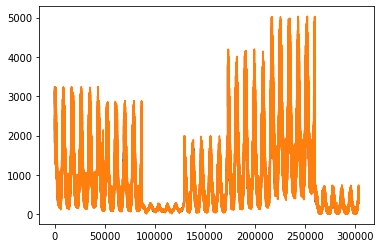

In [37]:
import matplotlib.pyplot as plt
plt.plot(preds_train_average, label = "pred-average")
plt.plot(y_train["power"].values, label = "actual")

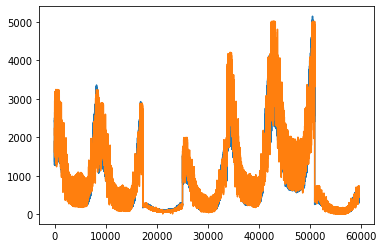

In [38]:
import matplotlib.pyplot as plt
plt.plot(preds_test_average, label = "pred-average")
plt.plot(y_test["power"].values, label = "actual")

In [39]:
# submission을 위해 새로 학습 및 예측 진행
df_train = None

for class_idx in range(len(class_list)):

    train_idx_list = []
    df_class = df[df["class"] == class_idx]

    for idx in range(len(df_class)):
        y = df_class['time'].iloc[idx].year
        m = df_class['time'].iloc[idx].month

        if y < 2019:
            train_idx_list.append(idx)

    df_train_class = df_class.iloc[train_idx_list]

    if df_train is None:
        df_train = df_train_class
    else:
        df_train = pd.concat([df_train, df_train_class], axis = 0)

In [40]:
idx_to_class = ['A','B','C','D',"E",'G','H']

df_submission = test_csv.copy()
df_submission = df_time_convert(df_submission)

df_submission['class'] = df_submission['class'].apply(lambda x : class_to_idx(x))
df_submission['class'] = df_submission['class'].astype("category")

df_submission["month_cos"] = np.cos(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))
df_submission["month_sin"] = np.sin(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))

df_submission["year_cos"] = np.cos(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))
df_submission["year_sin"] = np.sin(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))

df_submission["day_cos"] = np.cos(df_submission.hour.values * (2 * np.pi / 24))
df_submission["day_sin"] = np.sin(df_submission.hour.values * (2 * np.pi / 24))

# categorical variable로 전환
df_submission["class"] = df_submission["class"].astype("category")
df_submission["class"] = df_submission["class"].apply(lambda x : int(x))

df_submission["year"] = df_submission["time"].apply(lambda x : int(x.year))
df_submission["month"] = df_submission["time"].apply(lambda x : int(x.month))
df_submission["day"] = df_submission["time"].apply(lambda x : int(x.day))
df_submission["hour"] = df_submission["time"].apply(lambda x : int(x.hour))
df_submission["weekday"] = df_submission["time"].apply(lambda x : int(x.dayofweek))

df_submission["year"] = df_submission["year"].astype("int")
df_submission["month"] = df_submission["month"].astype("int")
df_submission["day"] = df_submission["day"].astype("int")
df_submission["hour"] = df_submission["hour"].astype("int")
df_submission["weekday"] = df_submission["weekday"].astype("category")

output.clear()

In [41]:
# columns for use
x_cols = ["year_cos", "year_sin", "month_cos", "month_sin", "day_cos", "day_sin","month", "year", "day", "hour", "class", "weekday"]
y_cols = ["log_power", "power"]

# k-fold validation
num_k = len(class_list)
k_fold = StratifiedKFold(n_splits = num_k, shuffle = True, random_state = 42)

x_train, y_train = df_train[x_cols], df_train[y_cols]
x_submission = df_submission[x_cols]

In [42]:
model_prophet_list = [NeuralProphet() for _ in range(len(class_list))]

pred_train_list = []
pred_sub_list = []

prophet_col = 'log_power'

for cls, model in zip(class_list, model_prophet_list):
    df_class = df_train[df_train["class"] == class_to_idx(cls)]

    df_input = pd.DataFrame()
    df_input['ds'] = df_class['time']
    df_input['y'] = df_class[prophet_col]

    loss = model.fit(df_input, freq = 'H')
    pred_train = model.predict(df_input)['yhat1'].values
    pred_train = convert2origin(pred_train)

    pred_train_list.append(pred_train)

    df_pred = pd.DataFrame()
    df_pred['ds'] = df_submission[df_submission["class"] == class_to_idx(cls)]['time'].reset_index(drop = True)
    df_pred['y'] = np.array([None for _ in range(len(df_pred))])
    
    pred_sub = model.predict(df_pred)['yhat1'].values
    pred_sub = convert2origin(pred_sub)
    pred_sub_list.append(pred_sub)

output.clear()

In [43]:
# evaluation
for cls, pred_train, pred_sub in zip(class_list, pred_train_list, pred_sub_list):

    train_actual = df_train[df_train["class"] == class_to_idx(cls)]["power"].values.reshape(-1,1)
    train_score = calc_nmae(train_actual, pred_train.reshape(-1,1))
    print("# Neural Prophet with class :{}, train score:{:.3f} ".format(cls, train_score))

# Neural Prophet with class :A, train score:0.176 
# Neural Prophet with class :B, train score:0.215 
# Neural Prophet with class :C, train score:0.107 
# Neural Prophet with class :D, train score:0.182 
# Neural Prophet with class :E, train score:0.177 
# Neural Prophet with class :G, train score:0.120 
# Neural Prophet with class :H, train score:0.209 


In [44]:
preds_train_prophet = None
preds_sub_prophet = None

for pred_train, pred_sub in zip(pred_train_list, pred_sub_list):

    if preds_train_prophet is None:
        preds_train_prophet = pred_train
    else:
        preds_train_prophet = np.concatenate((preds_train_prophet, pred_train), axis = 0)

    if preds_sub_prophet is None:
        preds_sub_prophet = pred_sub
    else:
        preds_sub_prophet = np.concatenate((preds_sub_prophet, pred_sub), axis = 0)

In [47]:
# stacking
preds_lgb = []
preds_xgb = []
preds_cbc = []

preds_lgb_sub = []
preds_xgb_sub = []
preds_cbc_sub = []

val_idxs = []
model_lgb_list = []
model_xgb_list = []
model_cbc_list = []

for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train, x_train['class'])):

    tr_x, val_x = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    tr_y, val_y = y_train[["log_power"]].iloc[tr_idx], y_train[["log_power"]].iloc[val_idx]

    lgb_train_data = lgb.Dataset(tr_x, tr_y)
    lgb_valid_data = lgb.Dataset(val_x, val_y)

    xgb_train_data = xgb.DMatrix(data = tr_x.values, label = tr_y[['log_power']].values, feature_names = x_train.columns)
    xgb_valid_data = xgb.DMatrix(data = val_x.values, label = val_y[['log_power']].values, feature_names = x_train.columns)
    xgb_sub_data = xgb.DMatrix(data = df_submission[x_cols].values, feature_names = df_submission[x_cols].columns)

    model_lgb = lgb.train(
        lgb_best_params, 
        lgb_train_data, 
        valid_sets = lgb_valid_data, 
        feval = custom_metric,
        categorical_feature = x_train.columns[x_train.dtypes == 'category'].to_list())
    
    model_lgb_list.append(model_lgb)

    model_xgb = xgb.train(
        xgb_best_params, 
        xgb_train_data, 
        evals=[(xgb_train_data,'train'), (xgb_valid_data,'valid')], 
        feval = xgb_custom_metric
    )

    model_xgb_list.append(model_xgb)

    cb_features = tr_x.columns[tr_x.dtypes == 'category'].to_list()
    model_cbc = CatBoostRegressor(**cbc_best_params)
    model_cbc.fit(tr_x, tr_y[['log_power']], eval_set = (val_x, val_y[['log_power']]), cat_features = cb_features)

    model_cbc_list.append(model_cbc)

    val_idxs.append(val_idx)
    pred_lgb = model_lgb.predict(val_x)
    pred_xgb = model_xgb.predict(xgb_valid_data)
    pred_cbc = model_cbc.predict(val_x)

    pred_lgb = convert2origin(pred_lgb)
    pred_xgb = convert2origin(pred_xgb)
    pred_cbc = convert2origin(pred_cbc)
    
    preds_lgb.append(pred_lgb)
    preds_xgb.append(pred_xgb)
    preds_cbc.append(pred_cbc)

    pred_lgb_sub = model_lgb.predict(x_submission)
    pred_xgb_sub = model_xgb.predict(xgb_sub_data)
    pred_cbc_sub = model_cbc.predict(x_submission)

    pred_lgb_sub = convert2origin(pred_lgb_sub)
    pred_xgb_sub = convert2origin(pred_xgb_sub)
    pred_cbc_sub = convert2origin(pred_cbc_sub)
   
    preds_lgb_sub.append(pred_lgb_sub)
    preds_xgb_sub.append(pred_xgb_sub)
    preds_cbc_sub.append(pred_cbc_sub)

preds_lgb = np.concatenate(preds_lgb, axis = 0)
preds_xgb = np.concatenate(preds_xgb, axis = 0)
preds_cbc = np.concatenate(preds_cbc, axis = 0)

val_idxs = np.concatenate(val_idxs)
order = np.argsort(val_idxs)

preds_train_lgb = preds_lgb[order]
preds_train_xgb = preds_xgb[order]
preds_train_cbc = preds_cbc[order]

preds_sub_lgb = np.mean(preds_lgb_sub, axis = 0)
preds_sub_xgb = np.mean(preds_xgb_sub, axis = 0)
preds_sub_cbc = np.mean(preds_cbc_sub, axis = 0)

lgb_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_lgb.reshape(-1,1))
xgb_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_xgb.reshape(-1,1))
cbc_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_cbc.reshape(-1,1))
prophet_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_prophet.reshape(-1,1))

print("# lgbm stacking ensemble train_score : {:.3f}".format(lgb_train_score))
print("# xgboost stacking ensemble train_score : {:.3f}".format(xgb_train_score))
print("# catboost stacking ensemble train_score : {:.3f}".format(cbc_train_score))
print("# prophet stacking ensemble train_score : {:.3f}".format(prophet_train_score))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['class', 'weekday']


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.




스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
465:	learn: 0.0294348	test: 0.0292935	best: 0.0292935 (465)	total: 24s	remaining: 27.5s
466:	learn: 0.0294208	test: 0.0292801	best: 0.0292801 (466)	total: 24.1s	remaining: 27.5s
467:	learn: 0.0294019	test: 0.0292606	best: 0.0292606 (467)	total: 24.1s	remaining: 27.4s
468:	learn: 0.0293110	test: 0.0291689	best: 0.0291689 (468)	total: 24.2s	remaining: 27.4s
469:	learn: 0.0293109	test: 0.0291688	best: 0.0291688 (469)	total: 24.3s	remaining: 27.4s
470:	learn: 0.0293108	test: 0.0291687	best: 0.0291687 (470)	total: 24.3s	remaining: 27.3s
471:	learn: 0.0293094	test: 0.0291674	best: 0.0291674 (471)	total: 24.3s	remaining: 27.2s
472:	learn: 0.0293080	test: 0.0291662	best: 0.0291662 (472)	total: 24.4s	remaining: 27.2s
473:	learn: 0.0292670	test: 0.0291234	best: 0.0291234 (473)	total: 24.4s	remaining: 27.1s
474:	learn: 0.0292464	test: 0.0291045	best: 0.0291045 (474)	total: 24.5s	remaining: 27.1s
475:	learn: 0.0292461	test: 0.0291041	best: 0.0291041 (475)	total:

In [48]:
# average sum
preds_train_average = (preds_train_lgb + preds_train_xgb + preds_train_cbc + preds_train_prophet)/4
preds_sub_average = (preds_sub_lgb + preds_sub_xgb + preds_sub_cbc + preds_sub_prophet)/4
average_train_score = calc_nmae(y_train["power"].values.reshape(-1,1), preds_train_average.reshape(-1,1))
print("# average ensemble train score : {:.3f}".format(average_train_score))

# average ensemble train score : 0.087


In [49]:
sample_submission["공급량"] = preds_sub_average

# submission 
from google.colab import files
sample_submission.to_csv("submission_1209.csv", index = False)
files.download("submission_1209.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>